# Random Sample Analysis: Simulations

## Summary

Tasks

- Define query
- Define functions
- Describe current random sample for selected segments
- Define necessary sample size for selected segment
- Run simulations and then compare metrics 

In [111]:
## Packages
import redshift_connector
import pandas as pd
import logging
import os
from datetime import timedelta

## Parameters

In [116]:
#Params
#do you need to download an existing data?
download = False

# Define the end date for your analysis (e.g., 7 days ago to allow for QA review time)s
START_DATE = '2025-06-01'
END_DATE = '2025-06-30'

#OR Relative date range
# days_back_for_sql = 30  # Number of days back from the end date for SQL
# START_DATE = (end_date - timedelta(days=days_back_for_sql)).strftime('%Y-%m-%d')
# END_DATE = end_date.strftime('%Y-%m-%d')

# Other query parameters
REVIEW_TYPE = ['random_sample', 'authentication_product'] #['random_sample', 'customer_reporting_1', 'authentication_product']
REVIEW_TYPE_FOR_QUERY = ', '.join(["'{}'".format(review_type) for review_type in REVIEW_TYPE])

# for Redshift connections
REDSHIFT_HOST = "wg-serverless-1.875431798560.eu-west-1.redshift-serverless.amazonaws.com"
REDSHIFT_DATABASE = "vaire"
REDSHIFT_USER = os.environ.get("REDSHIFT_USER")
REDSHIFT_PASSWORD = os.environ.get("REDSHIFT_PASSWORD")
REDSHIFT_PORT = 5439

## ready file if any
file_path = 'sample_data_monthly.csv'

## Query

In [117]:
query = f"""
WITH 
customers as (
select
    fvs.vendor_display_name as customer
    ,fvs.vendor_dim_id
    ,COUNT(*) AS sessions
from
    analytics_mart_kpi.mart_kpi__verification_session_metrics fvs
where true
    and date(fvs.verified_at) >= CAST('{START_DATE}' AS DATE)
    and date(fvs.verified_at) <= CAST('{END_DATE}' AS DATE)
group by
    1,2
)
, customer_ranked as (
select 
    c.customer
    , c.vendor_dim_id
    , ROW_NUMBER() OVER (ORDER BY c.sessions DESC) as customer_rank
from customers c
)
, data AS (
select 
--dimensions
    vs.document_country_sf_region as region
    , coalesce(vs.document_specimen_country_name, 'UNKNOWN') as document_country
    , coalesce(vs.geoip_country_iso2, 'UNKNOWN') as geoip_country
    , coalesce(vs.platform, 'UNKNOWN') as platform
    , coalesce(vs.primary_product, 'UNKNOWN') as primary_product
    , coalesce(vs.primary_industry, 'UNKNOWN') as industry
    , coalesce(vs.sf_customer_priority, 'UNKNOWN') as customer_priority
    , coalesce(vs.vendor_display_name, 'UNKNOWN') as customer
    , CASE WHEN c.customer_rank <= 20 THEN vs.vendor_display_name ELSE 'Other' END as customer_top_20
    , CASE
        WHEN vs.primary_product IN ('IDV', 'Document Verification', 'AIC') THEN 'IDV'
        WHEN vs.primary_product LIKE 'Full Auto%' THEN 'Full Auto'
        WHEN vs.primary_product LIKE '%Biometric%' OR vs.primary_product IN ('Face Match', 'Age Estimation') THEN 'Biometric Solutions'
        WHEN vs.primary_product = 'Unknown' THEN 'Unknown'
        ELSE 'Data Verification'
    END as product_portfolio
    --session related
    , vs.verification_session_uuid
    , CAST(vs.verified_at as DATE) as verified_date
    , vs.verification_session_status
    , vs.verification_session_status = 'declined' as is_decline
    , vs.verification_session_status = 'approved' as is_approve
    , vs.is_full_auto_session
    --fraud
    , vs.is_fraudulent_sessions_other or vs.is_fraudulent_sessions_velocity as is_declined_due_to_fraud
    --qa related
    , qa.verification_session_uuid as qa_verification_session_uuid
    , qa.qa_review_type
    , qa.flag_session_has_decision_error
    , qa.flag_session_has_critical_approve_error
    , qa.flag_session_has_critical_decline_error
    , qa.flag_session_has_extraction_error
    , qa.is_session_approved_fraud
    , qa.is_session_fraud
    , qa.qa_decision
    , qa.original_decision
    , qa.qa_decision = 'declined' as qa_declinable
    , qa.qa_decision = 'approved' as qa_approvable
from analytics_mart_kpi.mart_kpi__verification_session_metrics vs
left join analytics_mart_automation.mart_automation__verification_session_qa_review qa
    on vs.verification_session_uuid = qa.verification_session_uuid
    and vs.shard_key = qa.shard_key
    and qa.qa_review_type IN ({REVIEW_TYPE_FOR_QUERY})
left join customer_ranked c on vs.vendor_dim_id = c.vendor_dim_id
where true
    and date(verified_at) >= CAST('{START_DATE}' AS DATE)
    and date(verified_at) <= CAST('{END_DATE}' AS DATE)
    --and vs.service_agreement_stage NOT IN ('test', 'test_low')
)
, unique_dates_count AS (
    SELECT COUNT(DISTINCT verified_date) AS days_count
    FROM data
)
, aggregated_data AS (
select 
    udc.days_count as days_count
    , 'Overall' as overall
    , a.product_portfolio
    , a.primary_product
    , a.platform
    , a.region
    , a.document_country
    , a.geoip_country
    , a.industry
    , a.customer
    , a.customer_top_20
    , a.customer_priority
    , COALESCE(COUNT(DISTINCT a.verification_session_uuid),0) as volume
    , COALESCE(COUNT(DISTINCT a.qa_verification_session_uuid),0) as qa_reviewed
    --from total population
    , SUM(a.is_full_auto_session::int) as full_auto_sessions
    , SUM(a.is_decline::int) as declined_sessions
    , SUM(a.is_approve::int) as approved_sessions
    , SUM(a.is_declined_due_to_fraud::int) as declined_due_to_fraud_sessions
    --from QA 
    , SUM(a.flag_session_has_decision_error::int) as decision_error_sessions
    , SUM(a.flag_session_has_extraction_error::int) as extraction_error_sessions
    , SUM(a.flag_session_has_critical_approve_error::int) as false_approves
    , SUM(a.flag_session_has_critical_decline_error::int) as false_declines
    , SUM(a.is_session_approved_fraud::int) as missed_fraud_sessions
    , SUM(a.qa_declinable::int) as declinable_sessions
    , SUM(a.qa_approvable::int) as approvable_sessions
    , SUM(a.is_session_fraud::int) as fraud_sessions
    , 1.00 * full_auto_sessions / NULLIF(volume, 0) as automation_rate 
    , 1.00 * declined_sessions / NULLIF(volume, 0) as decline_rate_in_population
    , 1.00 * approved_sessions / NULLIF(volume, 0) as approve_rate_in_population
    , 1.00 * declined_due_to_fraud_sessions / NULLIF(volume, 0) as fraud_rate_in_population
    , 1.00 * decision_error_sessions / NULLIF(qa_reviewed, 0) as decision_error_rate
    , 1.00 * extraction_error_sessions / NULLIF(qa_reviewed, 0) as extraction_error_rate
    , 1.00 * false_approves / NULLIF(declinable_sessions, 0) as false_approve_rate
    , 1.00 * false_declines / NULLIF(approvable_sessions, 0) as false_decline_rate
    , 1.00 * missed_fraud_sessions / NULLIF(fraud_sessions, 0) as missed_fraud_rate
    , 1.00 * declinable_sessions / NULLIF(qa_reviewed, 0) as decline_rate_in_qa
    , 1.00 * approvable_sessions / NULLIF(qa_reviewed, 0) as approve_rate_in_qa
    , 1.00 * fraud_sessions / NULLIF(qa_reviewed, 0) as fraud_rate_in_qa
    , sum(volume) over () as total_volume
    , sum(qa_reviewed) over () as total_qa_reviewed
    , 1.00 * volume / NULLIF(total_volume,0) as proportion_of_total_volume
    , 1.00 * qa_reviewed / NULLIF(total_qa_reviewed,0) as proportion_of_qa_sample
from data a
cross join unique_dates_count udc
group by 1,2,3,4,5,6,7,8,9,10,11,12
order by volume desc
)
SELECT *
from aggregated_data
"""

## Functions

In [118]:
#Redshift Connector 

import redshift_connector
import pandas as pd
import logging
import os

# Configure logging for better error visibility
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_redshift_dataframe(
    sql_query: str,
    host: str,
    database: str,
    user: str,
    password: str,
    port: int = 5439 # Default Redshift port
) -> pd.DataFrame:
    """
    Connects to Amazon Redshift, executes a SQL query, and returns the result
    as a pandas DataFrame.

    Args:
        sql_query (str): The SQL query string to execute.
        host (str): The Redshift cluster endpoint (e.g., 'your-cluster.xxxx.region.redshift.amazonaws.com').
        database (str): The name of the database to connect to.
        user (str): The username for Redshift authentication.
        password (str): The password for Redshift authentication.
        port (int): The port number for the Redshift connection (default is 5439).

    Returns:
        pd.DataFrame: A pandas DataFrame containing the query results.
                      Returns an empty DataFrame if an error occurs or no data is found.

    Raises:
        Exception: Re-raises any connection or query execution errors after logging.
    """
    conn = None # Initialize connection to None
    try:
        logging.info(f"Attempting to connect to Redshift database: {database}@{host}:{port} with user: {user}")
        conn = redshift_connector.connect(
            host=host,
            database=database,
            user=user,
            password=password,
            port=port
        )
        logging.info("Successfully connected to Redshift.")

        logging.info("Executing SQL query...")
        # Use pandas read_sql for direct DataFrame conversion
        df = pd.read_sql(sql_query, conn)
        logging.info(f"Query executed successfully. Fetched {len(df)} rows.")

        return df

    except redshift_connector.Error as e:
        logging.error(f"Redshift connection or query error: {e}")
        return pd.DataFrame() # Return empty DataFrame on specific Redshift errors
    except Exception as e:
        logging.error(f"An unexpected error occurred: {e}")
        # Optionally re-raise the exception if you want calling code to handle it
        raise
    finally:
        if conn:
            logging.info("Closing Redshift connection.")
            conn.close()
        else:
            logging.warning("Connection was not established, so nothing to close.")

## Run Query

In [119]:
if download:
    df = pd.read_csv(file_path)
else:
    df = get_redshift_dataframe(
                sql_query=query, # Pass the multi-line query variable here
                host=REDSHIFT_HOST,
                database=REDSHIFT_DATABASE,
                user=REDSHIFT_USER,
                password=REDSHIFT_PASSWORD,
                port=REDSHIFT_PORT
            )

    if not df.empty:
        # Save the DataFrame to a CSV file
        df.to_csv(file_path, index=False)
        print("\nSuccessfully fetched data from Redshift:")
        print(df.head())
        print(f"\nDataFrame shape: {df.shape}")
    else:
        print("\nNo data fetched or an error occurred.")

2025-07-29 17:04:19,259 - INFO - Attempting to connect to Redshift database: vaire@wg-serverless-1.875431798560.eu-west-1.redshift-serverless.amazonaws.com:5439 with user: gadir_mamedov
2025-07-29 17:04:19,768 - INFO - Successfully connected to Redshift.
2025-07-29 17:04:19,769 - INFO - Executing SQL query...
2025-07-29 17:06:12,116 - INFO - Query executed successfully. Fetched 84286 rows.
2025-07-29 17:06:12,117 - INFO - Closing Redshift connection.



Successfully fetched data from Redshift:
   days_count  overall    product_portfolio                    primary_product platform region          document_country geoip_country        industry           customer    customer_top_20 customer_priority   volume  qa_reviewed  full_auto_sessions  declined_sessions  approved_sessions  declined_due_to_fraud_sessions  decision_error_sessions  extraction_error_sessions  false_approves  false_declines  missed_fraud_sessions  declinable_sessions  approvable_sessions  fraud_sessions  automation_rate  decline_rate_in_population  approve_rate_in_population  fraud_rate_in_population  decision_error_rate  extraction_error_rate  false_approve_rate  false_decline_rate  missed_fraud_rate  decline_rate_in_qa  approve_rate_in_qa  fraud_rate_in_qa  total_volume  total_qa_reviewed  proportion_of_total_volume  proportion_of_qa_sample
0          30  Overall            Full Auto  Full Auto IDV (Selfie & Document)      api   AMER  United States of America       U

# CODE

In [147]:
#MAIN CODE
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import math
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
from typing import List, Dict, Any, Union, Tuple, Callable

np.random.seed(20)

# Suppress all warnings for cleaner output during execution.
warnings.filterwarnings('ignore')

# --- Configuration Parameters (Default Values for UI) ---
# These parameters serve as initial default values for the interactive UI.
# They will be updated by the UI input and passed via the 'params' dictionary.
DEFAULT_SELECTED_METRIC = 'Missed Fraud Rate'      
DEFAULT_TARGET_OVERALL_ERROR_PERCENT = 2.0         
DEFAULT_TARGET_DIMENSION_ERROR_PERCENT = 2.0       
DEFAULT_CONFIDENCE_LEVEL = 0.95                    
DEFAULT_REVIEW_COST_PER_SESSION = 0.6       
DEFAULT_PREDEFINED_TOTAL_COST_BUDGET = 60000.0   
DEFAULT_WEIGHT_FACTOR_SMALL_CUSTOMERS = 10        
DEFAULT_SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD = 0.99
DEFAULT_ERROR_MARGIN_LOGIC = 'Absolute Error Margin'
DEFAULT_ABSOLUTE_ERROR_MARGIN_VALUE = 0.02         
DEFAULT_RELATIVE_ERROR_MARGIN_VALUE = 0.2         
DEFAULT_MIN_ABSOLUTE_ERROR_MARGIN = 0.005          
DEFAULT_REPORTING_DIMENSIONS = ['customer', 'customer_top_20', 'primary_product', 'industry', 'region','document_country', 'platform', 'customer_priority', 'product_portfolio']        
DEFAULT_STRATIFY_BY_DIMENSION = ['primary_product', 'industry', 'region', 'platform', 'customer_top_20', 'document_country']
DEFAULT_AVAILABLE_PRODUCTS = ['Full Auto IDV (Document Only)', 'Full Auto IDV (Selfie & Document)', 'Document Verification', 'IDV', 'Biometric Authentication', 'Biometric Enrolment', 'Biometric Passive Liveness']
DEFAULT_TOP_N = 10                                 
DEFAULT_SAVE_PLOTS_TO_HTML = False          
DEFAULT_MIN_PER_STRATUM = 1000       

# --- Global Variables (will be set by UI or default values in generate_report) ---
# These are defined globally for convenience but will be effectively
# managed by the 'params' dictionary passed to generate_report.
SELECTED_METRIC = DEFAULT_SELECTED_METRIC
TARGET_OVERALL_ERROR_PERCENT = DEFAULT_TARGET_OVERALL_ERROR_PERCENT
TARGET_DIMENSION_ERROR_PERCENT = DEFAULT_TARGET_DIMENSION_ERROR_PERCENT
CONFIDENCE_LEVEL = DEFAULT_CONFIDENCE_LEVEL
REVIEW_COST_PER_SESSION = DEFAULT_REVIEW_COST_PER_SESSION
PREDEFINED_TOTAL_COST_BUDGET = DEFAULT_PREDEFINED_TOTAL_COST_BUDGET
WEIGHT_FACTOR_SMALL_CUSTOMERS = DEFAULT_WEIGHT_FACTOR_SMALL_CUSTOMERS
SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD = DEFAULT_SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD
ERROR_MARGIN_LOGIC = DEFAULT_ERROR_MARGIN_LOGIC
ABSOLUTE_ERROR_MARGIN_VALUE = DEFAULT_ABSOLUTE_ERROR_MARGIN_VALUE
RELATIVE_ERROR_MARGIN_VALUE = DEFAULT_RELATIVE_ERROR_MARGIN_VALUE
MIN_ABSOLUTE_ERROR_MARGIN = DEFAULT_MIN_ABSOLUTE_ERROR_MARGIN
REPORTING_DIMENSIONS = DEFAULT_REPORTING_DIMENSIONS
STRATIFY_BY_DIMENSION = DEFAULT_STRATIFY_BY_DIMENSION
TOP_N = DEFAULT_TOP_N
SAVE_PLOTS_TO_HTML = DEFAULT_SAVE_PLOTS_TO_HTML

TARGET_QA_PROPORTIONS = {
    'Tier Platinum': 0.20,
    'Tier 1': 0.15,
    'Tier 2': 0.15,
    'Tier 3': 0.15,
    'Tier 4': 0.15,
    'Tier 5': 0.10,
    'UNKNOWN': 0.10,
    '': 0.10  # For unknown/blank
}

# Pre-calculate Z-score for the given confidence level.
# This Z-score is used in confidence interval calculations (e.g., Wilson Score).
Z_SCORE = stats.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2)

# --- Metric Properties ---
# This dictionary defines the columns associated with each metric,
# including numerator, denominator, and base for frequency calculations.
METRIC_PROPERTIES = {
    'Decision Error Rate': {
        'numerator_col': 'decision_error_sessions',
        'denominator_col': 'qa_reviewed',
        'freq_denominator_base_col': 'qa_reviewed',
    },
    'Extraction Error Rate': {
        'numerator_col': 'extraction_error_sessions',
        'denominator_col': 'qa_reviewed',
        'freq_denominator_base_col': 'qa_reviewed',
    },
    'False Approve Rate': {
        'numerator_col': 'false_approves',
        'denominator_col': 'declinable_sessions',
        'freq_denominator_base_col': 'qa_reviewed',
    },
    'False Decline Rate': {
        'numerator_col': 'false_declines',
        'denominator_col': 'approvable_sessions',
        'freq_denominator_base_col': 'qa_reviewed',
    },
    'Missed Fraud Rate': {
        'numerator_col': 'missed_fraud_sessions',
        'denominator_col': 'fraud_sessions',
        'freq_denominator_base_col': 'qa_reviewed',
    },
    'automation_rate': {
        'numerator_col': 'full_auto_sessions',
        'denominator_col': 'volume',
        'freq_denominator_base_col': 'volume',
    },
    'decline_rate_in_population': {
        'numerator_col': 'declined_sessions',
        'denominator_col': 'volume',
        'freq_denominator_base_col': 'volume'
    },
    'approve_rate_in_population': {
        'numerator_col': 'approved_sessions',
        'denominator_col': 'volume',
        'freq_denominator_base_col': 'volume'
    },
    'fraud_rate_in_population': {
        'numerator_col': 'declined_due_to_fraud_sessions',
        'denominator_col': 'volume',
        'freq_denominator_base_col': 'volume'
    },
    'fraud_rate_in_qa': {
        'numerator_col': 'fraud_sessions',
        'denominator_col': 'qa_reviewed',
        'freq_denominator_base_col': 'qa_reviewed'
    },
    'decline_rate_in_qa': {
        'numerator_col': 'declinable_sessions',
        'denominator_col': 'qa_reviewed',
        'freq_denominator_base_col': 'qa_reviewed'
    },
    'approve_rate_in_qa': {
        'numerator_col': 'approvable_sessions',
        'denominator_col': 'qa_reviewed',
        'freq_denominator_base_col': 'qa_reviewed'
    },
}

# --- Statistical Calculation Functions ---

def assign_true_random_sample(df: pd.DataFrame, total_qa_reviewed: int, random_state: int = 20) -> pd.DataFrame:
    """
    Assigns a truly random sample (proportional to volume) to the DataFrame.
    Adds a column 'true_random_qa_reviewed' with the number of QA-reviewed sessions per row.
    """
    np.random.seed(random_state)
    df = df.copy()
    if df['volume'].sum() == 0:
        df['true_random_qa_reviewed'] = 0
        return df
    probs = df['volume'] / df['volume'].sum()
    df['true_random_qa_reviewed'] = np.random.multinomial(total_qa_reviewed, probs)
    return df

def calculate_adjusted_proportion_agresti_coull(numerator: Union[float, np.ndarray], denominator: Union[float, np.ndarray], z_score: float) -> Union[float, np.ndarray]:
    """
    Calculates the Agresti-Coull adjusted proportion.
    """
    numerator = np.asarray(numerator).astype(float)
    denominator = np.asarray(denominator).astype(float)
    
    z_squared = z_score**2
    adjusted_num = numerator + z_squared / 2
    adjusted_den = denominator + z_squared

    result = np.where(adjusted_den == 0, 0.0, adjusted_num / adjusted_den)
    return result

# def calculate_margin_wilson(k: Union[float, np.ndarray], n: Union[float, np.ndarray], z_score: float, min_required_n=None) -> Dict[str, Union[float, np.ndarray]]:
#     """
#     Calculates the error margin for a proportion using the Wilson Score Interval.
#     """
#     k = np.asarray(k).astype(float)
#     n = np.asarray(n).astype(float)

#     p_hat = np.where(n > 0, k / n, 0.0)

#     z_squared = z_score**2
    
#     denominator_wilson = np.where(n > 0, 1.0 + z_squared / n, np.nan) 

#     sqrt_content = np.where(n > 0, 
#                             p_hat * (1 - p_hat) / n + z_squared / (4 * n**2), 
#                             0.0) 

#     numerator_wilson_base = np.where(n > 0, p_hat + z_squared / (2 * n), np.nan) 

#     lower_bound = np.where(
#         (denominator_wilson > 0) & np.isfinite(numerator_wilson_base),
#         (numerator_wilson_base - z_score * np.sqrt(sqrt_content)) / denominator_wilson,
#         np.nan
#     )
#     upper_bound = np.where(
#         (denominator_wilson > 0) & np.isfinite(numerator_wilson_base),
#         (numerator_wilson_base + z_score * np.sqrt(sqrt_content)) / denominator_wilson,
#         np.nan
#     )

#     lower_bound = np.maximum(0.0, lower_bound)
#     upper_bound = np.minimum(1.0, upper_bound)

#     margin_abs = (upper_bound - lower_bound) / 2

#     # # If denominator is zero, margin_abs should be np.nan
#     # margin_abs = np.where(n == 0, np.nan, margin_abs)
#     # # margin_rel: if margin_abs is nan or p_hat==0, set to np.nan
#     # margin_rel = np.where((margin_abs == 0) & (p_hat > 0), 0.0, np.where((margin_abs == 0) & (p_hat == 0), np.nan, margin_abs / p_hat))
#     # margin_rel = np.where(n == 0, np.nan, margin_rel)

#     # return {'margin': margin_abs, 'margin_rel': margin_rel}

#     margin_rel = np.where(p_hat > 0, margin_abs / p_hat, np.inf)

#     # --- PATCH: If n < min_required_n, set margin to np.nan or flag ---
#     if min_required_n is not None:
#         margin_abs = np.where(n < min_required_n, np.nan, margin_abs)
#         margin_rel = np.where(n < min_required_n, np.nan, margin_rel)

#     margin_abs = np.nan_to_num(margin_abs, nan=0.9, posinf=0.9, neginf=0.9)
#     margin_rel = np.where(margin_abs == 0, np.nan, np.nan_to_num(margin_rel, nan=0.9, posinf=0.9, neginf=0.9))

#     return {'margin': margin_abs, 'margin_rel': margin_rel}

def calculate_margin_wilson(k: Union[float, np.ndarray], n: Union[float, np.ndarray], z_score: float, min_required_n=None) -> Dict[str, Union[float, np.ndarray]]:
    """
    Calculates the error margin for a proportion using the Wilson Score Interval.
    If denominator is zero, assigns a large error margin (e.g., 0.9).
    """
    k = np.asarray(k).astype(float)
    n = np.asarray(n).astype(float)

    p_hat = np.where(n > 0, k / n, 0.0)
    z_squared = z_score**2

    denominator_wilson = np.where(n > 0, 1.0 + z_squared / n, np.nan)
    sqrt_content = np.where(n > 0, p_hat * (1 - p_hat) / n + z_squared / (4 * n**2), 0.0)
    numerator_wilson_base = np.where(n > 0, p_hat + z_squared / (2 * n), np.nan)

    lower_bound = np.where(
        (denominator_wilson > 0) & np.isfinite(numerator_wilson_base),
        (numerator_wilson_base - z_score * np.sqrt(sqrt_content)) / denominator_wilson,
        np.nan
    )
    upper_bound = np.where(
        (denominator_wilson > 0) & np.isfinite(numerator_wilson_base),
        (numerator_wilson_base + z_score * np.sqrt(sqrt_content)) / denominator_wilson,
        np.nan
    )

    lower_bound = np.maximum(0.0, lower_bound)
    upper_bound = np.minimum(1.0, upper_bound)

    margin_abs = (upper_bound - lower_bound) / 2

    # If denominator is zero, assign large error margin (e.g., 0.9)
    margin_abs = np.where(n == 0, 0.9, margin_abs)
    margin_abs = np.nan_to_num(margin_abs, nan=0.9, posinf=0.9, neginf=0.9)

    margin_rel = np.where(p_hat > 0, margin_abs / p_hat, 0.9)
    margin_rel = np.where(n == 0, 0.9, margin_rel)
    margin_rel = np.nan_to_num(margin_rel, nan=0.9, posinf=0.9, neginf=0.9)

    # Optionally: If min_required_n is set, set margin to 0.9 if n < min_required_n
    if min_required_n is not None:
        margin_abs = np.where(n < min_required_n, 0.9, margin_abs)
        margin_rel = np.where(n < min_required_n, 0.9, margin_rel)

    return {'margin': margin_abs, 'margin_rel': margin_rel}

def get_margins_df(df: pd.DataFrame, k_col: str, n_col: str, z_score: float,  min_required_n=None) -> pd.DataFrame:
    """
    Applies the Wilson Score interval calculation to DataFrame columns to get error margins.
    """
    k = df[k_col].values
    n = df[n_col].values
    results = calculate_margin_wilson(k, n, z_score, min_required_n=min_required_n)
    
    results_df = pd.DataFrame(results, index=df.index)
     # Flag problematic rows
    results_df['margin_flag'] = np.where(
        (df[n_col] == 0) | (np.isnan(results_df['margin'])) | (np.isinf(results_df['margin'])),
        'Problematic', 'OK'
    )
    return pd.concat([df, results_df], axis=1)

def calculate_required_sample_size_proportion(population_proportion: float, absolute_margin_of_error: float, confidence_level: float, population_size: int, z_score: float) -> Union[int, float]:
    """
    Calculates the required sample size for estimating a population proportion
    with a specified absolute margin of error and confidence level, using the finite population correction factor.
    """
    z = z_score
    p = population_proportion
    e = absolute_margin_of_error

    if p == 0: p = 1e-9
    if p == 1: p = 1 - 1e-9

    numerator_val = (z**2 * p * (1 - p)) / e**2

    if population_size <= 1:
        denominator_fpc = 1.0
    else:
        denominator_fpc = 1.0 + (numerator_val / (population_size - 1))

    if denominator_fpc == 0:
        return float('inf')

    n = numerator_val / denominator_fpc

    # --- FIX: handle NaN or inf ---
    if not np.isfinite(n) or np.isnan(n):
        return float('inf')
    return max(1, math.ceil(n))

# --- Data Preparation Functions ---

def get_tier_weights_by_target_proportion(df, target_proportions):
    # Defensive: If 'customer_priority' or 'volume' missing, return all weights as 1
    if 'customer_priority' not in df.columns or 'volume' not in df.columns:
        # Return a dict with all tiers set to 1.0
        return {tier: 1.0 for tier in target_proportions}
    # Calculate actual volume proportions
    actual = df.groupby('customer_priority')['volume'].sum()
    total = actual.sum()
    actual_proportions = (actual / total).to_dict()
    # Calculate weights as ratio of target to actual
    weights = {}
    for tier, target in target_proportions.items():
        actual_prop = actual_proportions.get(tier, 0.01)  # avoid zero
        weights[tier] = target / actual_prop
    return weights

def calculate_all_rates(df: pd.DataFrame, metric_properties: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    """
    Calculates various rates (e.g., automation rate, error rates) based on the provided DataFrame.
    """
    df_copy = df.copy()
    rates_to_calculate = {
        'automation_rate': ('full_auto_sessions', 'volume'),
        'decline_rate_in_population': ('declined_sessions', 'volume'),
        'approve_rate_in_population': ('approved_sessions', 'volume'),
        'fraud_rate_in_population': ('declined_due_to_fraud_sessions', 'volume'),
        'decision_error_rate': ('decision_error_sessions', 'qa_reviewed'),
        'extraction_error_rate': ('extraction_error_sessions', 'qa_reviewed'),
        'false_approve_rate': ('false_approves', 'declinable_sessions'),
        'false_decline_rate': ('false_declines', 'approvable_sessions'),
        'missed_fraud_rate': ('missed_fraud_sessions', 'fraud_sessions'),
        'decline_rate_in_qa': ('declinable_sessions', 'qa_reviewed'),
        'approve_rate_in_qa': ('approvable_sessions', 'qa_reviewed'),
        'fraud_rate_in_qa': ('fraud_sessions', 'qa_reviewed'),
    }

    for rate_name, (numerator_col, denominator_col) in rates_to_calculate.items():
        if numerator_col in df_copy.columns and denominator_col in df_copy.columns:
            df_copy.loc[:, rate_name] = df_copy[numerator_col] / df_copy[denominator_col].replace(0, np.nan)
        else:
            warnings.warn(f"Columns '{numerator_col}' or '{denominator_col}' not found for calculating '{rate_name}'. Skipping rate calculation.")
            df_copy.loc[:, rate_name] = np.nan
            
    df_copy.fillna(0, inplace=True)
    return df_copy

def aggregate_population_df(df, reporting_dimensions, metric_properties):
    agg_dict = {col: 'sum' for props in metric_properties.values() for col in [props['numerator_col'], props['denominator_col'], props['freq_denominator_base_col']] if col in df.columns}
    agg_dict['volume'] = 'sum'
    return df.groupby(reporting_dimensions, as_index=False).agg(agg_dict)

def prepare_population_data(df: pd.DataFrame, selected_metric: str, metric_properties: Dict[str, Dict[str, str]], z_score: float, reporting_dimensions: list = None) -> Tuple[pd.DataFrame, Dict[str, float], Dict[str, float]]:
    """
    Prepares the aggregated population data by calculating all rates
    and global average metrics/frequencies.
    """
    df = df.copy()
    # Aggregate by reporting dimensions if provided
    if reporting_dimensions is not None and len(reporting_dimensions) > 0:
        df = aggregate_population_df(df, reporting_dimensions, metric_properties)
    df = calculate_all_rates(df, metric_properties)

    global_avg_metrics = {}
    for metric_name, props in metric_properties.items():
        num_col = props['numerator_col']
        den_col = props['denominator_col']
        if num_col in df.columns and den_col in df.columns:
            total_numerator = df[num_col].sum()
            total_denominator = df[den_col].sum()
            if total_denominator > 0:
                global_avg_metrics[metric_name] = calculate_adjusted_proportion_agresti_coull(total_numerator, total_denominator, z_score)
            else:
                global_avg_metrics[metric_name] = 0
        else:
            global_avg_metrics[metric_name] = 0

    overall_avg_frequencies_in_qa = {}
    for metric_name, props in metric_properties.items():
        base_col = props['freq_denominator_base_col']
        den_col = props['denominator_col']
        if base_col in df.columns and den_col in df.columns:
            base_col_sum = df[base_col].sum()
            denominator_col_sum = df[den_col].sum()
            overall_avg_frequencies_in_qa[metric_name] = (denominator_col_sum / base_col_sum) if base_col_sum > 0 else 0
        else:
            overall_avg_frequencies_in_qa[metric_name] = 0

    return df, global_avg_metrics, overall_avg_frequencies_in_qa

def calculate_weighted_metric(df: pd.DataFrame, metric: str, weight_col: str) -> float:
    """
    Calculates weighted average for a metric using provided weights.
    """
    props = METRIC_PROPERTIES[metric]
    num = df[props['numerator_col']]
    den = df[props['denominator_col']]
    weights = df[weight_col]
    weighted_num = (num * weights).sum()
    weighted_den = (den * weights).sum()
    return weighted_num / weighted_den if weighted_den > 0 else np.nan

# def prepare_population_data(df: pd.DataFrame, selected_metric: str, metric_properties: Dict[str, Dict[str, str]], z_score: float) -> Tuple[pd.DataFrame, Dict[str, float], Dict[str, float]]:
#     """
#     Prepares the aggregated population data by calculating all rates
#     and global average metrics/frequencies.
#     """
#     df = df.copy()
#     df = df.
#     df = calculate_all_rates(df, metric_properties)

#     global_avg_metrics = {}
#     for metric_name, props in metric_properties.items():
#         num_col = props['numerator_col']
#         den_col = props['denominator_col']
#         if num_col in df.columns and den_col in df.columns:
#             total_numerator = df[num_col].sum()
#             total_denominator = df[den_col].sum()
#             if total_denominator > 0:
#                 global_avg_metrics[metric_name] = calculate_adjusted_proportion_agresti_coull(total_numerator, total_denominator, z_score)
#             else:
#                 global_avg_metrics[metric_name] = 0
#         else:
#             global_avg_metrics[metric_name] = 0
    
#     overall_avg_frequencies_in_qa = {}
#     for metric_name, props in metric_properties.items():
#         base_col = props['freq_denominator_base_col']
#         den_col = props['denominator_col']
#         if base_col in df.columns and den_col in df.columns:
#             base_col_sum = df[base_col].sum()
#             denominator_col_sum = df[den_col].sum()
#             overall_avg_frequencies_in_qa[metric_name] = (denominator_col_sum / base_col_sum) if base_col_sum > 0 else 0
#         else:
#             overall_avg_frequencies_in_qa[metric_name] = 0
    
#     return df, global_avg_metrics, overall_avg_frequencies_in_qa

def get_frequency_of_denominator(df: pd.DataFrame, metric: str, metric_properties: Dict[str, Dict[str, str]], overall_avg_frequencies_in_qa: Dict[str, float]) -> np.ndarray:
    """
    Calculates the frequency of the denominator for a given metric within the DataFrame.
    """
    props = metric_properties[metric]
    freq_base_col = props['freq_denominator_base_col']
    den_col = props['denominator_col']

    if freq_base_col not in df.columns or den_col not in df.columns:
        warnings.warn(f"Frequency base column '{freq_base_col}' or denominator column '{den_col}' not found in DataFrame for metric '{metric}'. Using global frequency as fallback for all rows.")
        return np.full(len(df), overall_avg_frequencies_in_qa.get(metric, 0))

    freq = df[den_col] / df[freq_base_col].replace(0, np.nan)
    freq = freq.fillna(0.0)

    MIN_FREQ = 0.01  # Set a reasonable minimum frequency (e.g., 1%)
    global_freq_val = max(overall_avg_frequencies_in_qa.get(metric, MIN_FREQ), MIN_FREQ)
    freq = np.where(freq < MIN_FREQ, global_freq_val, freq)
    freq = np.maximum(freq, MIN_FREQ)

    return freq


# def calculate_required_sessions(
#     df: pd.DataFrame,
#     metric: str,
#     global_rates: Dict[str, float],
#     global_freq: Dict[str, float],
#     error_margin_logic: str,
#     absolute_error_margin_value: float,
#     relative_error_margin_value: float,
#     min_absolute_error_margin: float,
#     confidence_level: float,
#     z_score: float
# ) -> Tuple[List[Union[int, float]], List[Union[int, float]], np.ndarray]:
#     """
#     Calculates the required QA reviewed sessions for each group (row in df) to achieve
#     the target error margin for the selected metric.
#     If denominator is zero, estimate denominator as group volume * global_freq,
#     and numerator as estimated_denominator * global_rate.
#     Returns: (required_sample_size, extra_reviews, adj_error_margin)
#     """
#     props = METRIC_PROPERTIES[metric]
#     num_col = props['numerator_col']
#     den_col = props['denominator_col']
#     freq_base_col = props['freq_denominator_base_col']

#     if den_col not in df.columns or num_col not in df.columns:
#         warnings.warn(f"Numerator '{num_col}' or Denominator '{den_col}' column not found in input DataFrame for `calculate_required_sessions`. Cannot proceed.")
#         return [float('inf')] * len(df), [float('inf')] * len(df), np.full(len(df), np.nan)

#     denominator_n_series = df[den_col].astype(float)
#     numerator_series = df[num_col].astype(float)
#     volume_series = df['volume'].astype(float) if 'volume' in df.columns else denominator_n_series

#     global_rate = global_rates.get(metric, 0)
#     global_freq_val = global_freq.get(metric, 0)

#     adjusted_p_estimates = []
#     population_size_series = []

#     for i in range(len(df)):
#         if denominator_n_series.iloc[i] == 0:
#             safe_freq = max(global_freq_val, 0.01)
#             est_denominator = max(1, int(volume_series.iloc[i] * safe_freq))
#             est_numerator = int(est_denominator * global_rate)
#             p_val = global_rate
#             group_population_size = volume_series.iloc[i]
#         else:
#             est_denominator = denominator_n_series.iloc[i]
#             est_numerator = numerator_series.iloc[i]
#             p_val = calculate_adjusted_proportion_agresti_coull(est_numerator, est_denominator, z_score)
#             group_population_size = volume_series.iloc[i]

#         adjusted_p_estimates.append(p_val)
#         population_size_series.append(group_population_size)

#     adjusted_p_estimates = np.array(adjusted_p_estimates)
#     population_size_series = np.array(population_size_series)

#     if error_margin_logic == 'Relative Error Margin':
#         adj_error_margin = np.maximum(relative_error_margin_value * adjusted_p_estimates, min_absolute_error_margin)
#     else:
#         adj_error_margin = np.full_like(adjusted_p_estimates, max(absolute_error_margin_value, min_absolute_error_margin))

#     req_denom_sessions = []
#     for i in range(len(df)):
#         p_val = adjusted_p_estimates[i]
#         e_val = adj_error_margin[i]
#         group_population_size = population_size_series[i]
#         req_denom_sessions.append(
#             calculate_required_sample_size_proportion(
#                 p_val, e_val, confidence_level, group_population_size, z_score
#             )
#         )

#     freq = get_frequency_of_denominator(df, metric, METRIC_PROPERTIES, global_freq)

#     if freq_base_col not in df.columns:
#         warnings.warn(f"Warning: '{freq_base_col}' (frequency base column) not found in DataFrame for current reviews. Assuming 0 for all current reviews.")
#         current_qa_reviewed_sum = np.zeros(len(df))
#     else:
#         current_qa_reviewed_sum = df[freq_base_col].values

#     req_sample_size = []
#     extra_reviews = []

#     for r_denom, f_val, c_reviews in zip(req_denom_sessions, freq, current_qa_reviewed_sum):
#         if not np.isfinite(r_denom) or not np.isfinite(f_val) or f_val <= 0:
#             req_qa_sessions = float('inf') if r_denom > 0 else 0
#         else:
#             req_qa_sessions = math.ceil(r_denom / f_val)

#         if np.isinf(req_qa_sessions):
#             req_sample_size.append(np.inf)
#             extra_reviews.append(np.inf)
#         else:
#             req_sample_size.append(max(1, int(req_qa_sessions)))
#             extra_reviews.append(max(0, req_sample_size[-1] - c_reviews))

#     return req_sample_size, extra_reviews, adj_error_margin

def calculate_required_sessions(
    df: pd.DataFrame,
    metric: str,
    global_rates: Dict[str, float],
    global_freq: Dict[str, float],
    error_margin_logic: str,
    absolute_error_margin_value: float,
    relative_error_margin_value: float,
    min_absolute_error_margin: float,
    confidence_level: float,
    z_score: float
) -> Tuple[List[Union[int, float]], List[Union[int, float]], np.ndarray]:
    """
    Calculates the required QA reviewed sessions for each group (row in df) to achieve
    the target error margin for the selected metric.
    If denominator is zero, numerator is zero, or metric rate is very small (<=0.001),
    estimate denominator as group volume * global_freq, and numerator as estimated_denominator * global_rate.
    Returns: (required_sample_size, extra_reviews, adj_error_margin)
    """
    props = METRIC_PROPERTIES[metric]
    num_col = props['numerator_col']
    den_col = props['denominator_col']
    freq_base_col = props['freq_denominator_base_col']

    if den_col not in df.columns or num_col not in df.columns:
        warnings.warn(f"Numerator '{num_col}' or Denominator '{den_col}' column not found in input DataFrame for `calculate_required_sessions`. Cannot proceed.")
        return [float('inf')] * len(df), [float('inf')] * len(df), np.full(len(df), np.nan)

    denominator_n_series = df[den_col].astype(float)
    numerator_series = df[num_col].astype(float)
    volume_series = df['volume'].astype(float) if 'volume' in df.columns else denominator_n_series

    global_rate = global_rates.get(metric, 0)
    global_freq_val = global_freq.get(metric, 0)

    adjusted_p_estimates = []
    population_size_series = []

    for i in range(len(df)):
        den = denominator_n_series.iloc[i]
        num = numerator_series.iloc[i]
        vol = volume_series.iloc[i]
        # Calculate observed metric rate
        metric_rate = num / den if den > 0 else 0

        # Use global approximation if no data or metric rate is very small
        if (den == 0) or (num == 0) or (metric_rate <= 0.001):
            safe_freq = max(global_freq_val, 0.01)
            est_denominator = max(1, int(vol * safe_freq))
            est_numerator = int(est_denominator * global_rate)
            p_val = global_rate
            group_population_size = vol
        else:
            est_denominator = den
            est_numerator = num
            p_val = calculate_adjusted_proportion_agresti_coull(est_numerator, est_denominator, z_score)
            group_population_size = vol

        adjusted_p_estimates.append(p_val)
        population_size_series.append(group_population_size)

    adjusted_p_estimates = np.array(adjusted_p_estimates)
    population_size_series = np.array(population_size_series)

    if error_margin_logic == 'Relative Error Margin':
        adj_error_margin = np.maximum(relative_error_margin_value * adjusted_p_estimates, min_absolute_error_margin)
    else:
        adj_error_margin = np.full_like(adjusted_p_estimates, max(absolute_error_margin_value, min_absolute_error_margin))

    req_denom_sessions = []
    for i in range(len(df)):
        p_val = adjusted_p_estimates[i]
        e_val = adj_error_margin[i]
        group_population_size = population_size_series[i]
        req_denom_sessions.append(
            calculate_required_sample_size_proportion(
                p_val, e_val, confidence_level, group_population_size, z_score
            )
        )

    freq = get_frequency_of_denominator(df, metric, METRIC_PROPERTIES, global_freq)

    if freq_base_col not in df.columns:
        warnings.warn(f"Warning: '{freq_base_col}' (frequency base column) not found in DataFrame for current reviews. Assuming 0 for all current reviews.")
        current_qa_reviewed_sum = np.zeros(len(df))
    else:
        current_qa_reviewed_sum = df[freq_base_col].values

    req_sample_size = []
    extra_reviews = []

    for r_denom, f_val, c_reviews in zip(req_denom_sessions, freq, current_qa_reviewed_sum):
        if not np.isfinite(r_denom) or not np.isfinite(f_val) or f_val <= 0:
            req_qa_sessions = float('inf') if r_denom > 0 else 0
        else:
            req_qa_sessions = math.ceil(r_denom / f_val)

        if np.isinf(req_qa_sessions):
            req_sample_size.append(np.inf)
            extra_reviews.append(np.inf)
        else:
            req_sample_size.append(max(1, int(req_qa_sessions)))
            extra_reviews.append(max(0, req_sample_size[-1] - c_reviews))

    return req_sample_size, extra_reviews, adj_error_margin


# def calculate_sample_counts(population_df: pd.DataFrame, total_target_sessions: int, groupby_dimensions: List[str],
#                             sampling_type: str, exponent: float, volume_col_for_sampling: str,
#                             selected_metric: str, global_rates: Dict[str, float], overall_avg_frequencies_in_qa: Dict[str, float],
#                             z_score: float, min_volume: int = 100000, min_den_n: int = 100, min_required_n_for_margin: int = 10) -> pd.DataFrame:
#     """
#     Simulates sampling sessions from aggregated population data and calculates
#     simulated numerator, denominator counts, and error margins for the SELECTED_METRIC.
    
#     New Params:
#     - min_volume: Minimum original volume for a group to be included (filters small groups upstream).
#     - min_den_n: Minimum simulated_den_n for viability (used in fallback and post-filter).
#     - min_required_n_for_margin: Passed to calculate_margin_wilson to force high margin if n < this.
#     """
#     props = METRIC_PROPERTIES[selected_metric]
#     num_col_original = props['numerator_col']
#     den_col_original = props['denominator_col']

#     df_for_sim = population_df.copy()

#     if num_col_original not in df_for_sim.columns or den_col_original not in df_for_sim.columns:
#         warnings.warn(f"Original numerator '{num_col_original}' or denominator '{den_col_original}' column not found for selected metric '{selected_metric}'. Simulation cannot proceed accurately.")
#         empty_cols = list(set(groupby_dimensions + ['simulated_total_sessions', 'simulated_num_x', 'simulated_den_n', 'margin', 'margin_rel']))
#         return pd.DataFrame(columns=empty_cols)

#     # --- NEW: Pre-filter small groups based on original volume to avoid simulating them ---
#     if 'volume' in df_for_sim.columns:
#         df_for_sim = df_for_sim[df_for_sim['volume'] >= min_volume].copy()
#         if df_for_sim.empty:
#             warnings.warn("All groups filtered out due to min_volume threshold. Returning empty DataFrame.")
#             return pd.DataFrame(columns=groupby_dimensions + ['simulated_total_sessions', 'simulated_num_x', 'simulated_den_n', 'margin', 'margin_rel'])

#     df_for_sim['original_metric_rate'] = df_for_sim[num_col_original] / df_for_sim[den_col_original].replace(0, np.nan)
    
#     # --- IMPROVED: Enhance fallback to use global rate if original den < min_den_n (prevents unreliable small-n rates) ---
#     is_small_den = (df_for_sim[den_col_original] < min_den_n) | (df_for_sim[den_col_original] == 0) | (df_for_sim['original_metric_rate'].fillna(0) == 0)
#     df_for_sim['original_metric_rate'] = np.where(
#         is_small_den,
#         global_rates[selected_metric],
#         calculate_adjusted_proportion_agresti_coull(df_for_sim[num_col_original], df_for_sim[den_col_original], z_score)
#     )

#     df_for_sim['original_freq_den'] = get_frequency_of_denominator(df_for_sim, selected_metric, METRIC_PROPERTIES, overall_avg_frequencies_in_qa)
    
#     # Simulation logic (unchanged)
#     if sampling_type == 'random':
#         total_sampling_volume = df_for_sim[volume_col_for_sampling].sum()
#         if total_sampling_volume > 0:
#             df_for_sim['simulated_total_sessions'] = (df_for_sim[volume_col_for_sampling] / total_sampling_volume * total_target_sessions)
#         else:
#             df_for_sim['simulated_total_sessions'] = 0 
#     elif sampling_type == 'biased':
#         df_for_sim['rand'] = np.random.random(len(df_for_sim))
#         safe_volume = np.maximum(df_for_sim[volume_col_for_sampling], 1e-9) 
        
#         df_for_sim['bias_score'] = -np.log(df_for_sim['rand']) * (safe_volume ** exponent)
        
#         total_bias_score = df_for_sim['bias_score'].sum()
#         if total_bias_score > 0:
#             df_for_sim['simulated_total_sessions'] = (df_for_sim['bias_score'] / total_bias_score * total_target_sessions)
#         else:
#             df_for_sim['simulated_total_sessions'] = 0
#     else:
#         raise ValueError(f"Unknown sampling_type: {sampling_type}. Must be 'random' or 'biased'.")
    
#     df_for_sim['simulated_total_sessions'] = df_for_sim['simulated_total_sessions'].round().astype(int)
    
#     df_for_sim['simulated_den_n'] = (df_for_sim['simulated_total_sessions'] * df_for_sim['original_freq_den'])
#     df_for_sim['simulated_den_n'] = df_for_sim['simulated_den_n'].round().astype(int)

#     df_for_sim['simulated_num_x'] = (df_for_sim['simulated_den_n'] * df_for_sim['original_metric_rate'])
#     df_for_sim['simulated_num_x'] = df_for_sim['simulated_num_x'].round().astype(int)

#     # --- IMPROVED: Set fallback if simulated_den_n < min_den_n (catches post-simulation small groups) ---
#     df_for_sim['used_global_rate_fallback'] = (
#         (df_for_sim['simulated_den_n'] < min_den_n) |
#         (df_for_sim['simulated_den_n'] == 0) |
#         (df_for_sim['original_metric_rate'] == global_rates[selected_metric])
#     )

#     valid_groupby_dimensions = [dim for dim in groupby_dimensions if dim in df_for_sim.columns]

#     if valid_groupby_dimensions:
#         # --- NEW: Propagate 'volume' in aggregation for downstream filtering ---
#         agg_dict = {
#             'simulated_total_sessions': ('simulated_total_sessions', 'sum'),
#             'simulated_num_x': ('simulated_num_x', 'sum'),
#             'simulated_den_n': ('simulated_den_n', 'sum'),
#             'volume': ('volume', 'sum')  # Propagate total original volume for the group
#         }
#         sim_agg_df = df_for_sim.groupby(valid_groupby_dimensions).agg(**agg_dict).reset_index()
#     else:
#         sim_agg_df = pd.DataFrame([{
#             'simulated_total_sessions': df_for_sim['simulated_total_sessions'].sum(),
#             'simulated_num_x': df_for_sim['simulated_num_x'].sum(),
#             'simulated_den_n': df_for_sim['simulated_den_n'].sum(),
#             'volume': df_for_sim['volume'].sum()  # Propagate total volume
#         }])
#         for dim in REPORTING_DIMENSIONS + ['primary_product', 'customer']:
#             if dim not in sim_agg_df.columns:
#                 sim_agg_df[dim] = 'Overall'

#     sim_agg_df['simulated_num_x'] = np.maximum(sim_agg_df['simulated_num_x'], 0)
#     sim_agg_df['simulated_den_n'] = np.maximum(sim_agg_df['simulated_den_n'], 0)

#     # --- NEW: Post-aggregation filter: Drop aggregates with low simulated_den_n or volume ---
#     if 'volume' in sim_agg_df.columns and 'simulated_den_n' in sim_agg_df.columns:
#         sim_agg_df = sim_agg_df[(sim_agg_df['volume'] >= min_volume) & (sim_agg_df['simulated_den_n'] >= min_den_n)].copy()
#         if sim_agg_df.empty:
#             warnings.warn("All aggregated groups filtered out due to min_volume or min_den_n thresholds. Returning empty DataFrame.")
#             return pd.DataFrame(columns=groupby_dimensions + ['simulated_total_sessions', 'simulated_num_x', 'simulated_den_n', 'margin', 'margin_rel'])

#     # --- IMPROVED: Pass min_required_n to enforce in margin calculation ---
#     sim_agg_df = get_margins_df(sim_agg_df, 'simulated_num_x', 'simulated_den_n', z_score, min_required_n=min_required_n_for_margin)
    
#     return sim_agg_df

def calculate_sample_counts(population_df: pd.DataFrame, total_target_sessions: int, groupby_dimensions: List[str],
                            sampling_type: str, exponent: float, volume_col_for_sampling: str,
                            selected_metric: str, global_rates: Dict[str, float], overall_avg_frequencies_in_qa: Dict[str, float],
                            z_score: float) -> pd.DataFrame:
    """
    Simulates sampling sessions from aggregated population data and calculates
    simulated numerator, denominator counts, and error margins for the SELECTED_METRIC.
    """
    props = METRIC_PROPERTIES[selected_metric]
    num_col_original = props['numerator_col']
    den_col_original = props['denominator_col']

    df_for_sim = population_df.copy()

    if num_col_original not in df_for_sim.columns or den_col_original not in df_for_sim.columns:
        warnings.warn(f"Original numerator '{num_col_original}' or denominator '{den_col_original}' column not found for selected metric '{selected_metric}'. Simulation cannot proceed accurately.")
        empty_cols = list(set(groupby_dimensions + ['simulated_total_sessions', 'simulated_num_x', 'simulated_den_n', 'margin', 'margin_rel']))
        return pd.DataFrame(columns=empty_cols)

    df_for_sim['original_metric_rate'] = df_for_sim[num_col_original] / df_for_sim[den_col_original].replace(0, np.nan)
    df_for_sim['original_metric_rate'] = np.where(
        (df_for_sim['original_metric_rate'].fillna(0) == 0) | (df_for_sim[den_col_original] == 0),
        global_rates[selected_metric],
        calculate_adjusted_proportion_agresti_coull(df_for_sim[num_col_original], df_for_sim[den_col_original], z_score)
    )

    df_for_sim['original_freq_den'] = get_frequency_of_denominator(df_for_sim, selected_metric, METRIC_PROPERTIES, overall_avg_frequencies_in_qa)
    
    if sampling_type == 'random':
        total_sampling_volume = df_for_sim[volume_col_for_sampling].sum()
        if total_sampling_volume > 0:
            df_for_sim['simulated_total_sessions'] = (df_for_sim[volume_col_for_sampling] / total_sampling_volume * total_target_sessions)
        else:
            df_for_sim['simulated_total_sessions'] = 0 
    elif sampling_type == 'biased':
        df_for_sim['rand'] = np.random.random(len(df_for_sim))
        safe_volume = np.maximum(df_for_sim[volume_col_for_sampling], 1e-9) 
        df_for_sim['bias_score'] = -np.log(df_for_sim['rand']) * (safe_volume ** exponent)
        total_bias_score = df_for_sim['bias_score'].sum()
        if total_bias_score > 0:
            df_for_sim['simulated_total_sessions'] = (df_for_sim['bias_score'] / total_bias_score * total_target_sessions)
        else:
            df_for_sim['simulated_total_sessions'] = 0
    else:
        raise ValueError(f"Unknown sampling_type: {sampling_type}. Must be 'random' or 'biased'.")

    # --- PATCH: Cap simulated_total_sessions to not exceed available volume for each group ---
    if 'volume' in df_for_sim.columns:
        df_for_sim['simulated_total_sessions'] = np.minimum(df_for_sim['simulated_total_sessions'].round().astype(int), df_for_sim['volume'].astype(int))
    else:
        df_for_sim['simulated_total_sessions'] = df_for_sim['simulated_total_sessions'].round().astype(int)

    df_for_sim['simulated_den_n'] = (df_for_sim['simulated_total_sessions'] * df_for_sim['original_freq_den'])
    df_for_sim['simulated_den_n'] = df_for_sim['simulated_den_n'].round().astype(int)

    df_for_sim['simulated_num_x'] = (df_for_sim['simulated_den_n'] * df_for_sim['original_metric_rate'])
    df_for_sim['simulated_num_x'] = df_for_sim['simulated_num_x'].round().astype(int)

    df_for_sim['used_global_rate_fallback'] = (
        (df_for_sim['simulated_den_n'] == 0) |
        (df_for_sim['original_metric_rate'] == global_rates[selected_metric])
    )

    valid_groupby_dimensions = [dim for dim in groupby_dimensions if dim in df_for_sim.columns]

    if valid_groupby_dimensions:
        sim_agg_df = df_for_sim.groupby(valid_groupby_dimensions).agg(
            simulated_total_sessions=('simulated_total_sessions', 'sum'),
            simulated_num_x=('simulated_num_x', 'sum'),
            simulated_den_n=('simulated_den_n', 'sum')
        ).reset_index()
    else:
        sim_agg_df = pd.DataFrame([{
            'simulated_total_sessions': df_for_sim['simulated_total_sessions'].sum(),
            'simulated_num_x': df_for_sim['simulated_num_x'].sum(),
            'simulated_den_n': df_for_sim['simulated_den_n'].sum()
        }])
        for dim in REPORTING_DIMENSIONS + ['primary_product', 'customer']:
            if dim not in sim_agg_df.columns:
                sim_agg_df[dim] = 'Overall'

    sim_agg_df['simulated_num_x'] = np.maximum(sim_agg_df['simulated_num_x'], 0)
    sim_agg_df['simulated_den_n'] = np.maximum(sim_agg_df['simulated_den_n'], 0)

    sim_agg_df = get_margins_df(sim_agg_df, 'simulated_num_x', 'simulated_den_n', z_score)
    
    return sim_agg_df

# def calculate_sample_counts(population_df: pd.DataFrame, total_target_sessions: int, groupby_dimensions: List[str],
#                             sampling_type: str, exponent: float, volume_col_for_sampling: str,
#                             selected_metric: str, global_rates: Dict[str, float], overall_avg_frequencies_in_qa: Dict[str, float],
#                             z_score: float) -> pd.DataFrame:
#     """
#     Simulates sampling sessions from aggregated population data and calculates
#     simulated numerator, denominator counts, and error margins for the SELECTED_METRIC.
#     """
#     props = METRIC_PROPERTIES[selected_metric]
#     num_col_original = props['numerator_col']
#     den_col_original = props['denominator_col']

#     df_for_sim = population_df.copy()

#     if num_col_original not in df_for_sim.columns or den_col_original not in df_for_sim.columns:
#         warnings.warn(f"Original numerator '{num_col_original}' or denominator '{den_col_original}' column not found for selected metric '{selected_metric}'. Simulation cannot proceed accurately.")
#         empty_cols = list(set(groupby_dimensions + ['simulated_total_sessions', 'simulated_num_x', 'simulated_den_n', 'margin', 'margin_rel']))
#         return pd.DataFrame(columns=empty_cols)


#     df_for_sim['original_metric_rate'] = df_for_sim[num_col_original] / df_for_sim[den_col_original].replace(0, np.nan)
#     df_for_sim['original_metric_rate'] = np.where(
#         (df_for_sim['original_metric_rate'].fillna(0) == 0) | (df_for_sim[den_col_original] == 0),
#         global_rates[selected_metric],
#         calculate_adjusted_proportion_agresti_coull(df_for_sim[num_col_original], df_for_sim[den_col_original], z_score)
#     )

#     df_for_sim['original_freq_den'] = get_frequency_of_denominator(df_for_sim, selected_metric, METRIC_PROPERTIES, overall_avg_frequencies_in_qa)
    
#     if sampling_type == 'random':
#         total_sampling_volume = df_for_sim[volume_col_for_sampling].sum()
#         if total_sampling_volume > 0:
#             df_for_sim['simulated_total_sessions'] = (df_for_sim[volume_col_for_sampling] / total_sampling_volume * total_target_sessions)
#         else:
#             df_for_sim['simulated_total_sessions'] = 0 
#     elif sampling_type == 'biased':
#         df_for_sim['rand'] = np.random.random(len(df_for_sim))
#         safe_volume = np.maximum(df_for_sim[volume_col_for_sampling], 1e-9) 
        
#         df_for_sim['bias_score'] = -np.log(df_for_sim['rand']) * (safe_volume ** exponent)
        
#         total_bias_score = df_for_sim['bias_score'].sum()
#         if total_bias_score > 0:
#             df_for_sim['simulated_total_sessions'] = (df_for_sim['bias_score'] / total_bias_score * total_target_sessions)
#         else:
#             df_for_sim['simulated_total_sessions'] = 0
#     else:
#         raise ValueError(f"Unknown sampling_type: {sampling_type}. Must be 'random' or 'biased'.")
    
#     df_for_sim['simulated_total_sessions'] = df_for_sim['simulated_total_sessions'].round().astype(int)
    
#     df_for_sim['simulated_den_n'] = (df_for_sim['simulated_total_sessions'] * df_for_sim['original_freq_den'])
#     df_for_sim['simulated_den_n'] = df_for_sim['simulated_den_n'].round().astype(int)

#     df_for_sim['simulated_num_x'] = (df_for_sim['simulated_den_n'] * df_for_sim['original_metric_rate'])
#     df_for_sim['simulated_num_x'] = df_for_sim['simulated_num_x'].round().astype(int)

#     df_for_sim['used_global_rate_fallback'] = (
#     (df_for_sim['simulated_den_n'] == 0) |
#     (df_for_sim['original_metric_rate'] == global_rates[selected_metric])
#     )

#     valid_groupby_dimensions = [dim for dim in groupby_dimensions if dim in df_for_sim.columns]

#     if valid_groupby_dimensions:
#         sim_agg_df = df_for_sim.groupby(valid_groupby_dimensions).agg(
#             simulated_total_sessions=('simulated_total_sessions', 'sum'),
#             simulated_num_x=('simulated_num_x', 'sum'),
#             simulated_den_n=('simulated_den_n', 'sum')
#         ).reset_index()
#     else:
#         sim_agg_df = pd.DataFrame([{
#             'simulated_total_sessions': df_for_sim['simulated_total_sessions'].sum(),
#             'simulated_num_x': df_for_sim['simulated_num_x'].sum(),
#             'simulated_den_n': df_for_sim['simulated_den_n'].sum()
#         }])
#         # Add all expected dimensions as 'Overall'
#         for dim in REPORTING_DIMENSIONS + ['primary_product', 'customer']:
#             if dim not in sim_agg_df.columns:
#                 sim_agg_df[dim] = 'Overall'

#     # if groupby_dimensions and all(dim in df_for_sim.columns for dim in groupby_dimensions):
#     #     sim_agg_df = df_for_sim.groupby(groupby_dimensions).agg(
#     #         simulated_total_sessions=('simulated_total_sessions', 'sum'),
#     #         simulated_num_x=('simulated_num_x', 'sum'),
#     #         simulated_den_n=('simulated_den_n', 'sum')
#     #     ).reset_index()
#     # else:
#     #     sim_agg_df = pd.DataFrame([{
#     #         'simulated_total_sessions': df_for_sim['simulated_total_sessions'].sum(),
#     #         'simulated_num_x': df_for_sim['simulated_num_x'].sum(),
#     #         'simulated_den_n': df_for_sim['simulated_den_n'].sum()
#     #     }])
#     #     for dim in REPORTING_DIMENSIONS + ['primary_product', 'customer']:
#     #         if dim not in sim_agg_df.columns:
#     #             sim_agg_df[dim] = 'Overall' 

#     sim_agg_df['simulated_num_x'] = np.maximum(sim_agg_df['simulated_num_x'], 0)
#     sim_agg_df['simulated_den_n'] = np.maximum(sim_agg_df['simulated_den_n'], 0)

#     sim_agg_df = get_margins_df(sim_agg_df, 'simulated_num_x', 'simulated_den_n', z_score)
    
#     return sim_agg_df

#--- Helper Functions for Aggregation and Plotting ---

def _aggregate_top_n_for_table_and_plot(df: pd.DataFrame, group_col: str, n: int, sort_col: str, 
                                        value_cols: List[str], rest_agg_logic: Dict[str, str],
                                        recalculate_margin_func: Callable[[pd.DataFrame], float]) -> pd.DataFrame:
    """
    Aggregates data to show top N items by a sorting column, with the rest grouped as "Rest".
    This version is enhanced to handle specific aggregation types for different columns in the 'Rest' group,
    and recalculates the margin for the 'Rest' group from underlying counts for statistical accuracy.
    """
    if df.empty:
        return pd.DataFrame(columns=[group_col] + value_cols)

    sort_col_effective = sort_col
    if sort_col not in df.columns or not pd.api.types.is_numeric_dtype(df[sort_col]):
        if 'volume' in df.columns and pd.api.types.is_numeric_dtype(df['volume']):
            sort_col_effective = 'volume'
            warnings.warn(f"Sorting column '{sort_col}' not found or not numeric. Falling back to 'volume' for sorting.")
        elif 'simulated_total_sessions' in df.columns and pd.api.types.is_numeric_dtype(df['simulated_total_sessions']):
            sort_col_effective = 'simulated_total_sessions'
            warnings.warn(f"Sorting column '{sort_col}' not found or not numeric. Falling back to 'simulated_total_sessions' for sorting.")
        elif group_col in df.columns:
            warnings.warn(f"No suitable numeric sorting column found. Sorting by '{group_col}' (alphabetically).")
            df = df.sort_values(group_col)
            sort_col_effective = group_col
        else:
            warnings.warn(f"Cannot determine a suitable column for sorting. Returning original DataFrame.")
            return df

    if sort_col_effective in df.columns and pd.api.types.is_numeric_dtype(df[sort_col_effective]):
        df_sorted = df.sort_values(sort_col_effective, ascending=False).copy()
    else:
        df_sorted = df.copy()

    numeric_value_cols = [col for col in value_cols if col in df_sorted.columns and pd.api.types.is_numeric_dtype(df_sorted[col])]
    
    for col in numeric_value_cols:
        df_sorted[col] = df_sorted[col].replace([np.inf, -np.inf], np.nan)

    if len(df_sorted) > n:
        top_n_df = df_sorted.head(n).copy()
        rest_df = df_sorted.iloc[n:].copy()
        rest_row_data = {group_col: 'Rest'}
        for col, agg_method in rest_agg_logic.items():
            if col in rest_df.columns:
                if agg_method == 'sum':
                    sum_val = rest_df[col].sum(min_count=1)
                    rest_row_data[col] = sum_val if not pd.isna(sum_val) else 0.0
                elif agg_method == 'mean':
                    rest_row_data[col] = rest_df[col].mean()
                elif agg_method == 'recalculate_margin' and recalculate_margin_func is not None:
                    rest_row_data[col] = recalculate_margin_func(rest_df)
            else:
                rest_row_data[col] = 0.0
        # Always recalculate margin from aggregate counts
        if 'Current Error Margin (%)' in value_cols:
            total_k = rest_df['numerator_x'].sum() if 'numerator_x' in rest_df.columns else 0
            total_n = rest_df['denominator_n'].sum() if 'denominator_n' in rest_df.columns else 0
            rest_row_data['Current Error Margin (%)'] = calculate_margin_wilson(total_k, total_n, Z_SCORE)['margin'] * 100 if total_n > 0 else np.nan

        if 'Meets Target Margin' in value_cols:
            if 'Current Error Margin (%)' in rest_row_data and not pd.isna(rest_row_data['Current Error Margin (%)']):
                if ERROR_MARGIN_LOGIC == 'Absolute Error Margin':
                    rest_row_data['Meets Target Margin'] = (
                        'Yes' if rest_row_data['Current Error Margin (%)'] <= ABSOLUTE_ERROR_MARGIN_VALUE * 100 else 'No'
                    )
                else:  # Relative Error Margin
                    # You need to have the current relative error margin available, e.g. 'Current Relative Error Margin (%)'
                    rel_margin = rest_row_data.get('Current Relative Error Margin (%)')
                    if rel_margin is not None and not pd.isna(rel_margin):
                        rest_row_data['Meets Target Margin'] = (
                            'Yes' if rel_margin <= RELATIVE_ERROR_MARGIN_VALUE * 100 else 'No'
                        )
                    else:
                        rest_row_data['Meets Target Margin'] = 'N/A'
            else:
                rest_row_data['Meets Target Margin'] = 'N/A'

        rest_row_df = pd.DataFrame([rest_row_data])
        aggregated_df = pd.concat([top_n_df, rest_row_df], ignore_index=True)
    else:
        aggregated_df = df_sorted
    
    return aggregated_df

def _aggregate_top_n_for_table_and_plot(
    df: pd.DataFrame,
    group_col: str,
    n: int,
    sort_col: str,
    value_cols: List[str],
    rest_agg_logic: Dict[str, str],
    recalculate_margin_func: Callable[[pd.DataFrame], float]
) -> pd.DataFrame:
    """
    Aggregates data to show top N items by a sorting column, with the rest grouped as "Rest".
    Ensures grouping by group_col only, so each group is unique.
    Handles 'recalculate_margin' as a post-aggregation step.
    """
    if df.empty:
        return pd.DataFrame(columns=[group_col] + value_cols)

    # Only use valid pandas agg methods for groupby
    valid_agg_dict = {}
    postprocess_cols = []
    for col in value_cols:
        if col == group_col:
            continue
        agg_method = rest_agg_logic.get(col, 'sum')
        if agg_method in ['sum', 'mean', 'min', 'max', 'first', 'last', 'median', 'std', 'var']:
            valid_agg_dict[col] = agg_method
        elif agg_method == 'recalculate_margin':
            # We'll handle this after aggregation
            valid_agg_dict[col] = 'sum'  # placeholder, will overwrite later
            postprocess_cols.append(col)
        else:
            valid_agg_dict[col] = 'sum'

    grouped = df.groupby(group_col, as_index=False).agg(valid_agg_dict)

    # --- Sorting logic ---
    sort_col_effective = sort_col
    if sort_col not in grouped.columns or not pd.api.types.is_numeric_dtype(grouped[sort_col]):
        if 'volume' in grouped.columns and pd.api.types.is_numeric_dtype(grouped['volume']):
            sort_col_effective = 'volume'
            warnings.warn(f"Sorting column '{sort_col}' not found or not numeric. Falling back to 'volume' for sorting.")
        elif 'simulated_total_sessions' in grouped.columns and pd.api.types.is_numeric_dtype(grouped['simulated_total_sessions']):
            sort_col_effective = 'simulated_total_sessions'
            warnings.warn(f"Sorting column '{sort_col}' not found or not numeric. Falling back to 'simulated_total_sessions' for sorting.")
        elif group_col in grouped.columns:
            warnings.warn(f"No suitable numeric sorting column found. Sorting by '{group_col}' (alphabetically).")
            grouped = grouped.sort_values(group_col)
            sort_col_effective = group_col
        else:
            warnings.warn(f"Cannot determine a suitable column for sorting. Returning original DataFrame.")
            return grouped

    if sort_col_effective in grouped.columns and pd.api.types.is_numeric_dtype(grouped[sort_col_effective]):
        df_sorted = grouped.sort_values(sort_col_effective, ascending=False).copy()
    else:
        df_sorted = grouped.copy()

    numeric_value_cols = [col for col in value_cols if col in df_sorted.columns and pd.api.types.is_numeric_dtype(df_sorted[col])]
    for col in numeric_value_cols:
        df_sorted[col] = df_sorted[col].replace([np.inf, -np.inf], np.nan)

    if len(df_sorted) > n:
        top_n_df = df_sorted.head(n).copy()
        rest_df = df_sorted.iloc[n:].copy()
        rest_row_data = {group_col: 'Rest'}
        for col, agg_method in rest_agg_logic.items():
            if col in rest_df.columns:
                if agg_method == 'sum':
                    sum_val = rest_df[col].sum(min_count=1)
                    rest_row_data[col] = sum_val if not pd.isna(sum_val) else 0.0
                elif agg_method == 'mean':
                    rest_row_data[col] = rest_df[col].mean()
                elif agg_method == 'recalculate_margin' and recalculate_margin_func is not None:
                    rest_row_data[col] = recalculate_margin_func(rest_df)
            else:
                rest_row_data[col] = 0.0
        # Post-process any columns that need recalculate_margin
        for col in postprocess_cols:
            if col in rest_row_data and recalculate_margin_func is not None:
                rest_row_data[col] = recalculate_margin_func(rest_df)
        rest_row_df = pd.DataFrame([rest_row_data])
        aggregated_df = pd.concat([top_n_df, rest_row_df], ignore_index=True)
    else:
        aggregated_df = df_sorted

    return aggregated_df

# --- Plotting Functions ---

# def create_bar_chart(df: pd.DataFrame, x_col_or_index_values: Union[str, pd.Series, pd.Index], y_cols: List[str], title: str,
#                      y_axis_title: str, x_axis_title: str, barmode: str = 'group',
#                      line_data: Dict[str, Any] = None, filename_suffix: str = "", save_plots_to_html: bool = False):
#     """
#     Generates a Plotly bar chart with optional line data.
#     """
#     fig = go.Figure()

#     if isinstance(x_col_or_index_values, str):
#         x_values = df[x_col_or_index_values]
#         num_categories = len(df[x_col_or_index_values].unique())
#     else:
#         x_values = x_col_or_index_values
#         if isinstance(x_values, pd.Index):
#             num_categories = len(x_values.unique())
#         else:
#             num_categories = len(np.unique(x_values))

#     for y_col in y_cols:
#         name_label = y_col.replace('_plot', '')
#         fig.add_trace(go.Bar(name=name_label, x=x_values, y=df[y_col]))

#     if line_data:
#         fig.add_shape(type="line", x0=-0.5, y0=line_data['y_value'], x1=num_categories - 0.5, y1=line_data['y_value'],
#                       line=dict(color=line_data['color'], width=line_data['width'], dash=line_data['dash']),
#                       name=line_data['name'])
        
#     all_y_values = pd.concat([df[col].replace([np.inf, -np.inf], np.nan).dropna() for col in y_cols if col in df.columns])
#     y_max = all_y_values.max() * 1.1 if not all_y_values.empty else 100
#     y_min = all_y_values.min() * 0.9 if not all_y_values.empty and all_y_values.min() < 0 else 0
    
#     for y_col in y_cols:
#         if y_col in df.columns and np.isinf(df[y_col]).any():
#             inf_rows = df[df[y_col] == np.inf]
#             for idx, row in inf_rows.iterrows():
#                 x_val_for_annotation = row[x_col_or_index_values] if isinstance(x_col_or_index_values, str) else idx
                
#                 fig.add_annotation(
#                     x=x_val_for_annotation, y=y_max,
#                     text="Inf.",
#                     showarrow=False,
#                     yshift=10,
#                     font=dict(color="red", size=10)
#                 )

#     fig.update_layout(
#         title=title,
#         yaxis_title=y_axis_title,
#         xaxis_title=x_axis_title,
#         barmode=barmode,
#         xaxis_tickangle=45,
#         yaxis_range=[y_min, y_max],
#         legend_title_text='Metric'
#     )
    
#     if save_plots_to_html and filename_suffix:
#         fig.write_html(f"{filename_suffix}.html")
#         print(f"Plot saved to {filename_suffix}.html")
    
#     fig.show()

def create_bar_chart(
    df: pd.DataFrame,
    x_col_or_index_values: Union[str, pd.Series, pd.Index],
    y_cols: List[str],
    title: str,
    y_axis_title: str,
    x_axis_title: str,
    barmode: str = 'group',
    line_data: Dict[str, Any] = None,
    filename_suffix: str = "",
    save_plots_to_html: bool = False,
    text_labels: Dict[str, List[str]] = None  # <-- NEW ARGUMENT
):
    """
    Generates a Plotly bar chart with optional line data and value labels.
    """
    fig = go.Figure()

    if isinstance(x_col_or_index_values, str):
        x_values = df[x_col_or_index_values]
        num_categories = len(df[x_col_or_index_values].unique())
    else:
        x_values = x_col_or_index_values
        if isinstance(x_values, pd.Index):
            num_categories = len(x_values.unique())
        else:
            num_categories = len(np.unique(x_values))

    for y_col in y_cols:
        name_label = y_col.replace('_plot', '')
        fig.add_trace(go.Bar(
            name=name_label,
            x=x_values,
            y=df[y_col],
            text=text_labels[y_col] if text_labels and y_col in text_labels else None,
            textposition='auto' if text_labels and y_col in text_labels else None
        ))

    if line_data:
        fig.add_shape(type="line", x0=-0.5, y0=line_data['y_value'], x1=num_categories - 0.5, y1=line_data['y_value'],
                      line=dict(color=line_data['color'], width=line_data['width'], dash=line_data['dash']),
                      name=line_data['name'])

    all_y_values = pd.concat([df[col].replace([np.inf, -np.inf], np.nan).dropna() for col in y_cols if col in df.columns])
    y_max = all_y_values.max() * 1.1 if not all_y_values.empty else 100
    y_min = all_y_values.min() * 0.9 if not all_y_values.empty and all_y_values.min() < 0 else 0

    for y_col in y_cols:
        if y_col in df.columns and np.isinf(df[y_col]).any():
            inf_rows = df[df[y_col] == np.inf]
            for idx, row in inf_rows.iterrows():
                x_val_for_annotation = row[x_col_or_index_values] if isinstance(x_col_or_index_values, str) else idx
                fig.add_annotation(
                    x=x_val_for_annotation, y=y_max,
                    text="Inf.",
                    showarrow=False,
                    yshift=10,
                    font=dict(color="red", size=10)
                )

    fig.update_layout(
        title=title,
        yaxis_title=y_axis_title,
        xaxis_title=x_axis_title,
        barmode=barmode,
        xaxis_tickangle=45,
        yaxis_range=[y_min, y_max],
        legend_title_text='Metric'
    )

    if save_plots_to_html and filename_suffix:
        fig.write_html(f"{filename_suffix}.html")
        print(f"Plot saved to {filename_suffix}.html")

    fig.show()

def create_heatmap(df: pd.DataFrame, title: str, filename_suffix: str = "", save_plots_to_html: bool = False):
    """
    Generates a Plotly heatmap.
    """
    fig = px.imshow(df, text_auto=True, color_continuous_scale='Viridis',
                     title=title,
                     labels=dict(x='Simulation', y='Dimension', color='Count'))
    fig.update_layout(xaxis_tickangle=45)
    if save_plots_to_html and filename_suffix:
        fig.write_html(f"{filename_suffix}.html")
        print(f"Plot saved to {filename_suffix}.html")
    fig.show()

def create_combined_bar_line_chart(df: pd.DataFrame, bar_cols: List[str], line_col: str,
                                   title: str, y1_axis_title: str, y2_axis_title: str,
                                   x_col_or_index_values: Union[str, pd.Series, pd.Index] = None, filename_suffix: str = "", save_plots_to_html: bool = False):
    """
    Generates a Plotly chart with bars and an overlaid line.
    """
    if x_col_or_index_values is None:
        x_values = df.index
    elif isinstance(x_col_or_index_values, str):
        x_values = df[x_col_or_index_values]
    else:
        x_values = x_col_or_index_values

    fig = go.Figure()

    for b_col in bar_cols:
        fig.add_trace(go.Bar(name=b_col.replace('_coverage', ' Coverage'), x=x_values, y=df[b_col]))
    
    if line_col in df.columns and df[line_col].dropna().any():
        fig.add_trace(go.Scatter(name=line_col.replace('_perc', ' (%)').replace('_', ' ').title(),
                                 x=x_values, y=df[line_col], mode='lines+markers', yaxis='y2', line=dict(color='orange')))
        fig.update_layout(yaxis2=dict(title=y2_axis_title, overlaying='y', side='right'))

    fig.update_layout(title=title,
                      yaxis=dict(title=y1_axis_title),
                      xaxis_title='Simulation',
                      xaxis_tickangle=45,
                      barmode='group',
                      legend_title_text='Metrics & Coverage',
                      legend=dict(
                        orientation="h",  
                        yanchor="top",    
                        y=1.08,            
                        xanchor="center",
                        x=0.5
                    )
                )

    if save_plots_to_html and filename_suffix:
        fig.write_html(f"{filename_suffix}.html")
        print(f"Plot saved to {filename_suffix}.html")
    fig.show()
    

def display_metric_with_error_bars(
    population_df: pd.DataFrame,
    selected_metric: str,
    metric_properties: Dict[str, Dict[str, str]],
    reporting_dimensions: list,
    top_n: int,
    global_avg_metrics: Dict[str, float],
    z_score: float,
    save_plots_to_html: bool = False
):
    """
    Displays a point plot (scatter) with error bars (confidence intervals) for the metric per group in each reporting dimension.
    Error bars are clipped so the lower bound is never below zero.
    """
    import plotly.graph_objects as go

    analysis_dimensions = list(set(reporting_dimensions + ['primary_product', 'customer']))

    for dim_name in analysis_dimensions:
        if dim_name not in population_df.columns:
            print(f"Warning: Dimension '{dim_name}' not found in population data. Skipping visualization for this dimension.")
            continue

        print(f"\n--- Metric with Error Bars for Dimension: {dim_name} ---")

        num_col = metric_properties[selected_metric]['numerator_col']
        den_col = metric_properties[selected_metric]['denominator_col']

        if num_col not in population_df.columns or den_col not in population_df.columns:
            warnings.warn(f"Required columns for selected metric not found in DataFrame for dimension '{dim_name}'. Skipping.")
            continue

        current_dim_agg = population_df.groupby(dim_name).agg(
            numerator_x=(num_col, 'sum'),
            denominator_n=(den_col, 'sum'),
            volume_sum=('volume', 'sum')
        ).reset_index()

        # Calculate metric rate and error margin for each group
        current_dim_agg['metric_rate'] = current_dim_agg['numerator_x'] / current_dim_agg['denominator_n'].replace(0, np.nan)
        current_dim_agg['metric_rate'] = current_dim_agg['metric_rate'].fillna(global_avg_metrics[selected_metric])

        current_margins = get_margins_df(current_dim_agg, 'numerator_x', 'denominator_n', z_score)
        current_dim_agg['error_margin'] = current_margins['margin']

        # Top N + Rest, recalculate metric and margin for Rest group from summed numerators/denominators
        def recalc_metric_and_margin(rest_df):
            total_num = rest_df['numerator_x'].sum()
            total_den = rest_df['denominator_n'].sum()
            metric = total_num / total_den if total_den > 0 else 0
            margin = calculate_margin_wilson(total_num, total_den, z_score)['margin']
            return pd.Series({'metric_rate': metric, 'error_margin': margin, 'numerator_x': total_num, 'denominator_n': total_den, 'volume_sum': rest_df['volume_sum'].sum()})

        if len(current_dim_agg) > top_n:
            top_n_df = current_dim_agg.sort_values('volume_sum', ascending=False).head(top_n).copy()
            rest_df = current_dim_agg.sort_values('volume_sum', ascending=False).iloc[top_n:]
            rest_row = recalc_metric_and_margin(rest_df)
            rest_row[dim_name] = 'Rest'
            agg_metric_for_plot = pd.concat([top_n_df, pd.DataFrame([rest_row])], ignore_index=True)
        else:
            agg_metric_for_plot = current_dim_agg.copy()

        # Round metrics to 3 decimals
        agg_metric_for_plot['metric_rate'] = pd.to_numeric(agg_metric_for_plot['metric_rate'], errors='coerce').round(3)
        agg_metric_for_plot['error_margin'] = pd.to_numeric(agg_metric_for_plot['error_margin'], errors='coerce').round(3)
        

        # # Calculate lower and upper bounds, clip lower at 0 - CHANGE IF YOU WANT TO SHOW DECIMALS
        # y = agg_metric_for_plot['metric_rate']
        # error = agg_metric_for_plot['error_margin']
        # lower = (y - error).clip(lower=0)
        # upper = y + error
        # error_array = upper - y
        # error_array_minus = y - lower

        # Convert to percent
        agg_metric_for_plot['metric_rate_perc'] = agg_metric_for_plot['metric_rate'] * 100
        agg_metric_for_plot['error_margin_perc'] = agg_metric_for_plot['error_margin'] * 100

        y = agg_metric_for_plot['metric_rate_perc']
        error = agg_metric_for_plot['error_margin_perc']
        lower = (y - error).clip(lower=0)
        upper = y + error
        error_array = upper - y
        error_array_minus = y - lower

        # Hover text as percent
        hover_text = agg_metric_for_plot.apply(
            lambda row: f"{row[dim_name]}<br>{row['metric_rate_perc']:.1f}% ± {row['error_margin_perc']:.1f}%", axis=1
        )

        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=agg_metric_for_plot[dim_name],
            y=y,
            error_y=dict(
                type='data',
                array=error_array,
                arrayminus=error_array_minus,
                visible=True,
                color='black',
                thickness=2,
                width=8
            ),
            mode='markers',
            marker=dict(size=8, color='royalblue', line=dict(width=1, color='black')),
            name=f"{selected_metric} (with CI)",
            text=hover_text,
            hoverinfo='text'
        ))

        fig.update_layout(
            title=f"{selected_metric} per {dim_name} (Top {top_n} by Volume + Rest) with Error Bars",
            yaxis_title=f"{selected_metric} (%)",
            xaxis_title=dim_name,
            template='plotly_white'
        )

        if save_plots_to_html:
            filename = f"metric_with_errorbars_{dim_name}.html"
            fig.write_html(filename)
            print(f"Plot saved to {filename}")

        fig.show()
        
# --- Main Report Generation Functions ---

def display_current_state_analysis(population_df: pd.DataFrame, selected_metric: str, metric_properties: Dict[str, Dict[str, str]],
                                   predefined_total_cost_per_review: float, target_overall_error_percent: float, z_score: float,
                                   save_plots_to_html: bool) -> None:
    """
    Displays a summary of the current state of error margins and cost for the selected metric.
    Now includes the overall metric rate.
    """
    current_qa_reviewed_sum = population_df['qa_reviewed'].sum()
    
    selected_num_sum = population_df[metric_properties[selected_metric]['numerator_col']].sum()
    selected_den_sum = population_df[metric_properties[selected_metric]['denominator_col']].sum()
    
    current_overall_margins = calculate_margin_wilson(selected_num_sum, selected_den_sum, z_score)
    overall_margin_selected_metric = current_overall_margins['margin']
    overall_metric_rate = selected_num_sum / selected_den_sum if selected_den_sum > 0 else np.nan

    summary = pd.DataFrame({
        'Metric': [selected_metric],
        'Overall Metric Rate (%)': [round(overall_metric_rate * 100, 2)],
        'Overall Error Margin (%)': [round(overall_margin_selected_metric * 100, 2)]
    })
    print(f"\n## Current State Summary Table: {selected_metric} (Overall)")
    display(summary)

    cost_current = predefined_total_cost_per_review * current_qa_reviewed_sum if current_qa_reviewed_sum > 0 else np.inf
    print(f"\nTotal Cost (Current State): ${cost_current:.2f} EUR")
    
    plot_df = pd.DataFrame({
        'Metric': [selected_metric],
        'Current Error Margin (%)': [overall_margin_selected_metric * 100],
        'Target Overall Error Margin (%)': [target_overall_error_percent]
    })
    
    # Prepare text labels rounded to 0.00
    text_labels = {
        'Current Error Margin (%)': plot_df['Current Error Margin (%)'].apply(lambda x: f"{x:.2f}"),
        'Target Overall Error Margin (%)': plot_df['Target Overall Error Margin (%)'].apply(lambda x: f"{x:.2f}")
    }

    create_bar_chart(
        df=plot_df,
        x_col_or_index_values='Metric',
        y_cols=['Current Error Margin (%)', 'Target Overall Error Margin (%)'],
        title=f'Overall Error Margin vs Target for {selected_metric} (Current State)',
        y_axis_title='Error Margin (%)',
        x_axis_title='Metric',
        filename_suffix='current_state_overall_error_margin',
        text_labels=text_labels,
        save_plots_to_html=save_plots_to_html
    )

def display_current_dimension_metrics_and_margins(population_df: pd.DataFrame, selected_metric: str, metric_properties: Dict[str, Dict[str, str]],
                                                  reporting_dimensions: List[str], top_n: int, target_overall_error_percent: float,
                                                  global_avg_metrics: Dict[str, float], z_score: float, save_plots_to_html: bool) -> None:
    """
    Displays visualizations of current metric values and error margins per reporting dimension and primary product.
    """
    analysis_dimensions = list(set(reporting_dimensions + ['primary_product', 'customer']))

    for dim_name in analysis_dimensions:
        if dim_name not in population_df.columns:
            print(f"Warning: Dimension '{dim_name}' not found in population data. Skipping visualization for this dimension.")
            continue

        print(f"\n--- Current Metric and Error Margin for Dimension: {dim_name} ---")

        num_col = metric_properties[selected_metric]['numerator_col']
        den_col = metric_properties[selected_metric]['denominator_col']
        
        if num_col not in population_df.columns or den_col not in population_df.columns:
            warnings.warn(f"Required columns for selected metric not found in DataFrame for dimension '{dim_name}'. Skipping.")
            continue

        current_dim_agg = population_df.groupby(dim_name).agg(
            numerator_x=(num_col, 'sum'),
            denominator_n=(den_col, 'sum'),
            volume_sum=('volume', 'sum')
        ).reset_index()

        current_dim_agg['original_metric_rate'] = current_dim_agg['numerator_x'] / current_dim_agg['denominator_n'].replace(0, np.nan)
        current_dim_agg['original_metric_rate'] = current_dim_agg['original_metric_rate'].fillna(global_avg_metrics[selected_metric])

        current_margins = get_margins_df(current_dim_agg, 'numerator_x', 'denominator_n', z_score)
        current_dim_agg['error_margin_perc'] = current_margins['margin'] * 100

        agg_metric_for_plot = _aggregate_top_n_for_table_and_plot(
            current_dim_agg, dim_name, top_n, 'volume_sum',
            value_cols=['original_metric_rate', 'numerator_x', 'denominator_n', 'volume_sum'],
            rest_agg_logic={'original_metric_rate': 'mean', 'numerator_x': 'sum', 'denominator_n': 'sum', 'volume_sum': 'sum'},
            recalculate_margin_func=lambda rest_df_group: rest_df_group['numerator_x'].sum() / rest_df_group['denominator_n'].sum() if rest_df_group['denominator_n'].sum() > 0 else np.nan
        )

        create_bar_chart(
            df=agg_metric_for_plot,
            x_col_or_index_values=dim_name,
            y_cols=['original_metric_rate'],
            title=f'Current {selected_metric} per {dim_name} (Top {top_n} by Volume + Rest)',
            y_axis_title=f'Current {selected_metric}',
            x_axis_title=dim_name,
            filename_suffix=f'current_metric_{dim_name}',
            save_plots_to_html=save_plots_to_html
        )

        agg_margin_for_plot = _aggregate_top_n_for_table_and_plot(
            current_dim_agg, dim_name, top_n, 'volume_sum',
            value_cols=['error_margin_perc', 'numerator_x', 'denominator_n', 'volume_sum'],
            rest_agg_logic={'error_margin_perc': 'mean', 'numerator_x': 'sum', 'denominator_n': 'sum', 'volume_sum': 'sum'},
            recalculate_margin_func=lambda rest_df_group: calculate_margin_wilson(rest_df_group['numerator_x'].sum(), rest_df_group['denominator_n'].sum(), z_score)['margin'] * 100
        )
        create_bar_chart(
            df=agg_margin_for_plot,
            x_col_or_index_values=dim_name,
            y_cols=['error_margin_perc'],
            title=f'Current Error Margin (%) for {selected_metric} per {dim_name} (Top {top_n} by Volume + Rest)',
            y_axis_title='Error Margin (%)',
            x_axis_title=dim_name,
            line_data={
                'y_value': target_overall_error_percent,
                'name': f'Target {target_overall_error_percent}%',
                'color': "Red", 'width': 2, 'dash': "dash"
            },
            filename_suffix=f'current_error_margin_{dim_name}',
            save_plots_to_html=save_plots_to_html
        )

def display_sample_size_calculations(
    population_df: pd.DataFrame, selected_metric: str, metric_properties: Dict[str, Dict[str, str]],
    reporting_dimensions: List[str], error_margin_logic: str, absolute_error_margin_value: float,
    relative_error_margin_value: float, min_absolute_error_margin: float,
    top_n: int, global_rates: Dict[str, float], overall_avg_frequencies_in_qa: Dict[str, float],
    confidence_level: float, z_score: float, save_plots_to_html: bool
) -> None:
    print(f"\n## Required Sample Size Calculations (Current State for Target Error Margin for {selected_metric})")

    num_col = metric_properties[selected_metric]['numerator_col']
    den_col = metric_properties[selected_metric]['denominator_col']
    freq_base_col = metric_properties[selected_metric]['freq_denominator_base_col']

    analysis_dimensions = list(set(reporting_dimensions + ['customer', 'primary_product']))

    for dim_name in analysis_dimensions:
        if dim_name not in population_df.columns:
            print(f"Warning: Dimension '{dim_name}' not found in population data. Skipping sample size calculation for this dimension.")
            continue

        aggregation_cols = {
            num_col: (num_col, 'sum'),
            den_col: (den_col, 'sum'),
            freq_base_col: (freq_base_col, 'sum'),
            'volume': ('volume', 'sum'),
            'qa_reviewed_for_reporting': ('qa_reviewed_for_reporting', 'sum')
        }
        existing_aggregation_cols = {k: v for k, v in aggregation_cols.items() if k in population_df.columns}

        if not existing_aggregation_cols:
            print(f"Warning: No relevant columns found for aggregation for dimension '{dim_name}'. Skipping.")
            continue

        temp_df_all_groups = population_df.groupby(dim_name).agg(
            **existing_aggregation_cols
        ).reset_index()

        if temp_df_all_groups.empty:
            print(f"No data after grouping by '{dim_name}'. Skipping sample size calculation for this dimension.")
            continue

        rest_agg_logic_for_raw_counts = {
            num_col: 'sum',
            den_col: 'sum',
            freq_base_col: 'sum',
            'volume': 'sum',
            'qa_reviewed_for_reporting': 'sum'
        }

        aggregated_df_for_calculations = _aggregate_top_n_for_table_and_plot(
            temp_df_all_groups,
            group_col=dim_name,
            n=top_n,
            sort_col='volume',
            value_cols=[num_col, den_col, freq_base_col, 'volume', 'qa_reviewed_for_reporting'],
            rest_agg_logic=rest_agg_logic_for_raw_counts,
            recalculate_margin_func=lambda df: np.nan
        )

        original_metric_rate = aggregated_df_for_calculations[num_col] / aggregated_df_for_calculations[den_col].round(3).replace(0, np.nan)
        global_metric_rate = global_rates[selected_metric]
        # Use global rate if numerator==0 or denominator==0 or metric_rate==0
        metric_rate = np.where(
            (aggregated_df_for_calculations[den_col] == 0) | 
            (aggregated_df_for_calculations[num_col] == 0) | 
            (original_metric_rate.fillna(0) == 0),
            global_metric_rate,
            original_metric_rate
        )

        # Add this line to indicate if global rate was used:
        aggregated_df_for_calculations['Used Global Rate'] = (
            (aggregated_df_for_calculations[den_col] == 0) | 
            (aggregated_df_for_calculations[num_col] == 0) | 
            (original_metric_rate.fillna(0) == 0)
        )

        aggregated_df_for_calculations['Metric Rate'] = original_metric_rate.round(2)
        aggregated_df_for_calculations['Global Metric Rate'] = global_metric_rate.round(2)

        # Use adj_error_margin from calculate_required_sessions
        req_size_list, extra_reviews_list, adj_error_margin = calculate_required_sessions(
            aggregated_df_for_calculations, selected_metric, global_rates, overall_avg_frequencies_in_qa,
            error_margin_logic, absolute_error_margin_value, relative_error_margin_value, min_absolute_error_margin,
            confidence_level, z_score
        )
        aggregated_df_for_calculations['Target Error Margin'] = adj_error_margin

        aggregated_df_for_calculations['Required QA Reviewed Sessions'] = req_size_list
        aggregated_df_for_calculations['Extra Reviews Needed'] = extra_reviews_list

        current_margins = get_margins_df(aggregated_df_for_calculations, num_col, den_col, z_score)
        aggregated_df_for_calculations['Current Error Margin'] = current_margins['margin']

        aggregated_df_for_calculations['Meets Target Margin'] = (
            aggregated_df_for_calculations['Current Error Margin'] <= aggregated_df_for_calculations['Target Error Margin']
        )

        if freq_base_col in aggregated_df_for_calculations.columns:
        # Use the reporting column for current QA reviewed sessions
            aggregated_df_for_calculations['Current QA Reviewed Sessions'] = aggregated_df_for_calculations['qa_reviewed_for_reporting']
        else:
            warnings.warn(f"'{freq_base_col}' not found in aggregated_df_for_calculations. 'Current QA Reviewed Sessions' will be 0.")
            aggregated_df_for_calculations['Current QA Reviewed Sessions'] = 0.0

        # if freq_base_col in aggregated_df_for_calculations.columns:
        #     aggregated_df_for_calculations.rename(columns={freq_base_col: 'Current QA Reviewed Sessions'}, inplace=True)
        # else:
        #     warnings.warn(f"'{freq_base_col}' not found in aggregated_df_for_calculations. 'Current QA Reviewed Sessions' will be 0.")
        #     aggregated_df_for_calculations['Current QA Reviewed Sessions'] = 0.0
        display_cols = [
            dim_name, 'Metric Rate', 'Used Global Rate', 'Global Metric Rate', 'Target Error Margin', 'Current QA Reviewed Sessions',
            'Required QA Reviewed Sessions', 'Extra Reviews Needed', 'Current Error Margin', 'Meets Target Margin'
        ]
        existing_display_cols = [col for col in display_cols if col in aggregated_df_for_calculations.columns]

         # Calculate totals for the relevant columns
        total_current_sessions = aggregated_df_for_calculations['Current QA Reviewed Sessions'].sum()
        total_required_sessions = aggregated_df_for_calculations['Required QA Reviewed Sessions'].sum()
        total_extra_reviews = aggregated_df_for_calculations['Extra Reviews Needed'].sum()

        # Prepare a total row (fill other columns with empty or suitable values)
        total_row = {col: '' for col in existing_display_cols}
        if 'Current QA Reviewed Sessions' in existing_display_cols:
            total_row['Current QA Reviewed Sessions'] = total_current_sessions
        if 'Required QA Reviewed Sessions' in existing_display_cols:
            total_row['Required QA Reviewed Sessions'] = total_required_sessions
        if 'Extra Reviews Needed' in existing_display_cols:
            total_row['Extra Reviews Needed'] = total_extra_reviews
        # For the dimension column, label as 'Total'
        if dim_name in existing_display_cols:
            total_row[dim_name] = 'Total'

        # Append the total row to the DataFrame for display
        display_df = aggregated_df_for_calculations[existing_display_cols].round(3)
        display_df = pd.concat([display_df, pd.DataFrame([total_row])], ignore_index=True)

        print(f"\n--- Required Sample Size per Group for {dim_name} (Top {top_n} by Volume + Rest) ---")
        display(display_df)

        # print(f"\n--- Required Sample Size per Group for {dim_name} (Top {top_n} by Volume + Rest) ---")
        # display(aggregated_df_for_calculations[existing_display_cols].round(3))

        plot_df = aggregated_df_for_calculations[[dim_name, 'Required QA Reviewed Sessions', 'Current QA Reviewed Sessions']].copy()

        create_bar_chart(
            df=plot_df,
            x_col_or_index_values=dim_name,
            y_cols=['Required QA Reviewed Sessions', 'Current QA Reviewed Sessions'],
            title=f'Required vs. Current QA Reviewed Sessions for {selected_metric} per {dim_name} (Top {top_n} by Volume + Rest)',
            y_axis_title='Number of Sessions',
            x_axis_title=dim_name,
            filename_suffix=f'required_vs_current_sessions_{dim_name}',
            save_plots_to_html=save_plots_to_html
        )
        
def _prepare_volume_stratified_df(df_input: pd.DataFrame, target_sessions_for_strat: int) -> pd.DataFrame:
    """Helper for Volume-Based Stratified Sampling."""
    df_copy = df_input.copy()
    try:
        num_quantiles = 5
        if len(df_copy['volume'].unique()) < num_quantiles:
            num_quantiles = len(df_copy['volume'].unique())
            if num_quantiles < 2: raise ValueError("Not enough unique values for stratification.")

        df_copy['strata'] = pd.qcut(df_copy['volume'], q=num_quantiles, labels=False, duplicates='drop')
        
        if 'strata' in df_copy.columns:
            strata_volumes_sum_per_row = df_copy.groupby('strata')['volume'].transform('sum')
            total_pop_volume = df_copy['volume'].sum()
            
            df_copy['temp_sampling_volume_strat'] = df_copy.apply(
                lambda row: (row['volume'] / strata_volumes_sum_per_row.loc[row.name]) * ((df_copy.groupby('strata')['volume'].sum().loc[row['strata']] / total_pop_volume) * target_sessions_for_strat)
                if strata_volumes_sum_per_row.loc[row.name] > 0 and total_pop_volume > 0 else 0, axis=1
            )
            df_copy['temp_sampling_volume_strat'] = df_copy['temp_sampling_volume_strat'].fillna(0)
        else:
            warnings.warn("Could not create 'strata' for volume stratification. Falling back to simple random sampling.")
            df_copy['temp_sampling_volume_strat'] = df_copy['volume']
    except (ValueError, Exception) as e:
        warnings.warn(f"Volume stratification error: {e}. Falling back to simple random sampling.")
        df_copy['temp_sampling_volume_strat'] = df_copy['volume']
    return df_copy

# def _run_single_simulation_scenario(population_df: pd.DataFrame, target_sessions: int, sampling_type: str, exponent: float,
#                                     volume_col_for_sampling: str, selected_metric: str, global_avg_metrics: Dict[str, float],
#                                     overall_avg_frequencies_in_qa: Dict[str, float], reporting_dimensions: List[str],
#                                     error_margin_logic: str, absolute_error_margin_value: float, relative_error_margin_value: float,
#                                     z_score: float, population_df_original_for_metrics: pd.DataFrame) -> Dict[str, Any]:
#     """
#     Helper function to run a single simulation scenario and calculate its results.
#     Returns a dictionary of results, does not print.
#     """
#     scenario_results = {}

#     def get_coverage_and_list(sim_df: pd.DataFrame, groupby_dims: List[str], margin_type: str, threshold: float) -> Tuple[int, str]:
#         """
#         Calculates the number of groups whose error margin is below the target threshold.
#         Also returns a comma-separated list of these groups.
#         """
#         if sim_df.empty:
#             return 0, ""
            
#         if margin_type not in sim_df.columns:
#             warnings.warn(f"Warning: Margin type '{margin_type}' not found in simulation DataFrame for coverage calculation. Coverage will be 0.")
#             return 0, ""

#         condition_met = (sim_df[margin_type] <= threshold)
#         coverage = sim_df[condition_met].shape[0] 
        
#         if not groupby_dims: 
#             return coverage, ""

#         existing_groupby_dims = [dim for dim in groupby_dims if dim in sim_df.columns]
#         if not existing_groupby_dims:
#             return coverage, "" 

#         values_list = sim_df.loc[condition_met, existing_groupby_dims].apply(
#             lambda x: ':: '.join(map(str, x)) if isinstance(x.values[0], (tuple, list)) else str(x.values[0]), axis=1
#         ).tolist()
#         values_str = ', '.join(values_list)
#         return coverage, values_str
    
#     overall_sim_df = calculate_sample_counts(
#         population_df=population_df, total_target_sessions=target_sessions, 
#         groupby_dimensions=[], sampling_type=sampling_type, exponent=exponent, 
#         volume_col_for_sampling=volume_col_for_sampling,
#         selected_metric=selected_metric, global_rates=global_avg_metrics, 
#         overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa, z_score=z_score
#     )
#     scenario_results['overall_margin'] = overall_sim_df['margin'].iloc[0] if not overall_sim_df.empty else np.inf
#     scenario_results['total_sampled'] = target_sessions
#     cost_total = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.inf
#     scenario_results['cost_total'] = cost_total

#     margin_type_for_coverage = 'margin' if error_margin_logic == 'Absolute Error Margin' else 'margin_rel'
#     threshold_for_coverage = absolute_error_margin_value if error_margin_logic == 'Absolute Error Margin' else relative_error_margin_value

#     sim_dfs_for_metrics = {}
    
#     # Use population_df_original_for_metrics for calculating top_3_customers and strategic_clients
#     top_3_customers = population_df_original_for_metrics.groupby('customer')['volume'].sum().nlargest(3).index.tolist()
#     strategic_clients = population_df_original_for_metrics[population_df_original_for_metrics['customer_priority'] == 'Tier Platinum']['customer'].unique().tolist()
#     total_strategic_clients_in_population = len(strategic_clients)

#     for group_dim_list, key_suffix in [
#         (reporting_dimensions, 'dimension'),
#         (['customer'], 'customer'),
#         (['primary_product'], 'product'),
#         (['industry'], 'industry'),
#         (['document_country'], 'document_country'),
#         (['region'], 'region')
#     ]:
#         if all(dim in population_df.columns for dim in group_dim_list):
#             sim_df = calculate_sample_counts(
#                 population_df=population_df, total_target_sessions=target_sessions, 
#                 groupby_dimensions=group_dim_list, sampling_type=sampling_type, exponent=exponent, 
#                 volume_col_for_sampling=volume_col_for_sampling,
#                 selected_metric=selected_metric, global_rates=global_avg_metrics, 
#                 overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa, z_score=z_score
#             )
#             coverage, values_str = get_coverage_and_list(sim_df, group_dim_list, margin_type_for_coverage, threshold_for_coverage)
#             scenario_results[f"{key_suffix}_coverage"] = coverage
#             scenario_results[f"{key_suffix}_list"] = values_str
#             sim_dfs_for_metrics[key_suffix] = sim_df
#         else:
#             scenario_results[f"{key_suffix}_coverage"] = 0
#             scenario_results[f"{key_suffix}_list"] = ""
#             sim_dfs_for_metrics[key_suffix] = pd.DataFrame(columns=group_dim_list + ['margin', 'margin_rel', 'simulated_total_sessions'])

#     if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
#         top_3_customers_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(top_3_customers)]
#         share_top_3_customers = top_3_customers_in_sample_df['simulated_total_sessions'].sum() / target_sessions if target_sessions > 0 else 0
#     else: share_top_3_customers = 0
#     scenario_results['share_top_3_customers'] = share_top_3_customers * 100

#     if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
#         strategic_clients_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(strategic_clients)]
#         strategic_clients_met_threshold = strategic_clients_in_sample_df[strategic_clients_in_sample_df[margin_type_for_coverage] <= threshold_for_coverage].shape[0]
#         share_strategic_clients_met_sla = (strategic_clients_met_threshold / total_strategic_clients_in_population) * 100 if total_strategic_clients_in_population > 0 else 0
#     else: share_strategic_clients_met_sla = 0
#     scenario_results['share_strategic_clients_met_sla'] = share_strategic_clients_met_sla

#     total_coverage_for_cost = scenario_results['customer_coverage'] + scenario_results['product_coverage'] + scenario_results['industry_coverage'] + scenario_results['document_country_coverage'] + scenario_results['region_coverage']
#     total_cost = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.nan
#     if total_coverage_for_cost > 0:
#         cost_over_coverage = total_cost / total_coverage_for_cost
#     else:
#         cost_over_coverage = total_cost  # Full price if nothing is covered
#     scenario_results['cost_over_coverage'] = cost_over_coverage

#     return scenario_results

def _run_single_simulation_scenario(
    population_df: pd.DataFrame,
    target_sessions: int,
    sampling_type: str,
    exponent: float,
    volume_col_for_sampling: str,
    selected_metric: str,
    global_avg_metrics: Dict[str, float],
    overall_avg_frequencies_in_qa: Dict[str, float],
    reporting_dimensions: List[str],
    error_margin_logic: str,
    absolute_error_margin_value: float,
    relative_error_margin_value: float,
    z_score: float,
    population_df_original_for_metrics: pd.DataFrame
) -> Dict[str, Any]:
    """
    Helper function to run a single simulation scenario and calculate its results.
    Returns a dictionary of results, does not print.
    """
    scenario_results = {}

    def aggregate_and_calc_margin(sim_df, group_col, num_col, den_col, z_score):
        """Aggregate by group_col and recalculate margin."""
        agg = sim_df.groupby(group_col).agg(
            total_num=(num_col, 'sum'),
            total_den=(den_col, 'sum')
        ).reset_index()
        margins = calculate_margin_wilson(agg['total_num'], agg['total_den'], z_score)
        agg['margin'] = margins['margin']
        agg['margin_rel'] = margins['margin_rel']
        return agg
    
    def get_coverage_and_list(sim_df: pd.DataFrame, groupby_dims: List[str], margin_type: str, threshold: float) -> Tuple[int, str]:
        """
        Calculates the number of groups whose error margin is below the target threshold.
        Returns a comma-separated list of these groups, excluding those not in customer_top_20 if applicable.
        """
        import warnings

        if sim_df.empty:
            return 0, ""
        if margin_type not in sim_df.columns:
            warnings.warn(f"Warning: Margin type '{margin_type}' not found in simulation DataFrame for coverage calculation. Coverage will be 0.")
            return 0, ""

        mask = sim_df[margin_type] <= threshold

        # Exclude global rate fallback if column exists
        if 'used_global_rate_fallback' in sim_df.columns:
            mask &= ~sim_df['used_global_rate_fallback']

        # Exclude groups with zero denominator if column exists
        if 'simulated_den_n' in sim_df.columns:
            mask &= sim_df['simulated_den_n'] > 10

        # Exclude customers not in customer_top_20 if applicable
        if 'customer_top_20' in sim_df.columns:
            mask &= sim_df['customer_top_20'] != 'Other'

        coverage = mask.sum()

        if not groupby_dims:
            return coverage, ""

        existing_groupby_dims = [dim for dim in groupby_dims if dim in sim_df.columns]
        if not existing_groupby_dims:
            return coverage, ""

        selected = sim_df.loc[mask, existing_groupby_dims].astype(str)
        if selected.empty:
            values_list = []
        elif len(existing_groupby_dims) == 1:
            values_list = selected.iloc[:, 0].tolist()
        else:
            values_list = selected.apply(lambda row: ':: '.join(row.values), axis=1).tolist()
        values_str = ', '.join(values_list)
        return coverage, values_str

    
    overall_sim_df = calculate_sample_counts(
        population_df=population_df, total_target_sessions=target_sessions, 
        groupby_dimensions=[], sampling_type=sampling_type, exponent=exponent, 
        volume_col_for_sampling=volume_col_for_sampling,
        selected_metric=selected_metric, global_rates=global_avg_metrics, 
        overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa, z_score=z_score
    )
    scenario_results['overall_margin'] = overall_sim_df['margin'].iloc[0] if not overall_sim_df.empty else np.inf
    scenario_results['total_sampled'] = target_sessions
    cost_total = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.inf
    scenario_results['cost_total'] = cost_total

    margin_type_for_coverage = 'margin' if error_margin_logic == 'Absolute Error Margin' else 'margin_rel'
    threshold_for_coverage = absolute_error_margin_value if error_margin_logic == 'Absolute Error Margin' else relative_error_margin_value

    sim_dfs_for_metrics = {}

    # Use population_df_original_for_metrics for calculating top_3_customers and strategic_clients
    top_3_customers = population_df_original_for_metrics.groupby('customer')['volume'].sum().nlargest(3).index.tolist()

    if 'customer_priority' in population_df_original_for_metrics.columns:
        strategic_clients = population_df_original_for_metrics[population_df_original_for_metrics['customer_priority'] == 'Tier Platinum']['customer'].unique().tolist()
    else:
        print("WARNING: 'customer_priority' column missing in population_df_original_for_metrics")
        strategic_clients = []
    
    total_strategic_clients_in_population = len(strategic_clients)

    # For each dimension, aggregate and recalculate margin for coverage
    dimension_configs = [
        (reporting_dimensions, 'dimension'),
        (['customer'], 'customer'),
        (['primary_product'], 'product'),
        (['industry'], 'industry'),
        (['document_country'], 'document_country'),
        (['region'], 'region')
    ]
    for group_dim_list, key_suffix in dimension_configs:
        if all(dim in population_df.columns for dim in group_dim_list):
            sim_df = calculate_sample_counts(
                population_df=population_df, total_target_sessions=target_sessions, 
                groupby_dimensions=group_dim_list, sampling_type=sampling_type, exponent=exponent, 
                volume_col_for_sampling=volume_col_for_sampling,
                selected_metric=selected_metric, global_rates=global_avg_metrics, 
                overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa, z_score=z_score
            )
            # If group_dim_list is a single main group, aggregate by that group (to avoid slice double-counting)
            if len(group_dim_list) == 1:
                main_group = group_dim_list
                sim_df_agg = aggregate_and_calc_margin(
                    sim_df, group_col=main_group, num_col='simulated_num_x', den_col='simulated_den_n', z_score=z_score
                )
                # Add back simulated_total_sessions if possible
                if 'simulated_total_sessions' in sim_df.columns:
                    total_sessions = sim_df.groupby(main_group)['simulated_total_sessions'].sum().reset_index()
                    sim_df_agg = sim_df_agg.merge(total_sessions, on=main_group, how='left')
                else:
                    sim_df_agg['simulated_total_sessions'] = np.nan
                coverage, values_str = get_coverage_and_list(sim_df_agg, main_group, margin_type_for_coverage, threshold_for_coverage)
                sim_dfs_for_metrics[key_suffix] = sim_df_agg
            else:
                # For multi-dim slices, keep as is
                coverage, values_str = get_coverage_and_list(sim_df, group_dim_list, margin_type_for_coverage, threshold_for_coverage)
                sim_dfs_for_metrics[key_suffix] = sim_df
            scenario_results[f"{key_suffix}_coverage"] = coverage
            scenario_results[f"{key_suffix}_list"] = values_str
        else:
            scenario_results[f"{key_suffix}_coverage"] = 0
            scenario_results[f"{key_suffix}_list"] = ""
            sim_dfs_for_metrics[key_suffix] = pd.DataFrame(columns=group_dim_list + ['margin', 'margin_rel', 'simulated_total_sessions'])

    if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
        top_3_customers_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(top_3_customers)]
        share_top_3_customers = top_3_customers_in_sample_df['simulated_total_sessions'].sum() / target_sessions if target_sessions > 0 else 0
    else:
        share_top_3_customers = 0
    scenario_results['share_top_3_customers'] = share_top_3_customers * 100

    if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
        strategic_clients_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(strategic_clients)]
        strategic_clients_met_threshold = strategic_clients_in_sample_df[strategic_clients_in_sample_df[margin_type_for_coverage] <= threshold_for_coverage].shape[0]
        share_strategic_clients_met_sla = (strategic_clients_met_threshold / total_strategic_clients_in_population) * 100 if total_strategic_clients_in_population > 0 else 0
    else:
        share_strategic_clients_met_sla = 0
    scenario_results['share_strategic_clients_met_sla'] = share_strategic_clients_met_sla

    total_coverage_for_cost = (
        scenario_results['customer_coverage'] +
        scenario_results['product_coverage'] +
        scenario_results['industry_coverage'] +
        scenario_results['document_country_coverage'] +
        scenario_results['region_coverage']
    )
    total_cost = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.nan
    if total_coverage_for_cost > 0:
        cost_over_coverage = total_cost / total_coverage_for_cost
    else:
        cost_over_coverage = total_cost  # Full price if nothing is covered
    scenario_results['cost_over_coverage'] = cost_over_coverage

    return scenario_results

# def _run_single_simulation_scenario(
#     population_df: pd.DataFrame,
#     target_sessions: int,
#     sampling_type: str,
#     exponent: float,
#     volume_col_for_sampling: str,
#     selected_metric: str,
#     global_avg_metrics: dict,
#     overall_avg_frequencies_in_qa: dict,
#     reporting_dimensions: list,
#     error_margin_logic: str,
#     absolute_error_margin_value: float,
#     relative_error_margin_value: float,
#     z_score: float,
#     population_df_original_for_metrics: pd.DataFrame
# ) -> dict:
#     """
#     Run a single simulation scenario, calculating overall margin and per-dimension coverage.
#     """
#     scenario_results = {}

#     # 1. Calculate overall margin (no grouping)
#     overall_sim_df = calculate_sample_counts(
#         population_df=population_df,
#         total_target_sessions=target_sessions,
#         groupby_dimensions=[],
#         sampling_type=sampling_type,
#         exponent=exponent,
#         volume_col_for_sampling=volume_col_for_sampling,
#         selected_metric=selected_metric,
#         global_rates=global_avg_metrics,
#         overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa,
#         z_score=z_score
#     )
#     scenario_results['overall_margin'] = overall_sim_df['margin'].iloc[0] if not overall_sim_df.empty else np.inf
#     scenario_results['total_sampled'] = target_sessions
#     cost_total = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.inf
#     scenario_results['cost_total'] = cost_total

#     margin_type_for_coverage = 'margin' if error_margin_logic == 'Absolute Error Margin' else 'margin_rel'
#     threshold_for_coverage = absolute_error_margin_value if error_margin_logic == 'Absolute Error Margin' else relative_error_margin_value

#     sim_dfs_for_metrics = {}

#     # 2. Prepare dimension list for per-dimension coverage
#     dimension_list = [
#         (reporting_dimensions, 'dimension'),
#         (['customer'], 'customer'),
#         (['primary_product'], 'product'),
#         (['industry'], 'industry'),
#         (['document_country'], 'document_country'),
#         (['region'], 'region')
#     ]

#     for dims, key_suffix in dimension_list:
#         available_dims = [dim for dim in dims if dim in population_df.columns]
#         if dims and available_dims:
#             # Calculate sample counts for this dimension
#             sim_df = calculate_sample_counts(
#                 population_df=population_df,
#                 total_target_sessions=target_sessions,
#                 groupby_dimensions=available_dims,
#                 sampling_type=sampling_type,
#                 exponent=exponent,
#                 volume_col_for_sampling=volume_col_for_sampling,
#                 selected_metric=selected_metric,
#                 global_rates=global_avg_metrics,
#                 overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa,
#                 z_score=z_score
#             )
#             # Coverage mask
#             mask = (sim_df[margin_type_for_coverage] <= threshold_for_coverage)
#             if 'used_global_rate_fallback' in sim_df.columns:
#                 mask &= ~sim_df['used_global_rate_fallback']
#             if 'simulated_den_n' in sim_df.columns:
#                 mask &= sim_df['simulated_den_n'] > 0
#             if 'customer_top_20' in sim_df.columns and 'customer' in available_dims:
#                 mask &= sim_df['customer_top_20'] != 'Rest'
#             mask &= sim_df['simulated_den_n'] >= 50

#             coverage = mask.sum()
#             # List of covered values
#             if len(available_dims) == 1:
#                 values_str = ', '.join(sim_df.loc[mask, available_dims[0]].astype(str).tolist())
#             else:
#                 values_str = ', '.join(sim_df.loc[mask, available_dims].astype(str).agg('::'.join, axis=1).tolist())
#             scenario_results[f"{key_suffix}_coverage"] = coverage
#             scenario_results[f"{key_suffix}_list"] = values_str
#             sim_dfs_for_metrics[key_suffix] = sim_df
#         else:
#             scenario_results[f"{key_suffix}_coverage"] = 0
#             scenario_results[f"{key_suffix}_list"] = ""
#             sim_dfs_for_metrics[key_suffix] = pd.DataFrame(columns=dims + ['margin', 'margin_rel', 'simulated_total_sessions'])

#     # 3. Top customers and strategic clients logic (unchanged)
#     top_3_customers = population_df_original_for_metrics.groupby('customer')['volume'].sum().nlargest(3).index.tolist()
#     if 'customer_priority' in population_df_original_for_metrics.columns:
#         strategic_clients = population_df_original_for_metrics[population_df_original_for_metrics['customer_priority'] == 'Tier Platinum']['customer'].unique().tolist()
#     else:
#         print("WARNING: 'customer_priority' column missing in population_df_original_for_metrics")
#         strategic_clients = []
#     total_strategic_clients_in_population = len(strategic_clients)

#     # Share of top 3 customers
#     if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
#         top_3_customers_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(top_3_customers)]
#         share_top_3_customers = top_3_customers_in_sample_df['simulated_total_sessions'].sum() / target_sessions if target_sessions > 0 else 0
#     else:
#         share_top_3_customers = 0
#     scenario_results['share_top_3_customers'] = share_top_3_customers * 100

#     # Share of strategic clients meeting SLA
#     if 'customer' in sim_dfs_for_metrics and not sim_dfs_for_metrics['customer'].empty:
#         strategic_clients_in_sample_df = sim_dfs_for_metrics['customer'][sim_dfs_for_metrics['customer']['customer'].isin(strategic_clients)]
#         strategic_clients_met_threshold = strategic_clients_in_sample_df[strategic_clients_in_sample_df[margin_type_for_coverage] <= threshold_for_coverage].shape[0]
#         share_strategic_clients_met_sla = (strategic_clients_met_threshold / total_strategic_clients_in_population) * 100 if total_strategic_clients_in_population > 0 else 0
#     else:
#         share_strategic_clients_met_sla = 0
#     scenario_results['share_strategic_clients_met_sla'] = share_strategic_clients_met_sla

#     # Cost per coverage
#     total_coverage_for_cost = (
#         scenario_results.get('customer_coverage', 0) +
#         scenario_results.get('product_coverage', 0) +
#         scenario_results.get('industry_coverage', 0) +
#         scenario_results.get('document_country_coverage', 0) +
#         scenario_results.get('region_coverage', 0)
#     )
#     total_cost = REVIEW_COST_PER_SESSION * target_sessions if target_sessions > 0 else np.nan
#     if total_coverage_for_cost > 0:
#         cost_over_coverage = total_cost / total_coverage_for_cost
#     else:
#         cost_over_coverage = total_cost
#     scenario_results['cost_over_coverage'] = cost_over_coverage

#     return scenario_results


def _calculate_proportional_stratified_allocation(
    df: pd.DataFrame, 
    stratify_by_dimension: List[str], 
    total_qa_sessions: int, 
    min_per_stratum: int
) -> pd.DataFrame:
    """
    Calculates sample allocation weights for proportional stratified sampling.

    This corrected logic performs a two-step allocation:
    1. Allocates the total QA budget to each stratum proportional to its volume.
    2. Applies a minimum sample count per stratum and re-normalizes to stay within budget.
    3. Distributes the final stratum allocation to each row within it, proportional to the row's volume.

    Args:
        df (pd.DataFrame): The population DataFrame.
        stratify_by_dimension (List[str]): The dimensions to stratify by.
        total_qa_sessions (int): The total number of QA sessions to allocate.
        min_per_stratum (int): The minimum number of sessions to allocate to any stratum.

    Returns:
        pd.DataFrame: The original DataFrame with an added column 'temp_sampling_volume_stratified_proportional'.
    """
    df_copy = df.copy()
    
    # Step 1: Create a unique 'strata' identifier
    valid_stratify_dims = [col for col in stratify_by_dimension if col in df_copy.columns]
    if not valid_stratify_dims:
        warnings.warn("Stratification dimensions not found. Falling back to volume.")
        df_copy['temp_sampling_volume_stratified_proportional'] = df_copy['volume']
        return df_copy
        
    df_copy['strata'] = df_copy[valid_stratify_dims].apply(lambda row: tuple(row), axis=1)

    # Step 2: Calculate initial allocation at the STRATUM level
    strata_summary = df_copy.groupby('strata').agg(
        stratum_volume=('volume', 'sum')
    ).reset_index()
    
    total_volume = df_copy['volume'].sum()
    if total_volume == 0:
        df_copy['temp_sampling_volume_stratified_proportional'] = 0
        return df_copy
        
    # Proportional allocation
    strata_summary['initial_allocation'] = (strata_summary['stratum_volume'] / total_volume) * total_qa_sessions
    
    # Step 3: Apply minimum per stratum and re-normalize to respect the budget
    strata_summary['floored_allocation'] = np.maximum(strata_summary['initial_allocation'], min_per_stratum)
    
    total_floored_allocation = strata_summary['floored_allocation'].sum()
    if total_floored_allocation > 0:
        # Scale down allocations so their sum equals the total QA budget
        strata_summary['final_allocation'] = (strata_summary['floored_allocation'] / total_floored_allocation) * total_qa_sessions
    else:
        strata_summary['final_allocation'] = 0
        
    # Step 4: Map the final STRATUM allocation back to each ROW
    df_copy = df_copy.merge(strata_summary[['strata', 'final_allocation', 'stratum_volume']], on='strata', how='left')
    
    # Step 5: Distribute the stratum's allocation to rows within it, proportional to row volume
    # This correctly calculates the weight for each individual row.
    df_copy['row_allocation_weight'] = (df_copy['volume'] / df_copy['stratum_volume'].replace(0, 1)) * df_copy['final_allocation']
    
    # Final step: Ensure a row is not allocated more samples than its total volume
    df_copy['temp_sampling_volume_stratified_proportional'] = np.minimum(df_copy['row_allocation_weight'], df_copy['volume'])
    
    return df_copy.drop(columns=['strata', 'final_allocation', 'stratum_volume', 'row_allocation_weight'])

def _calculate_equal_stratified_allocation(
    df: pd.DataFrame, 
    stratify_by_dimension: List[str], 
    total_qa_sessions: int, 
    min_per_stratum: int
) -> pd.DataFrame:
    """
    Calculates sample allocation weights for equal stratified sampling.

    This logic allocates the total QA budget to each stratum equally,
    applies a minimum sample count per stratum, re-normalizes to stay within budget,
    and distributes the final stratum allocation to each row within it, proportional to the row's volume.
    It also ensures that no row is allocated more samples than its natural volume.

    Args:
        df (pd.DataFrame): The population DataFrame.
        stratify_by_dimension (List[str]): The dimensions to stratify by.
        total_qa_sessions (int): The total number of QA sessions to allocate.
        min_per_stratum (int): The minimum number of sessions to allocate to any stratum.

    Returns:
        pd.DataFrame: The original DataFrame with an added column 'temp_sampling_volume_stratified_equal'.
    """
    df_copy = df.copy()

    # Step 1: Create a unique 'strata' identifier
    valid_stratify_dims = [col for col in stratify_by_dimension if col in df_copy.columns]
    if not valid_stratify_dims:
        warnings.warn("Stratification dimensions not found. Falling back to volume.")
        df_copy['temp_sampling_volume_stratified_equal'] = df_copy['volume']
        return df_copy
        
    df_copy['strata'] = df_copy[valid_stratify_dims].apply(lambda row: tuple(row), axis=1)

    # Step 2: Calculate initial allocation at the STRATUM level
    strata_summary = df_copy.groupby('strata').agg(
        stratum_volume=('volume', 'sum')
    ).reset_index()
    
    num_strata = len(strata_summary)
    if num_strata == 0:
        df_copy['temp_sampling_volume_stratified_equal'] = 0
        return df_copy

    # Equal allocation
    strata_summary['initial_allocation'] = total_qa_sessions / num_strata
    
    # Step 3: Apply minimum per stratum and re-normalize to respect the budget
    strata_summary['floored_allocation'] = np.maximum(strata_summary['initial_allocation'], min_per_stratum)
    
    total_floored_allocation = strata_summary['floored_allocation'].sum()
    if total_floored_allocation > 0:
        # Scale down allocations so their sum equals the total QA budget
        strata_summary['final_allocation'] = (strata_summary['floored_allocation'] / total_floored_allocation) * total_qa_sessions
    else:
        strata_summary['final_allocation'] = 0
        
    # Step 4: Map the final STRATUM allocation back to each ROW
    df_copy = df_copy.merge(strata_summary[['strata', 'final_allocation', 'stratum_volume']], on='strata', how='left')
    
    # Step 5: Distribute the stratum's allocation to rows within it, proportional to row volume
    # Ensure a row is not allocated more samples than its natural volume
    df_copy['row_allocation_weight'] = (df_copy['volume'] / df_copy['stratum_volume'].replace(0, 1)) * df_copy['final_allocation']
    df_copy['temp_sampling_volume_stratified_equal'] = np.minimum(df_copy['row_allocation_weight'], df_copy['volume'])

    # Additionally, ensure that the sum of allocations for each customer does not exceed their total volume
    if 'customer' in df_copy.columns:
        customer_total_volume = df_copy.groupby('customer')['volume'].transform('sum')
        customer_alloc_sum = df_copy.groupby('customer')['temp_sampling_volume_stratified_equal'].transform('sum')
        excess = np.maximum(customer_alloc_sum - customer_total_volume, 0)
        # If excess exists, proportionally reduce allocations for that customer
        if excess.any():
            reduction_factor = np.where(customer_alloc_sum > 0, 
                                       (customer_total_volume / customer_alloc_sum), 
                                       1)
            df_copy['temp_sampling_volume_stratified_equal'] = df_copy['temp_sampling_volume_stratified_equal'] * reduction_factor

    return df_copy.drop(columns=['strata', 'final_allocation', 'stratum_volume', 'row_allocation_weight'])


# def _calculate_equal_stratified_allocation(
#     df: pd.DataFrame, 
#     stratify_by_dimension: List[str], 
#     total_qa_sessions: int, 
#     min_per_stratum: int
# ) -> pd.DataFrame:
#     """
#     Calculates sample allocation weights for equal stratified sampling.

#     This logic allocates the total QA budget to each stratum equally,
#     applies a minimum sample count per stratum, re-normalizes to stay within budget,
#     and distributes the final stratum allocation to each row within it, proportional to the row's volume.
#     It also ensures that no row is allocated more samples than its natural volume.

#     Args:
#         df (pd.DataFrame): The population DataFrame.
#         stratify_by_dimension (List[str]): The dimensions to stratify by.
#         total_qa_sessions (int): The total number of QA sessions to allocate.
#         min_per_stratum (int): The minimum number of sessions to allocate to any stratum.

#     Returns:
#         pd.DataFrame: The original DataFrame with an added column 'temp_sampling_volume_stratified_equal'.
#     """
#     df_copy = df.copy()

#     # Step 1: Create a unique 'strata' identifier
#     valid_stratify_dims = [col for col in stratify_by_dimension if col in df_copy.columns]
#     if not valid_stratify_dims:
#         warnings.warn("Stratification dimensions not found. Falling back to volume.")
#         df_copy['temp_sampling_volume_stratified_equal'] = df_copy['volume']
#         return df_copy
        
#     df_copy['strata'] = df_copy[valid_stratify_dims].apply(lambda row: tuple(row), axis=1)

#     # Step 2: Calculate initial allocation at the STRATUM level
#     strata_summary = df_copy.groupby('strata').agg(
#         stratum_volume=('volume', 'sum')
#     ).reset_index()
    
#     num_strata = len(strata_summary)
#     if num_strata == 0:
#         df_copy['temp_sampling_volume_stratified_equal'] = 0
#         return df_copy

#     # Equal allocation
#     strata_summary['initial_allocation'] = total_qa_sessions / num_strata
    
#     # Step 3: Apply minimum per stratum and re-normalize to respect the budget
#     strata_summary['floored_allocation'] = np.maximum(strata_summary['initial_allocation'], min_per_stratum)
    
#     total_floored_allocation = strata_summary['floored_allocation'].sum()
#     if total_floored_allocation > 0:
#         # Scale down allocations so their sum equals the total QA budget
#         strata_summary['final_allocation'] = (strata_summary['floored_allocation'] / total_floored_allocation) * total_qa_sessions
#     else:
#         strata_summary['final_allocation'] = 0
        
#     # Step 4: Map the final STRATUM allocation back to each ROW
#     df_copy = df_copy.merge(strata_summary[['strata', 'final_allocation', 'stratum_volume']], on='strata', how='left')
    
#     # Step 5: Distribute the stratum's allocation to rows within it, proportional to row volume
#     df_copy['row_allocation_weight'] = (df_copy['volume'] / df_copy['stratum_volume'].replace(0, 1)) * df_copy['final_allocation']
    
#     # Final step: Ensure a row is not allocated more samples than its total volume
#     df_copy['temp_sampling_volume_stratified_equal'] = np.minimum(df_copy['row_allocation_weight'], df_copy['volume'])
    
#     return df_copy.drop(columns=['strata', 'final_allocation', 'stratum_volume', 'row_allocation_weight'])

def run_simulations(population_df: pd.DataFrame, global_avg_metrics: Dict[str, float], overall_avg_frequencies_in_qa: Dict[str, float],
                    selected_metric: str, reporting_dimensions: List[str],
                    error_margin_logic: str, absolute_error_margin_value: float,
                    relative_error_margin_value: float, min_absolute_error_margin: float,
                    target_overall_error_percent: float, target_dimension_error_percent: float,
                    weight_factor_small_customers: float,
                    small_customer_volume_quantile_threshold: float, stratify_by_dimension: List[str],
                    sampling_types_to_run: List[str], top_n: int, z_score: float, min_per_stratum: int = 500, verbose = True) -> Dict[str, Any]:
    """
    Runs various sampling simulations to evaluate different strategies
    for achieving target error margins and cost efficiency.
    """
    simulation_results = {}
    current_total_qa = population_df['qa_reviewed_for_reporting'].sum()
    
    def filter_existing_columns(df, columns):
        return [col for col in columns if col in df.columns]

    SCENARIO_CONFIGS = {
        # 'Random': {
        #     'type': 'random_multiples',
        #     'scales': [0.3, 0.5, 0.7, 1, 1.5, 2, 3]
        # },
        'Current Random': {
            'type': 'single_run',
            'scales': [1, 0.3, 0.5, 0.7, 2, 3],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'qa_reviewed',
            'df_modifier_func': lambda df: df
        },
        'True Random': {
            'type': 'single_run',
            'scales': [1, 0.3, 0.5, 0.7, 2, 3],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'qa_reviewed_for_reporting',
            'df_modifier_func': lambda df: df
        },
        'Oversample Small Traditional': {
            'type': 'single_run',
            'scales': [1],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'temp_sampling_volume_small',
            'df_modifier_func': lambda df: (
                df.merge(
                    df.groupby('customer')['volume'].sum().rename('customer_total_volume'),
                    left_on='customer', right_index=True
                ).assign(
                    temp_sampling_volume_small=lambda x: np.where(
                        x['customer_total_volume'] < x['customer_total_volume'].quantile(small_customer_volume_quantile_threshold),
                        x['volume'] * weight_factor_small_customers,
                        x['volume']
                    )
                )
            )
        },
        'Client-Tier Weighting': {
            'type': 'single_run',
            'scales': [1],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'temp_sampling_volume_tier',
            # 'df_modifier_func': lambda df: df.assign(
            #     temp_sampling_volume_tier=df['customer_priority'].map(
            #         {'Tier Platinum': 3, 'Tier 1': 2, 'Tier 2': 1, 'Tier 3': 1, 'Tier 4': 1, 'Tier 5': 1, '': 1}
            #     ).fillna(1) * df['volume']
            #)
            'df_modifier_func': lambda df: (
                lambda weights: df.assign(
                    temp_sampling_volume_tier=df['customer_priority'].map(weights).fillna(1) * df['volume']
                )
            )(get_tier_weights_by_target_proportion(df, TARGET_QA_PROPORTIONS))
        },
        'Proportional Stratified Sampling': {
            'type': 'single_run',
            'scales': [1,2],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'temp_sampling_volume_stratified_proportional',
            'df_modifier_func': lambda df: _calculate_proportional_stratified_allocation(
                df=df,
                stratify_by_dimension=stratify_by_dimension,
                total_qa_sessions=current_total_qa,
                min_per_stratum=min_per_stratum
            )
            # 'df_modifier_func': lambda df, stratify_by_dimension=stratify_by_dimension: (
            #     (lambda _df, strata_volumes, total_pop_volume, min_per_stratum, customer_total_volumes: 
            #         _df
            #         .groupby('strata', group_keys=False)
            #         .apply(lambda g: (
            #             g.assign(
            #                 temp_sampling_volume_stratified_proportional=(
            #                     np.minimum(
            #                         np.maximum(
            #                             g['volume'] / g['volume'].sum() * (strata_volumes[g.name] / total_pop_volume * current_total_qa)
            #                             if g['volume'].sum() > 0 and total_pop_volume > 0 else 0,
            #                             min_per_stratum / len(g) if len(g) > 0 else 0
            #                         ),
            #                         g['volume']
            #                     )
            #                 )
            #             )
            #             # Cap at customer's total volume (across all strata)
            #             .assign(
            #                 temp_sampling_volume_stratified_proportional=lambda x: np.minimum(
            #                     x['temp_sampling_volume_stratified_proportional'],
            #                     x['customer'].map(customer_total_volumes)
            #                 )
            #             )
            #         ))
            #         .reset_index(drop=True)
            #     )(
            #         df.assign(strata=df[filter_existing_columns(df, stratify_by_dimension)].apply(lambda row: tuple(row), axis=1)),
            #         df.groupby(df[filter_existing_columns(df, stratify_by_dimension)].apply(lambda row: tuple(row), axis=1))['volume'].sum(),
            #         df['volume'].sum(),
            #         min_per_stratum,
            #         df.groupby('customer')['volume'].sum().to_dict()
            #     )
            # )
        },
        'Equal Stratified Sampling': {
            'type': 'single_run',
            'scales': [1,2],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'temp_sampling_volume_stratified_equal',
            'df_modifier_func': lambda df: _calculate_equal_stratified_allocation(
                df=df,
                stratify_by_dimension=stratify_by_dimension,
                total_qa_sessions=current_total_qa,
                min_per_stratum=min_per_stratum
            )
            # 'df_modifier_func': lambda df, stratify_by_dimension=stratify_by_dimension: (
            #     (lambda _df, n_strata, min_per_stratum, customer_total_volumes:
            #         _df
            #         .groupby('strata', group_keys=False)
            #         .apply(lambda g: (
            #             g.assign(
            #                 temp_sampling_volume_stratified_equal=(
            #                     np.minimum(
            #                         np.maximum(
            #                             (current_total_qa // n_strata) / len(g) if len(g) > 0 else 0,
            #                             min_per_stratum / len(g) if len(g) > 0 else 0
            #                         ),
            #                         g['volume']
            #                     )
            #                 )
            #             )
            #             .assign(
            #                 temp_sampling_volume_stratified_equal=lambda x: np.minimum(
            #                     x['temp_sampling_volume_stratified_equal'],
            #                     x['customer'].map(customer_total_volumes)
            #                 )
            #             )
            #         ))
            #         .reset_index(drop=True)
            #     )(
            #         df.assign(strata=df[filter_existing_columns(df, stratify_by_dimension)].apply(lambda row: tuple(row), axis=1)),
            #         df[filter_existing_columns(df, stratify_by_dimension)].apply(lambda row: tuple(row), axis=1).nunique(),
            #         min_per_stratum,
            #         df.groupby('customer')['volume'].sum().to_dict()
            #     )
            # )
        },
        'Volume-Based Stratified Sampling': {
            'type': 'single_run',
            'scales': [1],
            'sampling_type': 'random',
            'exponent': 1,
            'volume_col_modifier': 'temp_sampling_volume_strat',
            'df_modifier_func': _prepare_volume_stratified_df
        },
        'Biased with Exponents': {
            'type': 'biased_multiples',
            'scales': [1],
            'exponents': [0.3, 0.7, 0.8, 1.5]
        }
    }

    for scenario_name in sampling_types_to_run:
        if scenario_name not in SCENARIO_CONFIGS:
            if verbose:
                print(f"Warning: Unknown simulation scenario '{scenario_name}'. Skipping.")
            continue

        config = SCENARIO_CONFIGS[scenario_name]
        
        if config['type'] == 'random_multiples':
            if verbose:
                print(f'\n--- Running {scenario_name} SIMULATIONS ---')
            for multiplier in config['scales']:
                target_sessions = int(current_total_qa * multiplier)
                if target_sessions == 0 and current_total_qa != 0:
                    continue
                name = f'{scenario_name} {multiplier:.1f}x' if current_total_qa > 0 else f'{scenario_name} {target_sessions}'
                if verbose:
                    print(f"  - Simulation: {name} (Target Sessions: {target_sessions})")

                scenario_results = _run_single_simulation_scenario(
                    population_df, target_sessions, 'random', 1, 'volume',
                    selected_metric, global_avg_metrics, overall_avg_frequencies_in_qa, reporting_dimensions,
                    error_margin_logic, absolute_error_margin_value, relative_error_margin_value,
                    z_score, population_df # Pass original population_df for metrics
                )
                simulation_results[name] = scenario_results

        elif config['type'] == 'single_run':
            # print(f'\n--- Running {scenario_name} SIMULATION ---')
            # target_sessions = current_total_qa 
            for multiplier in config['scales']:
                target_sessions = int(current_total_qa * multiplier)
                name = f'{scenario_name} {multiplier:.1f}x' if current_total_qa > 0 else f'{scenario_name} {target_sessions}'
                if target_sessions == 0: 
                    if verbose:
                        print(f"  - Skipping '{scenario_name}' simulation due to 0 target sessions.")
                    continue
                if verbose:
                    print(f"  - Simulation: {scenario_name} (Target Sessions: {target_sessions})")

                if scenario_name == 'Volume-Based Stratified Sampling':
                    df_modified = config['df_modifier_func'](population_df.copy(), target_sessions)
                elif scenario_name in ['Proportional Stratified Sampling', 'Equal Stratified Sampling']:
                    if verbose:
                        print("Stratified by:", stratify_by_dimension)
                    df_modified = config['df_modifier_func'](population_df.copy())
                #     df_modified = config['df_modifier_func'](population_df.copy(), stratify_by_dimension)
                else:
                    df_modified = config['df_modifier_func'](population_df.copy())
                
                scenario_results = _run_single_simulation_scenario(
                    df_modified, target_sessions, config['sampling_type'], config['exponent'], 
                    config['volume_col_modifier'],
                    selected_metric, global_avg_metrics, overall_avg_frequencies_in_qa, reporting_dimensions,
                    error_margin_logic, absolute_error_margin_value, relative_error_margin_value,
                    z_score, population_df# Pass original population_df for metrics
                )
                simulation_results[name] = scenario_results

        elif config['type'] == 'biased_multiples':
            if verbose:
                print(f'\n--- Running {scenario_name} SIMULATIONS ---')
            for exp in config['exponents']:
                target_sessions = current_total_qa
                if target_sessions == 0: continue
                name = f'Biased Exp={exp}'
                if verbose:
                    print(f"  - Simulation: {name} (Target Sessions: {target_sessions}, Exponent: {exp})")

                scenario_results = _run_single_simulation_scenario(
                    population_df, target_sessions, 'biased', exp, 'volume',
                    selected_metric, global_avg_metrics, overall_avg_frequencies_in_qa, reporting_dimensions,
                    error_margin_logic, absolute_error_margin_value, relative_error_margin_value,
                    z_score, population_df # Pass original population_df for metrics
                )
                simulation_results[name] = scenario_results
    

    # # User-defined constraints and weights (could be UI-driven)
    # CONSTRAINTS = {
    #     'overall_margin': lambda x: x <= TARGET_OVERALL_ERROR_PERCENT / 100,
    #     'customer_coverage': lambda x: x >= 1,  # e.g., at least 1 customer below threshold
    #     'product_coverage': lambda x: x >= 1,  # e.g., at least 1 product below threshold
    #     'industry_coverage': lambda x: x >= 1,  # e.g., at least 1 industry below threshold
    #     'document_country_coverage': lambda x: x >= 1,  # e.g., at least 1 document country below threshold
    #     'region_coverage': lambda x: x >= 1,  # e.g., at least 1 region below threshold
    #     'share_strategic_clients_met_sla': lambda x: x >= 0.2,  # e.g., at least 20% of strategic clients met SLA
    # }
    # WEIGHTS = {
    #     'cost_total': -1,  # minimize
    #     'customer_coverage': 2,  # maximize
    #     'overall_margin': -1,  # minimize
    #     'share_strategic_clients_met_sla': 1,  # maximize
    #     'product_coverage': 1,  # maximize
    #     'industry_coverage': 1,  # maximize
    #     'document_country_coverage': 1,  # maximize
    #     'region_coverage': 1,  # maximize
    #     'share_top_3_customers': 1,  # maximize
    #     'total_sampled': -1  # minimize total sampled sessions
    # }

    # def score_simulation(res):
    #     score = 0
    #     for k, w in WEIGHTS.items():
    #         v = res.get(k, 0)
    #         score += w * (v if pd.notnull(v) else 0)
    #     return score

    # # Filter by constraints
    # filtered = [res for res in simulation_results.values() if all(f(res.get(k, np.nan)) for k, f in CONSTRAINTS.items())]
    # if filtered:
    #     best = max(filtered, key=score_simulation)
    # else:
    #     best = max(simulation_results.values(), key=score_simulation)
    # print("Best scenario by multi-objective score:", best.get('strategy_name', 'N/A'))

    # --- Optimal Solution Determination ---
    optimal_size_info = None
    max_coverage = -1
    
    for sim_name, res in simulation_results.items():
        if res['overall_margin'] == np.inf: continue

        overall_margin_percent = res['overall_margin'] * 100
        current_total_coverage = res['customer_coverage'] + res['product_coverage'] + res['industry_coverage'] + res['document_country_coverage'] + res['region_coverage']

        if overall_margin_percent <= target_overall_error_percent:
            if optimal_size_info is None or current_total_coverage > max_coverage:
                max_coverage = current_total_coverage
                optimal_size_info = res
                optimal_size_info['strategy_name'] = sim_name
            elif current_total_coverage == max_coverage:
                if res['total_sampled'] < optimal_size_info['total_sampled']:
                    optimal_size_info = res
                    optimal_size_info['strategy_name'] = sim_name

    if optimal_size_info is None:
        if verbose:
            print("\nNo simulation met the overall error margin target. Finding the simulation with the highest coverage regardless of overall margin.")
        max_coverage_any_margin = -1
        for sim_name, res in simulation_results.items():
            if res['overall_margin'] == np.inf: continue
            current_total_coverage = res['customer_coverage'] + res['product_coverage'] + res['industry_coverage'] + res['document_country_coverage'] + res['region_coverage']
            if optimal_size_info is None or current_total_coverage > max_coverage_any_margin:
                max_coverage_any_margin = current_total_coverage
                optimal_size_info = res
                optimal_size_info['strategy_name'] = sim_name
            elif current_total_coverage == max_coverage_any_margin:
                if res['total_sampled'] < optimal_size_info['total_sampled']:
                    optimal_size_info = res
                    optimal_size_info['strategy_name'] = sim_name
    
    if verbose:
        print('\n## Optimal Solution Summary')
        if optimal_size_info:
            # Show which threshold was used
            if ERROR_MARGIN_LOGIC == 'Absolute Error Margin':
                threshold_type = "Absolute Error Margin"
                threshold_value = ABSOLUTE_ERROR_MARGIN_VALUE * 100
                threshold_unit = "%"
            else:
                threshold_type = "Relative Error Margin"
                threshold_value = RELATIVE_ERROR_MARGIN_VALUE * 100
                threshold_unit = "% of group rate"

            print(f"Threshold logic used: {threshold_type} (Threshold: {threshold_value:.2f}{threshold_unit})")
            optimal_size = optimal_size_info['total_sampled']
            print(f"Optimal sample size: {optimal_size} sessions (Strategy: {optimal_size_info['strategy_name']})")
            print(f"  - Overall error margin for this strategy: {optimal_size_info['overall_margin']*100:.2f}%")
            print(f"  - Covers {optimal_size_info['customer_coverage']} customers below threshold.")
            print(f"  - Customers meeting target: {optimal_size_info['customer_list']}")
            print(f"  - Covers {optimal_size_info['product_coverage']} products below threshold.")
            print(f"  - Products meeting target: {optimal_size_info['product_list']}")
            print(f"  - Covers {optimal_size_info['industry_coverage']} industries below threshold.")
            print(f"  - Industries meeting target: {optimal_size_info['industry_list']}")
            print(f"  - Covers {optimal_size_info['document_country_coverage']} document countries below threshold.")
            print(f"  - Document countries meeting target: {optimal_size_info['document_country_list']}")
            print(f"  - Covers {optimal_size_info['region_coverage']} regions below threshold.")
            print(f"  - Regions meeting target: {optimal_size_info['region_list']}")
            print(f"  - Share of top 3 customers: {optimal_size_info['share_top_3_customers']:.2f}%")
            print(f"  - Share of strategic clients meeting SLA: {optimal_size_info['share_strategic_clients_met_sla']:.2f}%")
            print(f"  - Total Cost for this strategy: ${optimal_size_info['cost_total']:.2f} EUR")
        else:
            print("Could not determine an optimal sample size. Defaulting to current total QA reviewed sessions for plotting.")

    if verbose:
        # Plotly Visualizations
        summary_df = pd.DataFrame.from_dict(simulation_results, orient='index')
        if summary_df.empty:
            print("\nNo simulation results to plot.")
            return simulation_results # Return empty results

        summary_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        summary_df['overall_margin_perc'] = summary_df['overall_margin'] * 100

        # Only include dimension_coverage if reporting_dimensions is not ['customer'] or ['product']
        if REPORTING_DIMENSIONS == ['customer'] or REPORTING_DIMENSIONS == ['product']:
            coverage_cols = ['customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage']
        else:
            coverage_cols = ['dimension_coverage', 'customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage']

        if all(col in summary_df.columns for col in coverage_cols):
            create_heatmap(
                df=summary_df[coverage_cols].T,
                title='Coverage Below Target Margin per Simulation',
                filename_suffix='simulation_coverage_heatmap',
                save_plots_to_html=SAVE_PLOTS_TO_HTML
            )
        else:
            warnings.warn("Missing coverage columns for imshow plot.")

        if all(col in summary_df.columns for col in coverage_cols + ['overall_margin_perc']):
            create_combined_bar_line_chart(
                df=summary_df,
                x_col_or_index_values=summary_df.index,
                bar_cols=coverage_cols,
                line_col='overall_margin_perc',
                title='Coverage and Overall Error Margins Across Simulations',
                y1_axis_title='Coverage Count',
                y2_axis_title='Overall Error Margin (%)',
                filename_suffix='simulation_coverage_and_margin_bar',
                save_plots_to_html=SAVE_PLOTS_TO_HTML
            )
        else:
            warnings.warn("Missing required columns for Coverage and Overall Error Margins plot.")

        if 'cost_total' in summary_df.columns and summary_df['cost_total'].dropna().any():
            create_bar_chart(
                df=summary_df,
                x_col_or_index_values=summary_df.index,
                y_cols=['cost_total'],
                title='Total Cost Across Strategies',
                y_axis_title='Total Cost (EUR)',
                x_axis_title='Simulation',
                filename_suffix='simulation_cost_total',
                save_plots_to_html=SAVE_PLOTS_TO_HTML
            )
        else:
            warnings.warn("Missing 'cost_total' column or all values are NaN/inf for plotting.")

        print('\n## Detailed Plots for Optimal Solution')

        if optimal_size_info:
            optimal_strategy_name = optimal_size_info['strategy_name']
            optimal_target_sessions = optimal_size_info['total_sampled']

            plot_sampling_type = 'random'
            plot_exponent = 1.0
            plot_volume_col = 'volume'
            plot_df_source = population_df.copy()

            if 'Oversample Small' in optimal_strategy_name:
                plot_df_source = SCENARIO_CONFIGS['Oversample Small Traditional']['df_modifier_func'](plot_df_source)
                plot_volume_col = SCENARIO_CONFIGS['Oversample Small Traditional']['volume_col_modifier']
            elif 'Client-Tier Weighting' in optimal_strategy_name:
                plot_df_source = SCENARIO_CONFIGS['Client-Tier Weighting']['df_modifier_func'](plot_df_source)
                plot_volume_col = SCENARIO_CONFIGS['Client-Tier Weighting']['volume_col_modifier']
            elif 'Proportional Stratified' in optimal_strategy_name:
                plot_df_source = SCENARIO_CONFIGS['Proportional Stratified Sampling']['df_modifier_func'](plot_df_source)
                plot_volume_col = SCENARIO_CONFIGS['Proportional Stratified Sampling']['volume_col_modifier']
            elif 'Equal Stratified' in optimal_strategy_name:
                plot_df_source = SCENARIO_CONFIGS['Equal Stratified Sampling']['df_modifier_func'](plot_df_source)
                plot_volume_col = SCENARIO_CONFIGS['Equal Stratified Sampling']['volume_col_modifier']
            elif 'Volume-Based Stratified' in optimal_strategy_name:
                plot_df_source = SCENARIO_CONFIGS['Volume-Based Stratified Sampling']['df_modifier_func'](plot_df_source, optimal_target_sessions)
                plot_volume_col = SCENARIO_CONFIGS['Volume-Based Stratified Sampling']['volume_col_modifier']
            elif 'Biased Exp=' in optimal_strategy_name:
                plot_sampling_type = 'biased'
                plot_exponent = float(optimal_strategy_name.split('=')[1])
                plot_volume_col = 'volume'

            optimal_sim_df_for_plots = calculate_sample_counts(plot_df_source, total_target_sessions=optimal_target_sessions, 
                                                                groupby_dimensions=REPORTING_DIMENSIONS, 
                                                                sampling_type=plot_sampling_type, exponent=plot_exponent, 
                                                                volume_col_for_sampling=plot_volume_col,
                                                                selected_metric=selected_metric, global_rates=global_avg_metrics,
                                                                overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa, z_score=z_score)

            sort_col_for_plots = 'simulated_total_sessions'

            if 'customer' in optimal_sim_df_for_plots.columns:
                # Aggregate by customer, sum numerators/denominators, recalculate margin
                if 'used_global_rate_fallback' not in optimal_sim_df_for_plots.columns:
                    optimal_sim_df_for_plots['used_global_rate_fallback'] = False

                agg_customers = (
                    optimal_sim_df_for_plots
                    .groupby('customer', as_index=False)
                    .agg({
                        'simulated_num_x': 'sum',
                        'simulated_den_n': 'sum',
                        'simulated_total_sessions': 'sum',
                        'used_global_rate_fallback': 'any'
                    })
                )
                margins = calculate_margin_wilson(
                    agg_customers['simulated_num_x'],
                    agg_customers['simulated_den_n'],
                    z_score
                )
                agg_customers['margin'] = margins['margin']

                # Top N + Rest logic (optional, similar to your _aggregate_top_n_for_table_and_plot)
                if len(agg_customers) > top_n:
                    top_n_df = agg_customers.sort_values('simulated_total_sessions', ascending=False).head(top_n)
                    rest_df = agg_customers.sort_values('simulated_total_sessions', ascending=False).iloc[top_n:]
                    rest_row = {
                        'customer': 'Rest',
                        'simulated_num_x': rest_df['simulated_num_x'].sum(),
                        'simulated_den_n': rest_df['simulated_den_n'].sum(),
                        'simulated_total_sessions': rest_df['simulated_total_sessions'].sum()
                    }
                    rest_row['margin'] = calculate_margin_wilson(
                        rest_row['simulated_num_x'],
                        rest_row['simulated_den_n'],
                        z_score
                    )['margin']
                    agg_customers_plot = pd.concat([top_n_df, pd.DataFrame([rest_row])], ignore_index=True)
                else:
                    agg_customers_plot = agg_customers

                if not agg_customers_plot.empty:
                    create_bar_chart(
                        df=agg_customers_plot, x_col_or_index_values='customer', y_cols=['margin'],
                        title=f'Error Margins for Top {top_n} Customers (Rest Aggregated) in Optimal Simulation ({optimal_strategy_name})',
                        y_axis_title='Error Margin', x_axis_title='Customer',
                        line_data={
                            'y_value': ABSOLUTE_ERROR_MARGIN_VALUE,
                            'name': f'Target {ABSOLUTE_ERROR_MARGIN_VALUE:.2f}',
                            'color': "Red", 'width': 2, 'dash': "dash"
                        },
                        filename_suffix="optimal_sim_customers_margin",
                        save_plots_to_html=SAVE_PLOTS_TO_HTML
                    )
                else:
                    print("No customer data available for plotting in optimal simulation.")
            else:
                warnings.warn("Customer dimension not found in optimal simulation DataFrame for plotting.")

            if 'primary_product' in optimal_sim_df_for_plots.columns:
                agg_products = (
                    optimal_sim_df_for_plots
                    .groupby('primary_product', as_index=False)
                    .agg({
                        'simulated_num_x': 'sum',
                        'simulated_den_n': 'sum',
                        'simulated_total_sessions': 'sum'
                    })
                )
                margins = calculate_margin_wilson(
                    agg_products['simulated_num_x'],
                    agg_products['simulated_den_n'],
                    z_score
                )
                agg_products['margin'] = margins['margin']

                if len(agg_products) > top_n:
                    top_n_df = agg_products.sort_values('simulated_total_sessions', ascending=False).head(top_n)
                    rest_df = agg_products.sort_values('simulated_total_sessions', ascending=False).iloc[top_n:]
                    rest_row = {
                        'primary_product': 'Rest',
                        'simulated_num_x': rest_df['simulated_num_x'].sum(),
                        'simulated_den_n': rest_df['simulated_den_n'].sum(),
                        'simulated_total_sessions': rest_df['simulated_total_sessions'].sum()
                    }
                    rest_row['margin'] = calculate_margin_wilson(
                        rest_row['simulated_num_x'],
                        rest_row['simulated_den_n'],
                        z_score
                    )['margin']
                    agg_products_plot = pd.concat([top_n_df, pd.DataFrame([rest_row])], ignore_index=True)
                else:
                    agg_products_plot = agg_products

                if not agg_products_plot.empty:
                    create_bar_chart(
                        df=agg_products_plot, x_col_or_index_values='primary_product', y_cols=['margin'],
                        title=f'Error Margins for Top {top_n} Primary Products (Rest Aggregated) in Optimal Simulation ({optimal_strategy_name})',
                        y_axis_title='Error Margin', x_axis_title='Primary Product',
                        line_data={
                            'y_value': ABSOLUTE_ERROR_MARGIN_VALUE,
                            'name': f'Target {ABSOLUTE_ERROR_MARGIN_VALUE:.2f}',
                            'color': "Red", 'width': 2, 'dash': "dash"
                        },
                        filename_suffix="optimal_sim_products_margin",
                        save_plots_to_html=SAVE_PLOTS_TO_HTML
                    )
                else:
                    print("No primary product data available for plotting in optimal simulation.")
            else:
                warnings.warn("Primary Product dimension not found in optimal simulation DataFrame for plotting.")

    return simulation_results


# def display_simulation_summary(simulation_results: Dict[str, Any]) -> None:
#     """
#     Displays a combined summary table of all simulation results, including additional metrics.
#     """
#     summary_df = pd.DataFrame.from_dict(simulation_results, orient='index')

#     if summary_df.empty:
#         print("\nNo simulation results to summarize.")
#         return

#     # Calculate improvement if possible
#     summary_df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     if 'overall_margin' in summary_df.columns:
#         summary_df['overall_margin_perc'] = summary_df['overall_margin'] * 100

#     if 'overall_margin_perc' in summary_df.columns and not summary_df.empty:
#         base_margin = summary_df.loc['Current Random 1.0x', 'overall_margin_perc'] if 'Current Random 1.0x' in summary_df.index else np.nan
#         if pd.isna(base_margin) or base_margin == 0:
#             valid_bases = summary_df['overall_margin_perc'].dropna()
#             base_margin = valid_bases.iloc[0] if not valid_bases.empty else 0
#         if base_margin > 0:
#             summary_df['Improvement (%)'] = (base_margin - summary_df['overall_margin_perc']) / base_margin * 100
#         else:
#             summary_df['Improvement (%)'] = 0
#     else:
#         summary_df['Improvement (%)'] = np.nan

#     # Rename additional metrics columns for clarity
#     summary_df.rename(columns={
#         'total_sampled': 'Total QA Sampled',
#         'cost_total': 'Total Cost (EUR)',
#         'overall_margin_perc': 'Overall Margin (%)',
#         'dimension_coverage': 'Selected dimension covered below threshold',
#         'customer_coverage': 'Customers below threshold',
#         'product_coverage': 'Products below threshold',
#         'Improvement (%)': 'Improvement in Error Margin (%)',
#         'share_top_3_customers': 'Share of Top 3 Customers in Sample (%)',
#         'share_strategic_clients_met_sla': 'Share of Platinum Clients Met SLA (%)',
#         'cost_over_coverage': 'Cost per Actionable Unit (EUR)'
#     }, inplace=True)

#     # Select columns to display (add/remove as needed)
#     display_cols = [
#         'Total QA Sampled',
#         'Total Cost (EUR)',
#         'Overall Margin (%)',
#         'Selected dimension covered below threshold',
#         'Customers below threshold',
#         'Products below threshold',
#         'Improvement in Error Margin (%)',
#         'Share of Top 3 Customers in Sample (%)',
#         'Share of Platinum Clients Met SLA (%)',
#         'Cost per Actionable Unit (EUR)'
#     ]
#     existing_display_cols = [col for col in display_cols if col in summary_df.columns]

#     print("\n## Simulation Summary Table (Including Additional Metrics)")
#     display(summary_df[existing_display_cols].round(2))

def display_simulation_summary(simulation_results: Dict[str, Any]) -> None:
    """
    Displays a combined summary table of all simulation results, including additional metrics.
    - Colors improvement in error margin green if positive, red if negative.
    - Bolds Overall Margin (%) if below threshold.
    - Orders by sum of dimension, customer, product below threshold (descending).
    - Removes 'Selected dimension covered below threshold' if reporting dimension is only customer or product.
    - Rounds all columns to 0.00.
    """
    summary_df = pd.DataFrame.from_dict(simulation_results, orient='index')

    if summary_df.empty:
        print("\nNo simulation results to summarize.")
        return

    # Calculate improvement if possible
    summary_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if 'overall_margin' in summary_df.columns:
        summary_df['overall_margin_perc'] = summary_df['overall_margin'] * 100

    if 'overall_margin_perc' in summary_df.columns and not summary_df.empty:
        base_margin = summary_df.loc['Current Random 1.0x', 'overall_margin_perc'] if 'Current Random 1.0x' in summary_df.index else np.nan
        if pd.isna(base_margin) or base_margin == 0:
            valid_bases = summary_df['overall_margin_perc'].dropna()
            base_margin = valid_bases.iloc[0] if not valid_bases.empty else 0
        if base_margin > 0:
            summary_df['Improvement (%)'] = (base_margin - summary_df['overall_margin_perc']) / base_margin * 100
        else:
            summary_df['Improvement (%)'] = 0
    else:
        summary_df['Improvement (%)'] = np.nan

    # Rename columns for clarity
    summary_df.rename(columns={
        'total_sampled': 'Total QA Sampled',
        'cost_total': 'Total Cost (EUR)',
        'overall_margin_perc': 'Overall Margin (%)',
        'dimension_coverage': 'Selected dimension covered below threshold',
        'customer_coverage': 'Customers below threshold',
        'product_coverage': 'Products below threshold',
        'industry_coverage': 'Industries below threshold',
        'document_country_coverage': 'Document Countries below threshold',
        'region_coverage': 'Regions below threshold',
        'Improvement (%)': 'Improvement in Error Margin (%)',
        'share_top_3_customers': 'Share of Top 3 Customers in Sample (%)',
        'share_strategic_clients_met_sla': 'Share of Platinum Clients Met SLA (%)',
        'cost_over_coverage': 'Cost per Actionable Unit (EUR)'
    }, inplace=True)

    # Remove 'Selected dimension covered below threshold' if reporting dimension is only customer or product
    reporting_dims = globals().get('REPORTING_DIMENSIONS', ['customer'])
    if reporting_dims == ['customer'] or reporting_dims == ['product']:
        display_cols = [
            'Total QA Sampled',
            'Total Cost (EUR)',
            'Overall Margin (%)',
            'Customers below threshold',
            'Products below threshold',
            'Industries below threshold',
            'Document Countries below threshold',
            'Regions below threshold',
            'Improvement in Error Margin (%)',
            'Share of Top 3 Customers in Sample (%)',
            'Share of Platinum Clients Met SLA (%)',
            'Cost per Actionable Unit (EUR)'
        ]
    else:
        display_cols = [
            'Total QA Sampled',
            'Total Cost (EUR)',
            'Overall Margin (%)',
            'Selected dimension covered below threshold',
            'Customers below threshold',
            'Products below threshold',
            'Industries below threshold',
            'Document Countries below threshold',
            'Regions below threshold',
            'Improvement in Error Margin (%)',
            'Share of Top 3 Customers in Sample (%)',
            'Share of Platinum Clients Met SLA (%)',
            'Cost per Actionable Unit (EUR)'
        ]

    coverage_cols = []
    if reporting_dims == ['customer']:
        coverage_cols = ['Customers below threshold', 'Products below threshold', 'Industries below threshold', 'Document Countries below threshold', 'Regions below threshold']
    elif reporting_dims == ['product']:
        coverage_cols = ['Products below threshold', 'Customers below threshold', 'Industries below threshold', 'Document Countries below threshold', 'Regions below threshold']
    else:
        coverage_cols = [
            'Selected dimension covered below threshold',
            'Customers below threshold',
            'Products below threshold'
            'Industries below threshold',
            'Document Countries below threshold',
            'Regions below threshold'
        ]
    for col in coverage_cols:
        if col not in summary_df.columns:
            summary_df[col] = 0
    # Only sum each group once
    summary_df['total_coverage'] = summary_df[coverage_cols].sum(axis=1)

    # Sort by total_coverage descending, then by Improvement in Error Margin ascending
    summary_df = summary_df.sort_values(['total_coverage', 'Improvement in Error Margin (%)'], ascending=[False, False])

    existing_display_cols = [col for col in display_cols if col in summary_df.columns]

    # Threshold for bolding overall margin
    threshold = globals().get('TARGET_OVERALL_ERROR_PERCENT', 2.0)

    def highlight_improvement(val):
        if pd.isna(val):
            return ''
        color = 'green' if val > 0 else 'red' if val < 0 else ''
        return f'color: {color}'

    def bold_margin(val):
        try:
            if float(val) < threshold:
                return 'font-weight: bold'
        except Exception:
            pass
        return ''

    # Round all columns to 2 decimals
    rounded_df = summary_df[existing_display_cols].copy().applymap(lambda x: round(x, 2) if pd.notnull(x) else x)

    print("\n## Simulation Summary Table (Including Additional Metrics)")
    styled = (
        rounded_df
        .style
        .format("{:.2f}")
        .applymap(highlight_improvement, subset=['Improvement in Error Margin (%)'] if 'Improvement in Error Margin (%)' in rounded_df.columns else [])
        .applymap(bold_margin, subset=['Overall Margin (%)'] if 'Overall Margin (%)' in rounded_df.columns else [])
    )
    display(styled)

def plot_customer_coverage_vs_exponent(
    population_df: pd.DataFrame,
    target_sessions: int,
    selected_metric: str,
    global_avg_metrics: dict,
    overall_avg_frequencies_in_qa: dict,
    reporting_dimensions: list,
    error_margin_logic: str,
    absolute_error_margin_value: float,
    relative_error_margin_value: float,
    z_score: float,
    population_df_original_for_metrics: pd.DataFrame,
    save_plots_to_html: bool = False,
    scales: list = None
):
    """
    Runs biased simulations for exponents from 0.1 to 1.5 (step 0.1) and multiple sample size scales,
    collects number of customers under threshold, and plots the result with max points annotated.
    """
    import numpy as np
    import plotly.graph_objects as go

    if scales is None:
        scales = [0.5, 1, 2, 3]  # Default scales

    exponents = np.arange(0.1, 1.51, 0.1)
    fig = go.Figure()

    for scale in scales:
        scaled_sessions = int(target_sessions * scale)
        customer_coverage = []
        for exp in exponents:
            scenario_results = _run_single_simulation_scenario(
                population_df=population_df,
                target_sessions=scaled_sessions,
                sampling_type='biased',
                exponent=exp,
                volume_col_for_sampling='volume',
                selected_metric=selected_metric,
                global_avg_metrics=global_avg_metrics,
                overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa,
                reporting_dimensions=['customer'],
                error_margin_logic=error_margin_logic,
                absolute_error_margin_value=absolute_error_margin_value,
                relative_error_margin_value=relative_error_margin_value,
                z_score=z_score,
                population_df_original_for_metrics=population_df_original_for_metrics
            )
            customer_coverage.append(scenario_results.get('customer_coverage', 0))

        # Plot the curve for this scale
        fig.add_trace(go.Scatter(
            x=exponents, y=customer_coverage, mode='lines+markers',
            name=f'Scale {scale}x ({scaled_sessions} sessions)'
        ))

        # Annotate the maximum point with a star and text label
        max_idx = int(np.argmax(customer_coverage))
        max_exp = exponents[max_idx]
        max_cov = customer_coverage[max_idx]
        fig.add_trace(go.Scatter(
            x=[max_exp], y=[max_cov],
            mode='markers',
            marker=dict(color='red', size=14, symbol='star'),
            showlegend=False
        ))
        fig.add_annotation(
            x=max_exp, y=max_cov,
            text=f"★ Bias_exponent: {max_exp:.2f}<br>Max: {max_cov}<br>Scale: {scale}x",
            showarrow=False,
            font=dict(color='red', size=12),
            xanchor='left',
            yanchor='bottom',
            xshift=10,
            yshift=10
        )

    fig.update_layout(
        title='Number of Customers Under Target Threshold vs Bias Exponent (Multiple Sample Sizes)',
        xaxis_title='Bias Exponent',
        yaxis_title='Number of Customers Under Threshold',
        template='plotly_white'
    )
    if save_plots_to_html:
        fig.write_html("customer_coverage_vs_exponent.html")
        print("Plot saved to customer_coverage_vs_exponent.html")
    fig.show()

def plot_customer_volume_distribution_binned(
    df: pd.DataFrame,
    quantile_threshold: float = 0.2,
    bins: int = 20,
    save_plots_to_html: bool = False
):
    """
    Plots the distribution of customers by total volume, binned into buckets, and highlights quantile thresholds.
    Shows selected quantile, 15%, 50%, 75%, and 90%.
    """
    import plotly.graph_objects as go

    # Aggregate total volume per customer
    customer_volumes = df.groupby('customer')['volume'].sum()

    # Ensure bins start at zero (or min value)
    min_vol = customer_volumes.min()
    max_vol = customer_volumes.max()
    bin_start = 0 if min_vol >= 0 else min_vol
    bins_arr = np.linspace(bin_start, max_vol, bins + 1)

    # Bin the customer volumes
    volume_bins = pd.cut(customer_volumes, bins=bins_arr, include_lowest=True)
    binned_counts = volume_bins.value_counts().sort_index()
    binned_counts = binned_counts[binned_counts > 0]

    bin_labels = [str(interval) for interval in binned_counts.index]
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=bin_labels,
        y=binned_counts.values,
        name='Customer Count per Volume Bin',
        marker_color='blue',
        opacity=0.7
    ))

    # Quantiles to plot
    quantiles = [
        quantile_threshold,
        0.15,
        0.5,
        0.75,
        0.9
    ]
    quantile_colors = ['red', 'orange', 'green', 'purple', 'black']
    quantile_names = [
        f"Selected ({int(quantile_threshold*100)}%)",
        "15%",
        "50%",
        "75%",
        "90%"
    ]

    for q, color, name in zip(quantiles, quantile_colors, quantile_names):
        q_value = customer_volumes.quantile(q)
        q_bin = None
        for interval in binned_counts.index:
            if interval.left <= q_value <= interval.right:
                q_bin = interval
                break
        if q_bin is not None:
            bin_index = bin_labels.index(str(q_bin))
            fig.add_vline(
                x=bin_index,
                line=dict(color=color, width=2, dash='dash'),
                annotation_text=f"{name}: {q_value:.0f}",
                annotation_position="top right"
            )

    fig.update_layout(
        title='Distribution of Customers by Total Volume (Binned)',
        xaxis_title='Volume Bin',
        yaxis_title='Number of Customers',
        template='plotly_white'
    )
    if save_plots_to_html:
        fig.write_html("customer_volume_distribution_binned.html")
        print("Plot saved to customer_volume_distribution_binned.html")
    fig.show()

def plot_customer_volume_boxplot(
    df: pd.DataFrame,
    quantile_threshold: float = 0.2,
    save_plots_to_html: bool = False
):
    """
    Plots a boxplot of customer volumes, overlays customer points, and marks selected and key quantiles.
    """
    import plotly.graph_objects as go

    # Aggregate total volume per customer
    customer_volumes = df.groupby('customer')['volume'].sum()
    customers = customer_volumes.index.tolist()
    volumes = customer_volumes.values

    # Quantiles to plot
    quantiles = [
        quantile_threshold,
        0.15,
        0.5,
        0.75,
        0.9
    ]
    quantile_colors = ['red', 'orange', 'green', 'purple', 'black']
    quantile_names = [
        f"Selected ({int(quantile_threshold*100)}%)",
        "15%",
        "50%",
        "75%",
        "90%"
    ]
    quantile_values = [customer_volumes.quantile(q) for q in quantiles]

    fig = go.Figure()

    # Boxplot
    fig.add_trace(go.Box(
        y=volumes,
        boxpoints='outliers',
        name='Customer Volume',
        marker_color='lightblue',
        boxmean=True,
        orientation='v'
    ))

    # Overlay customer points
    fig.add_trace(go.Scatter(
        y=volumes,
        x=['']*len(volumes),  # All points on same x for vertical boxplot
        mode='markers',
        marker=dict(color='blue', size=6, opacity=0.6),
        text=customers,
        name='Customers'
    ))

    # Add quantile lines
    for q_val, color, name in zip(quantile_values, quantile_colors, quantile_names):
        fig.add_shape(
            type="line",
            x0=-0.4, x1=0.4,
            y0=q_val, y1=q_val,
            line=dict(color=color, width=2, dash='dash'),
        )
        fig.add_annotation(
            x=0.45, y=q_val,
            text=f"{name}: {q_val:.0f}",
            showarrow=False,
            font=dict(color=color, size=10),
            yshift=0
        )

    fig.update_layout(
        title='Customer Volume Distribution (Boxplot with Quantiles)',
        yaxis_title='Total Volume per Customer',
        xaxis=dict(showticklabels=False),
        template='plotly_white'
    )

    if save_plots_to_html:
        fig.write_html("customer_volume_boxplot.html")
        print("Plot saved to customer_volume_boxplot.html")
    fig.show()

import plotly.graph_objects as go

def plot_proportion_volume_vs_qa(population_df: pd.DataFrame, 
                                reporting_dimensions: list, 
                                top_n: int = 10, 
                                save_plots_to_html: bool = False):
    """
    Plots the proportion of sessions in volume and in qa_reviewed per dimension.
    """
    analysis_dimensions = list(set(reporting_dimensions + ['primary_product', 'customer']))

    for dim in analysis_dimensions:
        if dim not in population_df.columns:
            print(f"Dimension '{dim}' not found in data. Skipping.")
            continue

        # Aggregate sums
        agg = population_df.groupby(dim).agg(
            volume_sum=('volume', 'sum'),
            qa_reviewed_sum=('qa_reviewed', 'sum')
        ).reset_index()

        # Calculate proportions
        total_volume = agg['volume_sum'].sum()
        total_qa = agg['qa_reviewed_sum'].sum()
        agg['proportion_of_total_volume'] = agg['volume_sum'] / total_volume
        agg['proportion_of_qa_sample'] = agg['qa_reviewed_sum'] / total_qa

        # Top N + Rest
        if len(agg) > top_n:
            top_n_df = agg.sort_values('volume_sum', ascending=False).head(top_n)
            rest_df = agg.sort_values('volume_sum', ascending=False).iloc[top_n:]
            rest_row = {
                dim: 'Rest',
                'volume_sum': rest_df['volume_sum'].sum(),
                'qa_reviewed_sum': rest_df['qa_reviewed_sum'].sum(),
            }
            rest_row['proportion_of_total_volume'] = rest_row['volume_sum'] / total_volume
            rest_row['proportion_of_qa_sample'] = rest_row['qa_reviewed_sum'] / total_qa
            plot_df = pd.concat([top_n_df, pd.DataFrame([rest_row])], ignore_index=True)
        else:
            plot_df = agg.copy()

        # Prepare text labels rounded to 0.00
        text_labels = {
            'proportion_of_total_volume': plot_df['proportion_of_total_volume'].apply(lambda x: f"{x:.2f}"),
            'proportion_of_qa_sample': plot_df['proportion_of_qa_sample'].apply(lambda x: f"{x:.2f}")
        }

        create_bar_chart(
            df=plot_df,
            x_col_or_index_values=dim,
            y_cols=['proportion_of_total_volume', 'proportion_of_qa_sample'],
            title=f'Proportion of Volume vs QA Reviewed by {dim}',
            y_axis_title='Proportion',
            x_axis_title=dim,
            barmode='group',
            filename_suffix=f'proportion_volume_vs_qa_{dim}',
            save_plots_to_html=save_plots_to_html,
            text_labels=text_labels
        )

def generate_report(df_data: pd.DataFrame, params: Dict[str, Any]) -> None:
    """
    Main function to generate the comprehensive simulation report.
    Accepts parameters as a dictionary from the UI.
    """
    # Update global parameters based on UI input
    global SELECTED_METRIC, TARGET_OVERALL_ERROR_PERCENT, TARGET_DIMENSION_ERROR_PERCENT, \
           CONFIDENCE_LEVEL, REVIEW_COST_PER_SESSION, PREDEFINED_TOTAL_COST_BUDGET, \
           WEIGHT_FACTOR_SMALL_CUSTOMERS, SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD, \
           ERROR_MARGIN_LOGIC, ABSOLUTE_ERROR_MARGIN_VALUE, RELATIVE_ERROR_MARGIN_VALUE, \
           MIN_ABSOLUTE_ERROR_MARGIN, REPORTING_DIMENSIONS, STRATIFY_BY_DIMENSION, TOP_N, Z_SCORE, \
           SAVE_PLOTS_TO_HTML, MIN_PER_STRATUM, TARGET_QA_PROPORTIONS
    
    if 'qa_proportions' in params:
        TARGET_QA_PROPORTIONS = params['qa_proportions']

    MIN_PER_STRATUM = params['min_per_stratum']
    SELECTED_METRIC = params['selected_metric']
    TARGET_OVERALL_ERROR_PERCENT = params['target_overall_error_percent']
    TARGET_DIMENSION_ERROR_PERCENT = params['target_dimension_error_percent']
    CONFIDENCE_LEVEL = params['confidence_level']
    REVIEW_COST_PER_SESSION = params['review_cost_per_session']
    PREDEFINED_TOTAL_COST_BUDGET = params['predefined_total_cost_budget']
    WEIGHT_FACTOR_SMALL_CUSTOMERS = params['weight_factor_small_customers']
    SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD = params['small_customer_volume_quantile_threshold']
    ERROR_MARGIN_LOGIC = params['error_margin_logic']
    ABSOLUTE_ERROR_MARGIN_VALUE = params['absolute_error_margin_value']
    RELATIVE_ERROR_MARGIN_VALUE = params['relative_error_margin_value']
    MIN_ABSOLUTE_ERROR_MARGIN = params['min_absolute_error_margin']
    REPORTING_DIMENSIONS = params['reporting_dimensions']
    STRATIFY_BY_DIMENSION = params['stratify_by_dimension']
    TOP_N = params['top_n']
    SAVE_PLOTS_TO_HTML = params['save_plots_to_html']
    
    # Recalculate Z_SCORE based on potentially new CONFIDENCE_LEVEL
    Z_SCORE = stats.norm.ppf(1 - (1 - CONFIDENCE_LEVEL) / 2)

    print("Starting QA Sampling Strategy Report Generation...")

    print("NOTE: Simulation scenarios are for strategy comparison only and do not produce unbiased population estimates unless weights are applied.")
    
    # Calculate total QA reviewed sessions
    # If daily_reviews and days are provided, calculate total_qa_reviewed
    # Otherwise, fallback to sum of 'qa_reviewed' column in df_data

    daily_reviews = params.get('daily_reviews', None)
    days = params.get('days', None)

    qa_total_source = params.get('qa_total_source', 'Use Current QA Reviewed')

    # --- SCALE DATA IF USER SELECTS FEWER DAYS THAN DATA COVERS ---
    # Assume your data covers 30 days by default (adjust if needed)

    # Get unique days_count from the DataFrame
    if 'days_count' in df_data.columns:
        default_days = int(df_data['days_count'].iloc[0])
    else:
        default_days = 30  # fallback if not present

    data_days = default_days

    if days is not None and days < data_days:
        scale_factor = days / data_days
        cols_to_scale = [
            'volume', 'qa_reviewed', 'qa_reviewed_for_reporting',
            'decision_error_sessions', 'extraction_error_sessions',
            'false_approves', 'false_declines', 'missed_fraud_sessions',
            'declinable_sessions', 'approvable_sessions', 'fraud_sessions',
            'full_auto_sessions', 'declined_sessions', 'approved_sessions',
            'declined_due_to_fraud_sessions', 'approved_due_to_fraud_sessions'
        ]
        for col in cols_to_scale:
            if col in df_data.columns:
               df_data[col] = (df_data[col] * scale_factor).round().fillna(0).astype(int)
        print(f"[INFO] Scaled all relevant columns by {scale_factor:.2f} to match selected {days} days.")

    if qa_total_source == 'Input Daily Reviews * Days' and daily_reviews is not None and days is not None:
        total_qa_reviewed = daily_reviews * days
        print(f"\n[INFO] Using QA total from widget input: daily_reviews ({daily_reviews}) * days ({days}) = {total_qa_reviewed}")
    else:
        total_qa_reviewed = df_data['qa_reviewed'].sum()
        print(f"\n[INFO] Using QA total from current data: sum(df_data['qa_reviewed']) = {total_qa_reviewed}")


    # Data Preparation
    population_df, global_rates, global_freq = prepare_population_data(df_data, SELECTED_METRIC, METRIC_PROPERTIES, Z_SCORE)
    
    total_qa = total_qa_reviewed #population_df['qa_reviewed'].sum()
    population_df = assign_true_random_sample(population_df, int(total_qa))

    # If widget is set to use Input Daily Reviews * Days, use true_random_qa_reviewed for reporting
    if qa_total_source == 'Input Daily Reviews * Days' and 'true_random_qa_reviewed' in population_df.columns:
        # For reporting, overwrite 'qa_reviewed' with 'true_random_qa_reviewed'
        population_df['qa_reviewed_for_reporting'] = population_df['true_random_qa_reviewed']
    else:
        population_df['qa_reviewed_for_reporting'] = population_df['qa_reviewed']
    
    # Display Current State Analysis
    display_current_state_analysis(population_df, SELECTED_METRIC, METRIC_PROPERTIES,
                                   REVIEW_COST_PER_SESSION, TARGET_OVERALL_ERROR_PERCENT, Z_SCORE,
                                   SAVE_PLOTS_TO_HTML)
    
    display_metric_with_error_bars(
        population_df, SELECTED_METRIC, METRIC_PROPERTIES,
        REPORTING_DIMENSIONS, TOP_N, global_rates, Z_SCORE, SAVE_PLOTS_TO_HTML
    )

    plot_proportion_volume_vs_qa(
        population_df,
        REPORTING_DIMENSIONS,
        top_n=10,
        save_plots_to_html=SAVE_PLOTS_TO_HTML
    )
    
    # # Display Current Dimension Metrics and Margins
    # display_current_dimension_metrics_and_margins(population_df, SELECTED_METRIC, METRIC_PROPERTIES,
    #                                               REPORTING_DIMENSIONS, TOP_N, TARGET_OVERALL_ERROR_PERCENT,
    #                                               global_rates, Z_SCORE, SAVE_PLOTS_TO_HTML)

    # Display Sample Size Calculations
    display_sample_size_calculations(population_df, SELECTED_METRIC, METRIC_PROPERTIES,
                                     REPORTING_DIMENSIONS, ERROR_MARGIN_LOGIC, ABSOLUTE_ERROR_MARGIN_VALUE,
                                     RELATIVE_ERROR_MARGIN_VALUE, MIN_ABSOLUTE_ERROR_MARGIN,
                                     TOP_N,
                                     global_rates, global_freq,
                                     CONFIDENCE_LEVEL, Z_SCORE, SAVE_PLOTS_TO_HTML)

    # Run Simulations
    simulation_results = run_simulations(
        population_df = population_df, 
        global_avg_metrics = global_rates, 
        overall_avg_frequencies_in_qa = global_freq, 
        selected_metric = SELECTED_METRIC, 
        reporting_dimensions = REPORTING_DIMENSIONS,
        error_margin_logic = ERROR_MARGIN_LOGIC, 
        absolute_error_margin_value = ABSOLUTE_ERROR_MARGIN_VALUE, 
        relative_error_margin_value = RELATIVE_ERROR_MARGIN_VALUE, 
        min_absolute_error_margin = MIN_ABSOLUTE_ERROR_MARGIN,
        target_overall_error_percent = TARGET_OVERALL_ERROR_PERCENT, 
        target_dimension_error_percent = TARGET_DIMENSION_ERROR_PERCENT,
        weight_factor_small_customers = WEIGHT_FACTOR_SMALL_CUSTOMERS,
        small_customer_volume_quantile_threshold = SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD, 
        stratify_by_dimension = STRATIFY_BY_DIMENSION,
        sampling_types_to_run = params['sampling_types_to_run'], 
        top_n = TOP_N, 
        z_score = Z_SCORE,
        min_per_stratum=MIN_PER_STRATUM
    )
    
    # Display Simulation Summary
    display_simulation_summary(simulation_results)

    # Display Additional Metrics Summary
    #display_additional_metrics_summary(simulation_results)

    # Example usage (add to your report function where appropriate):
    plot_customer_coverage_vs_exponent(
        population_df=population_df,
        target_sessions=int(population_df['qa_reviewed'].sum()),
        selected_metric=SELECTED_METRIC,
        global_avg_metrics=global_rates,
        overall_avg_frequencies_in_qa=global_freq,
        reporting_dimensions=REPORTING_DIMENSIONS,
        error_margin_logic=ERROR_MARGIN_LOGIC,
        absolute_error_margin_value=ABSOLUTE_ERROR_MARGIN_VALUE,
        relative_error_margin_value=RELATIVE_ERROR_MARGIN_VALUE,
        z_score=Z_SCORE,
        population_df_original_for_metrics=population_df,
        save_plots_to_html=SAVE_PLOTS_TO_HTML
    )

    # --- Save simulation summary to CSV ---
    summary_df = pd.DataFrame.from_dict(simulation_results, orient='index')
    summary_df.to_csv('simulation_summary.csv')
    print("Simulation summary saved to simulation_summary.csv")
    # # Example usage (add to your report function where appropriate):
    # plot_customer_volume_distribution_binned(df, quantile_threshold=SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD, bins=10, save_plots_to_html=SAVE_PLOTS_TO_HTML)

    # # Example usage (add to your report function where appropriate):
    # plot_customer_volume_boxplot(df, quantile_threshold=SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD, save_plots_to_html=SAVE_PLOTS_TO_HTML)

    # print_simulation_summaries(
    # simulation_results,
    # ERROR_MARGIN_LOGIC,
    # ABSOLUTE_ERROR_MARGIN_VALUE,
    # RELATIVE_ERROR_MARGIN_VALUE
    # )
    # print("\nQA Sampling Strategy Report Generation Completed.")


# def find_optimal_relative_error_margin(
#     df_data,
#     params,
#     margin_range=(0.2, 0.5),
#     step=0.1,
#     verbose=True
# ):
#     import pandas as pd
#     import matplotlib.pyplot as plt
#     import sys
#     import contextlib
#     import io

#     results = []
#     for rel_margin in np.arange(margin_range[0], margin_range[1] + step, step):
#         test_params = params.copy()
#         test_params['error_margin_logic'] = 'Relative Error Margin'
#         test_params['relative_error_margin_value'] = rel_margin
#         test_params['absolute_error_margin_value'] = 0.001

#         filtered_df = df_data
#         if 'primary_product' in test_params:
#             filtered_df = filtered_df[filtered_df['primary_product'].isin(test_params['primary_product'])]

#         population_df, global_rates, global_freq = prepare_population_data(
#             filtered_df, test_params['selected_metric'], METRIC_PROPERTIES, Z_SCORE
#         )
#         total_qa = population_df['qa_reviewed'].sum()
#         population_df = assign_true_random_sample(population_df, int(total_qa))

#         if test_params.get('qa_total_source', 'Use Current QA Reviewed') == 'Input Daily Reviews * Days' and 'true_random_qa_reviewed' in population_df.columns:
#             population_df['qa_reviewed_for_reporting'] = population_df['true_random_qa_reviewed']
#         else:
#             population_df['qa_reviewed_for_reporting'] = population_df['qa_reviewed']

#         with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
#             simulation_results = run_simulations(
#                 population_df=population_df,
#                 global_avg_metrics=global_rates,
#                 overall_avg_frequencies_in_qa=global_freq,
#                 selected_metric=test_params['selected_metric'],
#                 reporting_dimensions=test_params['reporting_dimensions'],
#                 error_margin_logic=test_params['error_margin_logic'],
#                 absolute_error_margin_value=test_params['absolute_error_margin_value'],
#                 relative_error_margin_value=test_params['relative_error_margin_value'],
#                 min_absolute_error_margin=test_params['min_absolute_error_margin'],
#                 target_overall_error_percent=test_params['target_overall_error_percent'],
#                 target_dimension_error_percent=test_params['target_dimension_error_percent'],
#                 weight_factor_small_customers=test_params['weight_factor_small_customers'],
#                 small_customer_volume_quantile_threshold=test_params['small_customer_volume_quantile_threshold'],
#                 stratify_by_dimension=test_params['stratify_by_dimension'],
#                 sampling_types_to_run=test_params['sampling_types_to_run'],
#                 top_n=test_params['top_n'],
#                 z_score=Z_SCORE
#             )
#         summary_df = pd.DataFrame.from_dict(simulation_results, orient='index')

#         # --- Patch: Avoid NaN for min cost per unit ---
#         if 'Cost per Actionable Unit (EUR)' in summary_df.columns:
#             min_cost = summary_df['Cost per Actionable Unit (EUR)'].min()
#             if pd.isna(min_cost) or min_cost == 0:
#                 min_cost = summary_df['Total Cost (EUR)'].iloc[0] if 'Total Cost (EUR)' in summary_df.columns else np.nan
#         else:
#             min_cost = summary_df['Total Cost (EUR)'].iloc[0] if 'Total Cost (EUR)' in summary_df.columns else np.nan
#         # ------------------------------------------------

#         main_row = summary_df.iloc[0] if not summary_df.empty else pd.Series()
#         # Try to find a scenario with coverage > 0
#         best_row = None
#         for idx, row in summary_df.iterrows():
#             cust_cov = row.get('customer_coverage', 0)
#             prod_cov = row.get('product_coverage', 0)
#             if (pd.notnull(cust_cov) and cust_cov > 0) or (pd.notnull(prod_cov) and prod_cov > 0):
#                 best_row = row
#                 break
#         if best_row is not None:
#             main_row = best_row

#         results.append({
#             'Scenario': main_row.name if not summary_df.empty else '',
#             'Relative Error Margin': rel_margin,
#             'Min Cost per Unit': min_cost,
#             'Total QA Sampled': main_row.get('total_sampled', np.nan),
#             'Overall Margin (%)': main_row.get('overall_margin', np.nan) * 100 if not pd.isna(main_row.get('overall_margin', np.nan)) else np.nan,
#             'Customers below threshold': main_row.get('customer_coverage', np.nan),
#             'Products below threshold': main_row.get('product_coverage', np.nan),
#         })
#         if verbose:
#             print(f"Tested margin {rel_margin:.3f}: min cost per unit = {min_cost:.2f}")

#     # Prefer results with coverage > 0
#     results_with_coverage = [r for r in results if (pd.notnull(r['Customers below threshold']) and r['Customers below threshold'] > 0) or (pd.notnull(r['Products below threshold']) and r['Products below threshold'] > 0)]
#     if results_with_coverage:
#         best = min(results_with_coverage, key=lambda x: x['Min Cost per Unit'] if pd.notnull(x['Min Cost per Unit']) else np.inf)
#     else:
#         best = min(results, key=lambda x: x['Min Cost per Unit'] if pd.notnull(x['Min Cost per Unit']) else np.inf)

#     print(f"\nOptimal relative error margin: {best['Relative Error Margin']:.3f} (min cost per unit: {best['Min Cost per Unit']:.2f})")

#     summary_table = pd.DataFrame(results)
#     def highlight_optimal(row):
#         return ['background-color: lightgreen' if row['Relative Error Margin'] == best['Relative Error Margin'] else '' for _ in row]

#     display(summary_table.style.apply(highlight_optimal, axis=1).format(precision=2))

#     plt.plot(summary_table['Relative Error Margin'], summary_table['Min Cost per Unit'], marker='o')
#     plt.xlabel('Relative Error Margin')
#     plt.ylabel('Min Cost per Actionable Unit (EUR)')
#     plt.title('Cost per Unit vs. Relative Error Margin')
#     plt.show()

#     return best

# def print_simulation_summaries(simulation_results, error_margin_logic, abs_margin_value, rel_margin_value):
#     for sim_name, res in simulation_results.items():
#         print(f"\n## Simulation Summary: {sim_name}")
#         # Determine threshold logic and value
#         if error_margin_logic == 'Absolute Error Margin':
#             threshold_type = "Absolute Error Margin"
#             threshold_value = abs_margin_value * 100
#             threshold_unit = "%"
#         else:
#             threshold_type = "Relative Error Margin"
#             threshold_value = rel_margin_value * 100
#             threshold_unit = "% of group rate"
#         print(f"Threshold logic used: {threshold_type} (Threshold: {threshold_value:.2f}{threshold_unit})")
#         print(f"Sample size: {res.get('total_sampled', 'N/A')} sessions (Strategy: {sim_name})")
#         print(f"  - Overall error margin for this strategy: {res.get('overall_margin', float('nan'))*100:.2f}%")
#         print(f"  - Covers {res.get('customer_coverage', 0)} customers below threshold.")
#         print(f"  - Customers meeting target: {res.get('customer_list', '')}")
#         print(f"  - Covers {res.get('product_coverage', 0)} products below threshold.")
#         print(f"  - Products meeting target: {res.get('product_list', '')}")
#         print(f"  - Covers {res.get('industry_coverage', 0)} industries below threshold.")
#         print(f"  - Industries meeting target: {res.get('industry_list', '')}")
#         print(f"  - Covers {res.get('document_country_coverage', 0)} document countries below threshold.")
#         print(f"  - Document countries meeting target: {res.get('document_country_list', '')}")
#         print(f"  - Covers {res.get('region_coverage', 0)} regions below threshold.")
#         print(f"  - Regions meeting target: {res.get('region_list', '')}")
#         print(f"  - Share of top 3 customers: {res.get('share_top_3_customers', 0):.2f}%")
#         print(f"  - Share of strategic clients meeting SLA: {res.get('share_strategic_clients_met_sla', 0):.2f}%")
#         print(f"  - Total Cost for this strategy: ${res.get('cost_total', 0):.2f} EUR")

def print_simulation_summaries(simulation_results, error_margin_logic, abs_margin_value, rel_margin_value):
    """
    Display simulation summaries as a table instead of printing line by line.
    """
    import pandas as pd
    from IPython.display import display

    rows = []
    for sim_name, res in simulation_results.items():
        if error_margin_logic == 'Absolute Error Margin':
            threshold_type = "Absolute Error Margin"
            threshold_value = abs_margin_value * 100
            threshold_unit = "%"
        else:
            threshold_type = "Relative Error Margin"
            threshold_value = rel_margin_value * 100
            threshold_unit = "% of group rate"
        rows.append({
            "Simulation": sim_name,
            "Threshold Logic": f"{threshold_type} ({threshold_value:.2f}{threshold_unit})",
            "Sample Size": res.get('total_sampled', 'N/A'),
            "Overall Error Margin (%)": f"{res.get('overall_margin', float('nan'))*100:.2f}",
            "Customers < Threshold": res.get('customer_coverage', 0),
            "Customers Meeting Target": res.get('customer_list', ''),
            "Products < Threshold": res.get('product_coverage', 0),
            "Products Meeting Target": res.get('product_list', ''),
            "Industries < Threshold": res.get('industry_coverage', 0),
            "Industries Meeting Target": res.get('industry_list', ''),
            "Doc Countries < Threshold": res.get('document_country_coverage', 0),
            "Doc Countries Meeting Target": res.get('document_country_list', ''),
            "Regions < Threshold": res.get('region_coverage', 0),
            "Regions Meeting Target": res.get('region_list', ''),
            "Share Top 3 Cust. (%)": f"{res.get('share_top_3_customers', 0):.2f}",
            "Share Strat. Clients SLA (%)": f"{res.get('share_strategic_clients_met_sla', 0):.2f}",
            "Total Cost (EUR)": f"{res.get('cost_total', 0):.2f}",
        })
    df = pd.DataFrame(rows)
    display(df)


def _run_single_hyperparam_sim(args):
    import copy
    import numpy as np

    df_data, base_params, param_set = args
    params = copy.deepcopy(base_params)
    params.update(param_set)

    # 1. Filter by primary_product if needed
    filtered_df = df_data
    if 'primary_product' in params and isinstance(params['primary_product'], list):
        filtered_df = filtered_df[filtered_df['primary_product'].isin(params['primary_product'])]

    # 2. Scale data if days < data_days (as in generate_report)
    if 'days_count' in filtered_df.columns:
        default_days = int(filtered_df['days_count'].iloc[0])
    else:
        default_days = 30
    data_days = default_days
    days = params.get('days', data_days)
    if days < data_days:
        scale_factor = days / data_days
        cols_to_scale = [
            'volume', 'qa_reviewed', 'qa_reviewed_for_reporting',
            'decision_error_sessions', 'extraction_error_sessions',
            'false_approves', 'false_declines', 'missed_fraud_sessions',
            'declinable_sessions', 'approvable_sessions', 'fraud_sessions',
            'full_auto_sessions', 'declined_sessions', 'approved_sessions',
            'declined_due_to_fraud_sessions', 'approved_due_to_fraud_sessions'
        ]
        for col in cols_to_scale:
            if col in filtered_df.columns:
                filtered_df[col] = (filtered_df[col] * scale_factor).round().fillna(0).astype(int)

    # 3. Calculate total QA reviewed
    qa_total_source = params.get('qa_total_source', 'Use Current QA Reviewed')
    daily_reviews = params.get('daily_reviews', None)
    days = params.get('days', data_days)
    total_qa_reviewed = daily_reviews * days

    # 4. Prepare population data (aggregation, rates, etc.)
    prepare_population_data = globals().get('prepare_population_data')
    selected_metric = params.get('selected_metric', 'Missed Fraud Rate')
    metric_properties = globals().get('METRIC_PROPERTIES', {})
    reporting_dimensions = params.get('reporting_dimensions', ['customer'])

    # Only add 'customer_priority' if running Client-Tier Weighting scenario
    sampling_types = params.get('sampling_types_to_run', ['Current Random'])
    needs_priority = 'Client-Tier Weighting' in sampling_types
    if needs_priority and 'customer_priority' not in reporting_dimensions and 'customer_priority' in filtered_df.columns:
        reporting_dimensions = list(reporting_dimensions) + ['customer_priority']

    z_score = params.get('z_score', 1.96)
    population_df, global_avg_metrics, overall_avg_frequencies_in_qa = prepare_population_data(
        filtered_df, selected_metric, metric_properties, z_score, reporting_dimensions
    )

    # Defensive: If population_df is empty, return dummy row
    if population_df.empty or population_df['volume'].sum() == 0:
        return [{
            **param_set,
            'scenario': 'No Data',
            'cost_total': np.nan,
            'overall_margin': np.nan,
            'share_top_3_customers': np.nan,
            'customer_coverage': 0,
            'product_coverage': 0,
            'industry_coverage': 0,
            'document_country_coverage': 0,
            'region_coverage': 0
        }]

    # 5. Assign true random sample if needed
    assign_true_random_sample = globals().get('assign_true_random_sample')
    if assign_true_random_sample is not None:
        population_df = assign_true_random_sample(population_df, int(total_qa_reviewed))

    # 6. Set 'qa_reviewed_for_reporting'
    population_df['qa_reviewed_for_reporting'] = population_df['true_random_qa_reviewed']

    # 7. Run simulations as usual, but force each scenario to run only ONCE (no scales)
    # Patch: For each scenario, run with current total QA reviewed only
    simulation_results = {}
    for scenario in sampling_types:
        scenario_results = run_simulations(
            population_df=population_df,
            global_avg_metrics=global_avg_metrics,
            overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa,
            selected_metric=selected_metric,
            reporting_dimensions=reporting_dimensions,
            error_margin_logic=params.get('error_margin_logic', 'Absolute Error Margin'),
            absolute_error_margin_value=params.get('absolute_error_margin_value', 0.02),
            relative_error_margin_value=params.get('relative_error_margin_value', 0.2),
            min_absolute_error_margin=params.get('min_absolute_error_margin', 0.005),
            target_overall_error_percent=params.get('target_overall_error_percent', 2.0),
            target_dimension_error_percent=params.get('target_dimension_error_percent', 2.0),
            weight_factor_small_customers=params.get('weight_factor_small_customers', 10),
            small_customer_volume_quantile_threshold=params.get('small_customer_volume_quantile_threshold', 0.99),
            stratify_by_dimension=params.get('stratify_by_dimension', ['primary_product', 'industry', 'region']),
            sampling_types_to_run=[scenario],  # Only run this scenario
            top_n=params.get('top_n', 10),
            z_score=z_score,
            min_per_stratum=params.get('min_per_stratum', 500),
            verbose=False
        )
        # Only keep the first result for this scenario
        for scenario, res in scenario_results.items():
            simulation_results[scenario] = res

    rows = []
    for scenario, res in simulation_results.items():
        row = dict(param_set)
        row['scenario'] = scenario
        row.update(res)
        for col in ['cost_total', 'overall_margin', 'share_top_3_customers']:
            if col not in row:
                row[col] = np.nan
        rows.append(row)

    # If all coverage columns are zero, print debug info
    if all(row.get(cov, 0) == 0 for cov in ['customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage']):
        print("[DEBUG] No coverage found for params:", param_set)
        print("[DEBUG] reporting_dimensions:", reporting_dimensions)
        print("[DEBUG] population_df shape:", population_df.shape)
        print("[DEBUG] population_df columns:", list(population_df.columns))
        print("[DEBUG] population_df volume sum:", population_df['volume'].sum())
        print("[DEBUG] simulation_results:", simulation_results)

    return rows

# def _run_single_hyperparam_sim(args):
#     import copy
#     import numpy as np

#     df_data, base_params, param_set = args
#     params = copy.deepcopy(base_params)
#     params.update(param_set)

#     # 1. Filter by primary_product if needed
#     filtered_df = df_data
#     if 'primary_product' in params and isinstance(params['primary_product'], list):
#         filtered_df = filtered_df[filtered_df['primary_product'].isin(params['primary_product'])]

#     # 2. Scale data if days < data_days (as in generate_report)
#     if 'days_count' in filtered_df.columns:
#         default_days = int(filtered_df['days_count'].iloc[0])
#     else:
#         default_days = 30
#     data_days = default_days
#     days = params.get('days', data_days)
#     if days < data_days:
#         scale_factor = days / data_days
#         cols_to_scale = [
#             'volume', 'qa_reviewed', 'qa_reviewed_for_reporting',
#             'decision_error_sessions', 'extraction_error_sessions',
#             'false_approves', 'false_declines', 'missed_fraud_sessions',
#             'declinable_sessions', 'approvable_sessions', 'fraud_sessions',
#             'full_auto_sessions', 'declined_sessions', 'approved_sessions',
#             'declined_due_to_fraud_sessions', 'approved_due_to_fraud_sessions'
#         ]
#         for col in cols_to_scale:
#             if col in filtered_df.columns:
#                 filtered_df[col] = (filtered_df[col] * scale_factor).round().fillna(0).astype(int)

#     # 3. Calculate total QA reviewed
#     qa_total_source = params.get('qa_total_source', 'Use Current QA Reviewed')
#     daily_reviews = params.get('daily_reviews', None)
#     days = params.get('days', data_days)
#     # if qa_total_source == 'Input Daily Reviews * Days' and daily_reviews is not None and days is not None:
#     #     total_qa_reviewed = daily_reviews * days
#     # else:
#     #     total_qa_reviewed = filtered_df['qa_reviewed'].sum()
#     total_qa_reviewed = daily_reviews * days

#     # 4. Prepare population data (aggregation, rates, etc.)
#     prepare_population_data = globals().get('prepare_population_data')
#     selected_metric = params.get('selected_metric', 'Missed Fraud Rate')
#     metric_properties = globals().get('METRIC_PROPERTIES', {})
#     reporting_dimensions = params.get('reporting_dimensions', ['customer'])

#     # Only add 'customer_priority' if running Client-Tier Weighting scenario
#     sampling_types = params.get('sampling_types_to_run', ['Current Random'])
#     needs_priority = 'Client-Tier Weighting' in sampling_types
#     if needs_priority and 'customer_priority' not in reporting_dimensions and 'customer_priority' in filtered_df.columns:
#         reporting_dimensions = list(reporting_dimensions) + ['customer_priority']

#     z_score = params.get('z_score', 1.96)
#     population_df, global_avg_metrics, overall_avg_frequencies_in_qa = prepare_population_data(
#         filtered_df, selected_metric, metric_properties, z_score, reporting_dimensions
#     )

#     # Defensive: If population_df is empty, return dummy row
#     if population_df.empty or population_df['volume'].sum() == 0:
#         return [{
#             **param_set,
#             'scenario': 'No Data',
#             'cost_total': np.nan,
#             'overall_margin': np.nan,
#             'share_top_3_customers': np.nan,
#             'customer_coverage': 0,
#             'product_coverage': 0,
#             'industry_coverage': 0,
#             'document_country_coverage': 0,
#             'region_coverage': 0
#         }]

#     # 5. Assign true random sample if needed
#     assign_true_random_sample = globals().get('assign_true_random_sample')
#     if assign_true_random_sample is not None:
#         population_df = assign_true_random_sample(population_df, int(total_qa_reviewed))

#     # 6. Set 'qa_reviewed_for_reporting'
#     # if qa_total_source == 'Input Daily Reviews * Days' and 'true_random_qa_reviewed' in population_df.columns:
#     #     population_df['qa_reviewed_for_reporting'] = population_df['true_random_qa_reviewed']
#     # else:
#     #     population_df['qa_reviewed_for_reporting'] = population_df['qa_reviewed']
#     population_df['qa_reviewed_for_reporting'] = population_df['true_random_qa_reviewed']

#     # 7. Run simulations as usual
#     simulation_results = run_simulations(
#         population_df=population_df,
#         global_avg_metrics=global_avg_metrics,
#         overall_avg_frequencies_in_qa=overall_avg_frequencies_in_qa,
#         selected_metric=selected_metric,
#         reporting_dimensions=reporting_dimensions,
#         error_margin_logic=params.get('error_margin_logic', 'Absolute Error Margin'),
#         absolute_error_margin_value=params.get('absolute_error_margin_value', 0.02),
#         relative_error_margin_value=params.get('relative_error_margin_value', 0.2),
#         min_absolute_error_margin=params.get('min_absolute_error_margin', 0.005),
#         target_overall_error_percent=params.get('target_overall_error_percent', 2.0),
#         target_dimension_error_percent=params.get('target_dimension_error_percent', 2.0),
#         weight_factor_small_customers=params.get('weight_factor_small_customers', 10),
#         small_customer_volume_quantile_threshold=params.get('small_customer_volume_quantile_threshold', 0.99),
#         stratify_by_dimension=params.get('stratify_by_dimension', ['product_portfolio', 'industry', 'region']),
#         sampling_types_to_run=sampling_types,
#         top_n=params.get('top_n', 10),
#         z_score=z_score,
#         min_per_stratum=params.get('min_per_stratum', 500),
#         verbose=False
#     )
#     rows = []
#     for scenario, res in simulation_results.items():
#         row = dict(param_set)
#         row['scenario'] = scenario
#         row.update(res)
#         for col in ['cost_total', 'overall_margin', 'share_top_3_customers']:
#             if col not in row:
#                 row[col] = np.nan
#         rows.append(row)

#     # If all coverage columns are zero, print debug info
#     if all(row.get(cov, 0) == 0 for cov in ['customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage']):
#         print("[DEBUG] No coverage found for params:", param_set)
#         print("[DEBUG] reporting_dimensions:", reporting_dimensions)
#         print("[DEBUG] population_df shape:", population_df.shape)
#         print("[DEBUG] population_df columns:", list(population_df.columns))
#         print("[DEBUG] population_df volume sum:", population_df['volume'].sum())
#         print("[DEBUG] simulation_results:", simulation_results)

#     return rows
        

def hyperparameter_simulation_search(
    df_data,
    base_params,
    param_grid,
    constraints=None,
    scoring_fn=None,
    max_workers=8  # Adjust based on your CPU
):
    import concurrent.futures
    import itertools
    import pandas as pd
    from tqdm.notebook import tqdm

    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    args_list = [(df_data, base_params, param_set) for param_set in param_combinations]

    all_results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(_run_single_hyperparam_sim, args) for args in args_list]
        for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Hyperparameter Search")):
            rows = future.result()
            all_results.extend(rows)

    results_df = pd.DataFrame(all_results)

    if constraints:
        mask = pd.Series([True] * len(results_df))
        for k, fn in constraints.items():
            mask &= results_df[k].apply(fn)
        filtered = results_df[mask]
    else:
        filtered = results_df

    # Improved scoring: maximize coverage, then minimize cost
    def default_scoring(row):
        coverage = sum([
            row.get('customer_coverage', 0),
            row.get('product_coverage', 0),
            row.get('industry_coverage', 0),
            row.get('document_country_coverage', 0),
            row.get('region_coverage', 0)
        ])
        # Use negative cost so that lower cost is better for tie-breaking
        return (coverage, -row.get('cost_total', 1e9))

    def weighted_scoring(row):
        # Example weights (tune as needed)
        w_coverage = 2
        w_cost = -0.01
        w_margin = -1
        w_top3 = -0.5
        # Calculate coverage
        coverage = sum([
            row.get('customer_coverage', 0),
            row.get('product_coverage', 0),
            row.get('industry_coverage', 0),
            row.get('document_country_coverage', 0),
            row.get('region_coverage', 0)
        ])
        cost = row.get('cost_total', 1e9)
        margin = row.get('overall_margin', 1)
        top3 = row.get('share_top_3_customers', 100)
        # Combine with weights
        return w_coverage * coverage + w_cost * cost + w_margin * margin + w_top3 * top3

    if scoring_fn is None:
        scoring_fn = default_scoring
    if scoring_fn == 'weighted_scoring':
        scoring_fn = weighted_scoring

    # Find best row: maximize coverage, then minimize cost
    if not filtered.empty:
        best_idx = filtered.apply(scoring_fn, axis=1).idxmax()
        best_row = filtered.loc[best_idx]
        print("\nBest configuration found (meets constraints):")
    else:
        print("\n[WARNING] No configuration met all constraints. Showing best available result.")
        best_idx = results_df.apply(scoring_fn, axis=1).idxmax()
        best_row = results_df.loc[best_idx]

    print(best_row)
    return results_df, best_row

def display_hyperparam_search_summary(results_df):
    """
    Display a styled summary table for hyperparameter search results, similar to display_simulation_summary.
    """
    import pandas as pd
    from IPython.display import display

    if results_df.empty:
        print("\nNo hyperparameter search results to summarize.")
        return

    # Calculate improvement if possible
    results_df.replace([np.inf, -np.inf], pd.NA, inplace=True)
    if 'overall_margin' in results_df.columns:
        results_df['overall_margin_perc'] = results_df['overall_margin'] * 100

    if 'overall_margin_perc' in results_df.columns and not results_df.empty:
        base_margin = results_df['overall_margin_perc'].iloc[0]
        if pd.isna(base_margin) or base_margin == 0:
            valid_bases = results_df['overall_margin_perc'].dropna()
            base_margin = valid_bases.iloc[0] if not valid_bases.empty else 0
        if base_margin > 0:
            results_df['Improvement (%)'] = (base_margin - results_df['overall_margin_perc']) / base_margin * 100
        else:
            results_df['Improvement (%)'] = 0
    else:
        results_df['Improvement (%)'] = pd.NA

    # Rename columns for clarity
    results_df.rename(columns={
        'total_sampled': 'Total QA Sampled',
        'cost_total': 'Total Cost (EUR)',
        'overall_margin_perc': 'Overall Margin (%)',
        'dimension_coverage': 'Selected dimension covered below threshold',
        'customer_coverage': 'Customers below threshold',
        'product_coverage': 'Products below threshold',
        'industry_coverage': 'Industries below threshold',
        'document_country_coverage': 'Document Countries below threshold',
        'region_coverage': 'Regions below threshold',
        'Improvement (%)': 'Improvement in Error Margin (%)',
        'share_top_3_customers': 'Share of Top 3 Customers in Sample (%)',
        'share_strategic_clients_met_sla': 'Share of Platinum Clients Met SLA (%)',
        'cost_over_coverage': 'Cost per Actionable Unit (EUR)'
    }, inplace=True)

    # Choose columns to display (add/remove as needed)
    display_cols = [
        'scenario',
        'min_per_stratum',
        'absolute_error_margin_value',
        'days',
        'daily_reviews',
        'Total QA Sampled',
        'Total Cost (EUR)',
        'Overall Margin (%)',
        'Customers below threshold',
        'Products below threshold',
        'Industries below threshold',
        'Document Countries below threshold',
        'Regions below threshold',
        'Improvement in Error Margin (%)',
        'Share of Top 3 Customers in Sample (%)',
        'Share of Platinum Clients Met SLA (%)',
        'Cost per Actionable Unit (EUR)'
    ]
    existing_display_cols = [col for col in display_cols if col in results_df.columns]

    # Round all columns to 2 decimals where appropriate
    rounded_df = results_df[existing_display_cols].copy().applymap(
        lambda x: round(x, 2) if isinstance(x, (float, int)) and pd.notnull(x) else x
    )

    print("\n## Hyperparameter Search Summary Table")
    def highlight_improvement(val):
        if pd.isna(val):
            return ''
        color = 'green' if val > 0 else 'red' if val < 0 else ''
        return f'color: {color}'

    def bold_margin(val):
        try:
            threshold = globals().get('TARGET_OVERALL_ERROR_PERCENT', 2.0)
            if float(val) < threshold:
                return 'font-weight: bold'
        except Exception:
            pass
        return ''

    styled = (
        rounded_df
        .style
        .format("{:.2f}")
        .applymap(highlight_improvement, subset=['Improvement in Error Margin (%)'] if 'Improvement in Error Margin (%)' in rounded_df.columns else [])
        .applymap(bold_margin, subset=['Overall Margin (%)'] if 'Overall Margin (%)' in rounded_df.columns else [])
    )
    display(styled)

def print_hyper_search_summary(best_row, error_margin_logic, abs_margin_value, rel_margin_value, results_df=None):
    """
    Print a summary for the best hyperparameter search result, or fallback to best available if none met constraints.
    """
    print("\n## Hyperparameter Search: Best Configuration Summary")
    if best_row is None or (hasattr(best_row, "empty") and best_row.empty):
        print("No valid configuration met all constraints.")
        # Fallback: show best available by cost or coverage if results_df is provided
        if results_df is not None and not results_df.empty:
            print("\nShowing best available configuration (did not meet all constraints):")
            # Use the same scoring as in hyperparameter_simulation_search
            def scoring(row):
                coverage = sum([
                    row.get('customer_coverage', 0),
                    row.get('product_coverage', 0),
                    row.get('industry_coverage', 0),
                    row.get('document_country_coverage', 0),
                    row.get('region_coverage', 0)
                ])
                return (coverage, -row.get('cost_total', 1e9))
            best_idx = results_df.apply(scoring, axis=1).idxmax()
            best_row = results_df.loc[best_idx]
        else:
            print("No configurations available.")
            return

    # Determine threshold logic and value
    if error_margin_logic == 'Absolute Error Margin':
        threshold_type = "Absolute Error Margin"
        threshold_value = abs_margin_value * 100
        threshold_unit = "%"
    else:
        threshold_type = "Relative Error Margin"
        threshold_value = rel_margin_value * 100
        threshold_unit = "% of group rate"

    print(f"Threshold logic used: {threshold_type} (Threshold: {threshold_value:.2f}{threshold_unit})")
    print(f"Sample size: {best_row.get('total_sampled', 'N/A')} sessions (Scenario: {best_row.get('scenario', 'N/A')})")
    print(f"  - Overall error margin: {best_row.get('overall_margin', float('nan'))*100:.2f}%")
    print(f"  - Covers {best_row.get('customer_coverage', 0)} customers below threshold.")
    print(f"  - Customers meeting target: {best_row.get('customer_list', '')}")
    print(f"  - Covers {best_row.get('product_coverage', 0)} products below threshold.")
    print(f"  - Products meeting target: {best_row.get('product_list', '')}")
    print(f"  - Covers {best_row.get('industry_coverage', 0)} industries below threshold.")
    print(f"  - Industries meeting target: {best_row.get('industry_list', '')}")
    print(f"  - Covers {best_row.get('document_country_coverage', 0)} document countries below threshold.")
    print(f"  - Document countries meeting target: {best_row.get('document_country_list', '')}")
    print(f"  - Covers {best_row.get('region_coverage', 0)} regions below threshold.")
    print(f"  - Regions meeting target: {best_row.get('region_list', '')}")
    print(f"  - Share of top 3 customers: {best_row.get('share_top_3_customers', 0):.2f}%")
    print(f"  - Share of strategic clients meeting SLA: {best_row.get('share_strategic_clients_met_sla', 0):.2f}%")
    print(f"  - Total Cost for this configuration: ${best_row.get('cost_total', 0):.2f} EUR")


from skopt.space import Integer, Real
import numpy as np
from tqdm.notebook import tqdm


def skopt_hyperparameter_search(
    df_data,
    base_params,
    param_space,  # list of skopt.space objects
    param_names,  # list of param names in order
    n_calls=50,
    constraints=None,  # dict of {col: lambda x: ...}
    verbose=True,
    scenario_names=None  # list of scenario names to run for each param set
):
    from tqdm.notebook import tqdm
    import pandas as pd
    from skopt import gp_minimize

    tried_params = []
    tried_results = []
    tried_objectives = []
    tried_scenarios = []

    # Only run n_calls, not n_calls * len(scenario_names), since sample size is fixed by daily_reviews * days
    pbar = tqdm(total=n_calls * (len(scenario_names) if scenario_names else 1), desc="skopt Optimization Progress")

    # Cache to avoid duplicate runs
    cache = {}

    def objective(params):
        param_set = dict(zip(param_names, params))
        # Always pass all scenario_names at once
        if scenario_names:
            param_set['sampling_types_to_run'] = scenario_names
            cache_key = tuple(params) + tuple(scenario_names)
        else:
            cache_key = tuple(params)
        if cache_key in cache:
            rows = cache[cache_key]
        else:
            rows = _run_single_hyperparam_sim((df_data, base_params, param_set))
            cache[cache_key] = rows
        objs = []
        for row in rows:
            coverage = sum([
                row.get('customer_coverage', 0),
                row.get('product_coverage', 0),
                row.get('industry_coverage', 0),
                row.get('document_country_coverage', 0),
                row.get('region_coverage', 0)
            ])
            share_sla = row.get('share_strategic_clients_met_sla', 0)
            cost_per_unit = row.get('cost_over_coverage', 1e9)
            penalty = 0
            if constraints:
                for k, fn in constraints.items():
                    if not fn(row.get(k, None)):
                        penalty += 1000
            obj = -(2 * coverage + 1 * share_sla) + 0.1 * cost_per_unit + penalty
            tried_params.append(param_set.copy())
            tried_results.append(row)
            tried_objectives.append(obj)
            tried_scenarios.append(row.get('scenario', None))
            objs.append(obj)
            pbar.update(1)
        return min(objs)  # or mean(objs), depending on your goal

    # Run the optimization
    result = gp_minimize(
        objective,
        param_space,
        n_calls=n_calls,
        random_state=42
    )
    pbar.close()

    # --- Build results DataFrame robustly ---
    results_records = []
    for param_set, row, obj, scenario in zip(tried_params, tried_results, tried_objectives, tried_scenarios):
        record = dict(param_set)
        record.update(row)
        record['scenario'] = scenario
        record['objective'] = obj
        record['stratify_by_dimension'] = param_set.get('stratify_by_dimension', row.get('stratify_by_dimension', None))
        results_records.append(record)
    results_df = pd.DataFrame(results_records)

    # Apply constraints to filter best
    if constraints:
        mask = pd.Series([True] * len(results_df))
        for k, fn in constraints.items():
            mask &= results_df[k].apply(fn)
        filtered = results_df[mask]
    else:
        filtered = results_df

    # Find best row: lowest objective value
    if not filtered.empty:
        best_idx = filtered['objective'].idxmin()
        best_row = filtered.loc[best_idx]
        print("\nBest configuration found (meets constraints):")
    else:
        print("\n[WARNING] No configuration met all constraints. Showing best available result.")
        best_idx = results_df['objective'].idxmin()
        best_row = results_df.loc[best_idx]

    print("\nBest parameters found by skopt:")
    best_params = dict(zip(param_names, result.x))
    print(best_params)
    print("Best objective value:", result.fun)
    print(best_row)

    cols = ['min_per_stratum', 'daily_reviews', 'scenario',
       'overall_margin', 'total_sampled', 'cost_total', 'customer_coverage', 'customer_list',
       'product_coverage', 'product_list', 'industry_coverage',
       'industry_list', 'document_country_coverage', 'document_country_list',
       'region_coverage', 'region_list', 'share_top_3_customers',
       'share_strategic_clients_met_sla', 'cost_over_coverage', 'stratify_by_dimension']

    results_df['is_best_row'] = results_df.index == best_row.name

    # Automatically save results_df to CSV
    results_df = results_df.sort_values(
                by=['is_best_row', 'customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage', 'cost_total'],
                ascending=[True, False, False, False, False, False, True]
    )

    results_df = results_df[cols].copy()
    best_row = best_row[cols].copy()

    results_df.to_csv('skopt_hyperparam_results.csv', index=False)
    
    print("skopt hyperparameter search results saved to skopt_hyperparam_results.csv")

    return results_df, best_row, results_df.columns

#old
# def skopt_hyperparameter_search(
#     df_data,
#     base_params,
#     param_space,  # list of skopt.space objects
#     param_names,  # list of param names in order
#     n_calls=30,
#     constraints=None,  # dict of {col: lambda x: ...}
#     verbose=True,
#     scenario_names=None  # list of scenario names to run for each param set
# ):
#     from tqdm.notebook import tqdm
#     import pandas as pd
#     from skopt import gp_minimize

#     tried_params = []
#     tried_results = []
#     tried_objectives = []
#     tried_scenarios = []

#     #pbar = tqdm(desc="skopt Optimization Progress")
#     pbar = tqdm(total=n_calls * (len(scenario_names) if scenario_names else 1), desc="skopt Optimization Progress")

#     # Cache to avoid duplicate runs
#     cache = {}

#     def objective(params):
#         param_set = dict(zip(param_names, params))
#         # Always pass all scenario_names at once
#         if scenario_names:
#             param_set['sampling_types_to_run'] = scenario_names
#             cache_key = tuple(params) + tuple(scenario_names)
#         else:
#             cache_key = tuple(params)
#         if cache_key in cache:
#             rows = cache[cache_key]
#         else:
#             rows = _run_single_hyperparam_sim((df_data, base_params, param_set))
#             cache[cache_key] = rows
#         objs = []
#         for row in rows:
#             coverage = sum([
#                 row.get('customer_coverage', 0),
#                 row.get('product_coverage', 0),
#                 row.get('industry_coverage', 0),
#                 row.get('document_country_coverage', 0),
#                 row.get('region_coverage', 0)
#             ])
#             share_sla = row.get('share_strategic_clients_met_sla', 0)
#             cost_per_unit = row.get('cost_over_coverage', 1e9)
#             penalty = 0
#             if constraints:
#                 for k, fn in constraints.items():
#                     if not fn(row.get(k, None)):
#                         penalty += 1000
#             obj = -(2 * coverage + 1 * share_sla) + 0.1 * cost_per_unit + penalty
#             tried_params.append(param_set.copy())
#             tried_results.append(row)
#             tried_objectives.append(obj)
#             tried_scenarios.append(row.get('scenario', None))
#             objs.append(obj)
#             pbar.update(1)
#         return min(objs)  # or mean(objs), depending on your goal

#     # Run the optimization
#     result = gp_minimize(
#         objective,
#         param_space,
#         n_calls=n_calls,
#         random_state=42
#     )
#     pbar.close()

#     # --- FIX: Build results DataFrame robustly ---
#     results_records = []
#     for param_set, row, obj, scenario in zip(tried_params, tried_results, tried_objectives, tried_scenarios):
#         record = dict(param_set)
#         record.update(row)
#         record['scenario'] = scenario
#         record['objective'] = obj
#         results_records.append(record)
#     results_df = pd.DataFrame(results_records)

#     # Apply constraints to filter best
#     if constraints:
#         mask = pd.Series([True] * len(results_df))
#         for k, fn in constraints.items():
#             mask &= results_df[k].apply(fn)
#         filtered = results_df[mask]
#     else:
#         filtered = results_df

#     # Find best row: lowest objective value
#     if not filtered.empty:
#         best_idx = filtered['objective'].idxmin()
#         best_row = filtered.loc[best_idx]
#         print("\nBest configuration found (meets constraints):")
#     else:
#         print("\n[WARNING] No configuration met all constraints. Showing best available result.")
#         best_idx = results_df['objective'].idxmin()
#         best_row = results_df.loc[best_idx]

#     print("\nBest parameters found by skopt:")
#     best_params = dict(zip(param_names, result.x))
#     print(best_params)
#     print("Best objective value:", result.fun)
#     print(best_row)

#     cols = ['min_per_stratum', 'daily_reviews', 'sampling_types_to_run', 'strategy_name','scenario',
#        'overall_margin', 'total_sampled', 'cost_total', 'customer_coverage', 'customer_list',
#        'product_coverage', 'product_list', 'industry_coverage',
#        'industry_list', 'document_country_coverage', 'document_country_list',
#        'region_coverage', 'region_list', 'share_top_3_customers',
#        'share_strategic_clients_met_sla', 'cost_over_coverage']

#     results_df = results_df[cols].copy()
#     best_row = best_row[cols].copy()

#     return results_df, best_row, results_df.columns

# --- Interactive UI Setup ---
def create_interactive_ui(df_data: pd.DataFrame):
    """
    Creates and displays an interactive UI using ipywidgets for configuring and running the report.
    """

    run_button = widgets.Button(description="Create Report", button_style='success', layout=widgets.Layout(width='auto'))
    hyperparam_button = widgets.Button(description="Find Optimal Solution", button_style='info', layout=widgets.Layout(width='auto'))
    output_area = widgets.Output()
    hyperparam_output_area = widgets.Output()

    # Initial config to derive available dimensions and metrics (uses default global values)
    metric_related_cols = set()
    for props in METRIC_PROPERTIES.values():
        metric_related_cols.add(props['numerator_col'])
        metric_related_cols.add(props['denominator_col'])
        metric_related_cols.add(props['freq_denominator_base_col'])

    exclude_cols = metric_related_cols.union({
        'volume', 'qa_reviewed', 'rand', 'bias_score', 
        'original_metric_rate', 'original_freq_den', 
        'simulated_total_sessions', 'simulated_num_x', 'simulated_den_n',
        'margin', 'margin_rel', 'temp_sampling_volume_small', 
        'temp_sampling_volume_tier', 'temp_sampling_volume_stratified_proportional',
        'temp_sampling_volume_stratified_equal',
        'temp_sampling_volume_strat', 'strata', 'total_volume', 'total_qa_reviewed',
        'proportion_of_total_volume', 'proportion_of_qa_sample', 'false_decline_rate',
        'automation_rate', 'decline_rate_in_population', 'approve_rate_in_population', 'fraud_rate_in_population',
        'decision_error_rate', 'extraction_error_rate', 'false_approve_rate',
        'false_decline_rate', 'missed_fraud_rate', 'decline_rate_in_qa', 'approve_rate_in_qa', 'fraud_rate_in_qa'
    })

    available_products = sorted(df_data['primary_product'].dropna().unique())

    available_dimensions = sorted(list(set(df_data.columns) - exclude_cols))
    
    initial_reporting_dims = [d for d in DEFAULT_REPORTING_DIMENSIONS if d in available_dimensions]
    initial_stratify_dims = [d for d in DEFAULT_STRATIFY_BY_DIMENSION if d in available_dimensions]
    initial_products = [p for p in DEFAULT_AVAILABLE_PRODUCTS if p in available_products]
    
    if not initial_reporting_dims and available_dimensions:
        initial_reporting_dims = [available_dimensions[0]]
    if not initial_stratify_dims and available_dimensions:
        initial_stratify_dims = [available_dimensions[0]]
    if not initial_products and available_products:
        initial_products = [available_products[0]]


    all_metrics = sorted(list(METRIC_PROPERTIES.keys()))
    all_sampling_types = [
        'Current Random', 'True Random', 'Oversample Small Traditional', 'Client-Tier Weighting', 
        'Proportional Stratified Sampling',
        'Equal Stratified Sampling',
        'Biased with Exponents'
        #,'Volume-Based Stratified Sampling'
        #, 'Random'
    ]

    qa_tiers = ['Tier Platinum', 'Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5', 'UNKNOWN', '']
    editable_tiers = ['Tier Platinum', 'Tier 1']
    auto_tiers = [t for t in qa_tiers if t not in editable_tiers]

    # Sliders for editable tiers
    qa_proportion_widgets = {
        tier: widgets.FloatSlider(
            value=TARGET_QA_PROPORTIONS.get(tier, 0.1),
            min=0.0, max=1.0, step=0.01,
            description=f"{tier}:",
            continuous_update=True,
            readout_format='.2f',
            layout=widgets.Layout(width='90%'),
            style={'description_width': '120px'}
        )
        for tier in editable_tiers
    }

    # Read-only displays for auto tiers
    qa_proportion_labels = {
        tier: widgets.Label(
            value=f"{tier or 'Unknown'}: {TARGET_QA_PROPORTIONS.get(tier, 0.1):.2f}"
        )
        for tier in auto_tiers
    }

    def update_auto_tiers(*args):
        platinum = qa_proportion_widgets['Tier Platinum'].value
        tier1 = qa_proportion_widgets['Tier 1'].value
        remaining = max(0.0, 1.0 - platinum - tier1)
        per_tier = remaining / len(auto_tiers) if auto_tiers else 0.0
        for tier in auto_tiers:
            qa_proportion_labels[tier].value = f"{tier or 'Unknown'}: {per_tier:.2f}"

    for w in qa_proportion_widgets.values():
        w.observe(update_auto_tiers, names='value')

    update_auto_tiers()  # Initialize

    qa_proportion_box = widgets.VBox([
        widgets.HTML("<h4>QA Proportions by Client Tier (For simulation) </h4>")
    ] + list(qa_proportion_widgets.values()) + list(qa_proportion_labels.values()))
    
    primary_product_widget = widgets.SelectMultiple(
        options=available_products,
        value=initial_products,
        description='Primary Product(s):',
        disabled=False,
        layout=widgets.Layout(width='90%', height='100px'),
        style={'description_width': '200px'}
    )

    metric_widget = widgets.Dropdown(
        options=all_metrics,
        value=DEFAULT_SELECTED_METRIC,
        description='Metric:',
        disabled=False,
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    overall_error_widget = widgets.FloatText(
        value=DEFAULT_TARGET_OVERALL_ERROR_PERCENT, min=0.1, max=100.0, step=0.5,
        description='Overall Error %:',
        continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    dim_error_widget = widgets.FloatText(
        value=DEFAULT_TARGET_DIMENSION_ERROR_PERCENT, min=0.1, max=100.0, step=0.5,
        description='Dimension Error %:',
        continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    confidence_widget = widgets.FloatText(
        value=DEFAULT_CONFIDENCE_LEVEL, min=0.80, max=0.99, step=0.01,
        description='Confidence Level:',
        continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    cost_per_session_widget = widgets.FloatText(
        value=DEFAULT_REVIEW_COST_PER_SESSION,
        description='Cost/Session (EUR):',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    budget_widget = widgets.FloatText(
        value=DEFAULT_PREDEFINED_TOTAL_COST_BUDGET,
        description='Budget (EUR):',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    weight_small_customers_widget = widgets.FloatText(
        value=DEFAULT_WEIGHT_FACTOR_SMALL_CUSTOMERS, min=1.0, max=50.0, step=0.1,
        description='Weight for small customers:',
        continuous_update=False, orientation='horizontal', readout=True, readout_format='.1f',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    small_customer_quantile_widget = widgets.FloatSlider(
        value=DEFAULT_SMALL_CUSTOMER_VOLUME_QUANTILE_THRESHOLD, min=0.05, max=0.99, step=0.01,
        description='Small Cust. Quantile:',
        continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    error_margin_logic_widget = widgets.RadioButtons(
        options=['Absolute Error Margin', 'Relative Error Margin'],
        value=DEFAULT_ERROR_MARGIN_LOGIC,
        description='Error Margin Logic:',
        disabled=False,
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    abs_error_value_widget = widgets.FloatText(
        value=DEFAULT_ABSOLUTE_ERROR_MARGIN_VALUE,
        description='Abs. Error Value:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    rel_error_value_widget = widgets.FloatText(
        value=DEFAULT_RELATIVE_ERROR_MARGIN_VALUE,
        description='Rel. Error Value:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    min_abs_error_widget = widgets.FloatText(
        value=DEFAULT_MIN_ABSOLUTE_ERROR_MARGIN,
        description='Min Abs. Error:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    reporting_dims_widget = widgets.SelectMultiple(
        options=available_dimensions,
        value=initial_reporting_dims,
        description='Reporting Dimensions:',
        disabled=False,
        layout=widgets.Layout(width='90%', height='100px'),
        style={'description_width': '200px'}
    )
    stratify_dims_widget = widgets.SelectMultiple(
        options=available_dimensions,
        value=initial_stratify_dims,
        description='Stratify Dimensions:',
        disabled=False,
        layout=widgets.Layout(width='90%', height='100px'),
        style={'description_width': '200px'} 
    )
    min_per_stratum_widget = widgets.IntText(
    value=DEFAULT_MIN_PER_STRATUM,
    description='Min per Stratum:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '200px'}
    )
    top_n_widget = widgets.IntSlider(
        value=DEFAULT_TOP_N, min=1, max=20, step=1,
        description='Top N for Plots:',
        continuous_update=False, orientation='horizontal', readout=True,
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    
    sampling_types_widget = widgets.SelectMultiple(
        options=all_sampling_types,
        value=all_sampling_types,
        description='Run Scenarios:',
        disabled=False,
        layout=widgets.Layout(width='90%', height='150px'),
        style={'description_width': '200px'} 
    )

    save_plots_html_widget = widgets.Checkbox(
        value=DEFAULT_SAVE_PLOTS_TO_HTML,
        description='Save Plots to HTML Files',
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='auto'),
        style={'description_width': '200px'}
    )

    daily_reviews_widget = widgets.IntText(
    value=2000,
    description='Daily Reviews:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '200px'}
    )
    days_widget = widgets.IntText(
        value=30,
        description='Days:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )
    qa_total_source_widget = widgets.RadioButtons(
        options=['Use Current QA Reviewed', 'Input Daily Reviews * Days'],
        value='Use Current QA Reviewed',
        description='QA Total Source:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '200px'}
    )

    # --- Hyperparameter Search Section ---

        # Widgets for param grid
    hyper_min_per_stratum = widgets.SelectMultiple(
        options=[100, 300, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000],
        value=[800, 1000, 2000, 3000],
        description='min_per_stratum:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )
    hyper_abs_error = widgets.SelectMultiple(
        options=[0.01, 0.02, 0.25, 0.03],
        value=[0.02],
        description='abs_error_margin:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )
    hyper_days = widgets.IntText(
        value=30,
        description='days:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )
    hyper_daily_reviews = widgets.SelectMultiple(
        options=[1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 6000],
        value=[2000, 2500, 3000, 4000],
        description='daily_reviews:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )

    # Widgets for constraints
    constraint_cost = widgets.IntText(
        value=100000,
        description='Max Cost:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )
    constraint_margin = widgets.FloatText(
        value=0.02,
        description='Max Overall Margin:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )
    constraint_share_top3 = widgets.FloatText(
        value=0.5,
        description='Max Top3 Share:',
        layout=widgets.Layout(width='90%'),
        style={'description_width': '150px'}
    )

    hyperparam_section = widgets.VBox([
        widgets.HTML("<h4>Hyperparameter Search Settings</h4>"),
        widgets.HTML("<b>Parameter Grid:</b>"),
        hyper_min_per_stratum,
        hyper_abs_error,
        hyper_days,
        hyper_daily_reviews,
        widgets.HTML("<b>Constraints:</b>"),
        constraint_cost,
        constraint_margin,
        constraint_share_top3
    ])

    # --- Group widgets into titled sections for better readability ---
    section_metric = widgets.VBox([
        widgets.HTML("<h4>Metric & Error Targets</h4>"),
        primary_product_widget,
        metric_widget,
        overall_error_widget,
        qa_total_source_widget,
        daily_reviews_widget,   
        days_widget,           
        # dim_error_widget,
        top_n_widget
    ])

    section_price_per_session = widgets.VBox([
        widgets.HTML("<h4>Price Per Reviewed Session</h4>"),
        cost_per_session_widget
    ])

    section_small_customer = widgets.VBox([
        widgets.HTML("<h4>Small Customer Weighting (For Oversampling Simulation)</h4>"),
        weight_small_customers_widget,
        small_customer_quantile_widget
    ])

    section_error_margin = widgets.VBox([
        widgets.HTML("<h4>Error Margin Settings</h4>"),
        error_margin_logic_widget,
        abs_error_value_widget,
        rel_error_value_widget,
        min_abs_error_widget
    ])

    section_dimensions = widgets.VBox([
        widgets.HTML("<h4>Reporting & Stratification</h4>"),
        reporting_dims_widget,
        stratify_dims_widget,
        min_per_stratum_widget
    ])

    section_simulation = widgets.VBox([
        widgets.HTML("<h4>Simulation Scenarios</h4>"),
        sampling_types_widget,
        save_plots_html_widget
    ])

    main_layout = widgets.VBox([
        section_metric,
        section_price_per_session,
        qa_proportion_box,
        section_small_customer,
        section_error_margin,
        section_dimensions,
        section_simulation,
    ])

    def on_run_report(b):
        with output_area:
            clear_output(wait=True)
            filtered_df = df_data[df_data['primary_product'].isin(list(primary_product_widget.value))]
            # Collect QA proportions from widgets
            platinum = qa_proportion_widgets['Tier Platinum'].value
            tier1 = qa_proportion_widgets['Tier 1'].value
            remaining = max(0.0, 1.0 - platinum - tier1)
            per_tier = remaining / len(auto_tiers) if auto_tiers else 0.0
            qa_proportions = {
                'Tier Platinum': platinum,
                'Tier 1': tier1,
            }
            for tier in auto_tiers:
                qa_proportions[tier] = per_tier
            current_params = {
                'qa_total_source': qa_total_source_widget.value,
                'daily_reviews': daily_reviews_widget.value,
                'days': days_widget.value,
                'qa_proportions': qa_proportions,
                'selected_metric': metric_widget.value,
                'target_overall_error_percent': overall_error_widget.value,
                'target_dimension_error_percent': dim_error_widget.value,
                'confidence_level': confidence_widget.value,
                'review_cost_per_session': cost_per_session_widget.value,
                'predefined_total_cost_budget': budget_widget.value,
                'weight_factor_small_customers': weight_small_customers_widget.value,
                'small_customer_volume_quantile_threshold': small_customer_quantile_widget.value,
                'error_margin_logic': error_margin_logic_widget.value,
                'absolute_error_margin_value': abs_error_value_widget.value,
                'relative_error_margin_value': rel_error_value_widget.value,
                'min_absolute_error_margin': min_abs_error_widget.value,
                'reporting_dimensions': list(reporting_dims_widget.value),
                'stratify_by_dimension': list(stratify_dims_widget.value),
                'min_per_stratum': min_per_stratum_widget.value,
                'top_n': top_n_widget.value,
                'sampling_types_to_run': list(sampling_types_widget.value),
                'save_plots_to_html': save_plots_html_widget.value
            }
            #current_params_global = current_params
            generate_report(filtered_df, current_params)
            #best_result = find_optimal_relative_error_margin(df, current_params_global, margin_range=(0.2, 0.5), step=0.1, verbose=False)
            #print(f"\nBest Relative Error Margin found: {best_result['Relative Error Margin']:.2f} with overall margin: {best_result['Overall Margin (%)']:.2f}% and min cost per unit: {best_result['Min Cost per Unit']:.2f} EUR")

    def on_hyperparam_search(b):
        with hyperparam_output_area:
            clear_output(wait=True)
            filtered_df = df_data[df_data['primary_product'].isin(list(primary_product_widget.value))]
            platinum = qa_proportion_widgets['Tier Platinum'].value
            tier1 = qa_proportion_widgets['Tier 1'].value
            remaining = max(0.0, 1.0 - platinum - tier1)
            per_tier = remaining / len(auto_tiers) if auto_tiers else 0.0
            qa_proportions = {'Tier Platinum': platinum, 'Tier 1': tier1}
            for tier in auto_tiers:
                qa_proportions[tier] = per_tier
            current_params = {
                'qa_total_source': qa_total_source_widget.value,
                'daily_reviews': daily_reviews_widget.value,
                'days': days_widget.value,
                'qa_proportions': qa_proportions,
                'selected_metric': metric_widget.value,
                'target_overall_error_percent': overall_error_widget.value,
                'target_dimension_error_percent': dim_error_widget.value,
                'confidence_level': confidence_widget.value,
                'review_cost_per_session': cost_per_session_widget.value,
                'predefined_total_cost_budget': budget_widget.value,
                'weight_factor_small_customers': weight_small_customers_widget.value,
                'small_customer_volume_quantile_threshold': small_customer_quantile_widget.value,
                'error_margin_logic': error_margin_logic_widget.value,
                'absolute_error_margin_value': abs_error_value_widget.value,
                'relative_error_margin_value': rel_error_value_widget.value,
                'min_absolute_error_margin': min_abs_error_widget.value,
                'reporting_dimensions': list(reporting_dims_widget.value),
                'stratify_by_dimension': list(stratify_dims_widget.value),
                'min_per_stratum': min_per_stratum_widget.value,
                'top_n': top_n_widget.value,
                'sampling_types_to_run': list(sampling_types_widget.value),
                'save_plots_to_html': save_plots_html_widget.value
            }

            # Build param_grid and constraints from widget values
            param_grid = {
                'min_per_stratum': list(hyper_min_per_stratum.value),
                'absolute_error_margin_value': list(hyper_abs_error.value),
                'days': [hyper_days.value],
                'daily_reviews': list(hyper_daily_reviews.value),
            }
            constraints = {
                'cost_total': lambda x: x < constraint_cost.value,
                'overall_margin': lambda x: x < constraint_margin.value,
                'share_top_3_customers': lambda x: x < constraint_share_top3.value,
            }

            # results_df, best_row = hyperparameter_simulation_search(
            #     df_data=filtered_df,
            #     base_params=current_params,
            #     param_grid=param_grid,
            #     constraints=constraints,
            #     scoring_fn=None,
            #     max_workers=8
            # )
            from IPython.display import display, HTML
            import io, sys
            # old_stdout = sys.stdout
            # captured_output = io.StringIO()
            # sys.stdout = captured_output
            # print("=== Best Row (Optimal Configuration) ===")
            # print_hyper_search_summary(
            #     best_row,
            #     error_margin_logic=current_params.get('error_margin_logic', 'Absolute Error Margin'),
            #     abs_margin_value=current_params.get('absolute_error_margin_value', 0.02),
            #     rel_margin_value=current_params.get('relative_error_margin_value', 0.2),
            #     results_df=results_df
            # )
            # sys.stdout = old_stdout
            # display(HTML(f"<pre>{captured_output.getvalue()}</pre>"))
            # print("\n=== Best Row Details ===")
            # if best_row is not None and not isinstance(best_row, pd.DataFrame):
            #     display(pd.DataFrame([best_row]))
            # else:
            #     display(best_row)
            # print("\n=== All Results ===")
            # display(results_df)


            from skopt.space import Integer, Real

            # Example: dynamically build param_space based on widget values
            param_space = []
            param_names = []

            if len(hyper_min_per_stratum.value) > 0:
                min_val = min(hyper_min_per_stratum.value)
                max_val = max(hyper_min_per_stratum.value)
                param_space.append(Integer(min_val, max_val, name='min_per_stratum'))
                param_names.append('min_per_stratum')

            # if len(hyper_abs_error.value) > 0:
            #     min_val = min(hyper_abs_error.value)
            #     max_val = max(hyper_abs_error.value)
            #     # Use Real if your error margin values are floats
            #     param_space.append(Real(min_val, max_val, name='absolute_error_margin_value'))
            #     param_names.append('absolute_error_margin_value')

            if len(hyper_daily_reviews.value) > 0:
                min_val = min(hyper_daily_reviews.value)
                max_val = max(hyper_daily_reviews.value)
                param_space.append(Integer(min_val, max_val, name='daily_reviews'))
                param_names.append('daily_reviews')

            # Now use param_space and param_names in skopt_hyperparameter_search
            results_df, best_row, columns = skopt_hyperparameter_search(
                filtered_df, current_params, param_space, param_names, n_calls=50, constraints=constraints, scenario_names=list(sampling_types_widget.value) if sampling_types_widget.value else None
            )

            from IPython.display import display
            print("=== Best Row (Optimal Configuration) ===")
            display(best_row.to_frame().T)
            print("=== Top 5 Results ===")
            display(results_df.sort_values(
                by=['customer_coverage', 'product_coverage', 'industry_coverage', 'document_country_coverage', 'region_coverage', 'cost_total'],
                ascending=[False, False, False, False, False, True]
            ).head(100))
            
            display(columns)
            
    run_button.on_click(on_run_report)
    hyperparam_button.on_click(on_hyperparam_search)

    display(widgets.VBox([
    main_layout,
    widgets.HBox([run_button]),
    hyperparam_section,
    widgets.HBox([hyperparam_button]),
    widgets.HTML("<hr>"),
    widgets.HTML("<h4>Output</h4>"),
    output_area,
    hyperparam_output_area
    ]))

    #display(main_layout)


# Show all columns
pd.set_option('display.max_columns', None)
# Expand the display to fit the content
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)


# REPORT

In [148]:
create_interactive_ui(df)

In [54]:
df.groupby('customer_top_20').volume.sum()


customer_top_20
Aplazo                                            165232
Arab Banking Corporation (Bank ABC/ Ila Bank)     256088
Bumble                                            624006
FacePhi                                           452961
Feeld                                             301438
ID.me                                            2369938
Instacart                                        1978005
Kueski                                            300349
Monzo                                             447456
Paypal                                            906094
Rest                                             3109786
SoFi                                              163037
Stake                                             720190
Stripe - AWS                                      143322
Tabby                                             347035
TransferWise IDV                                  361826
UK OneLogin                                       243409
Uber Main Accou

<Axes: title={'center': 'Top 10 Products by Count'}, xlabel='primary_product'>

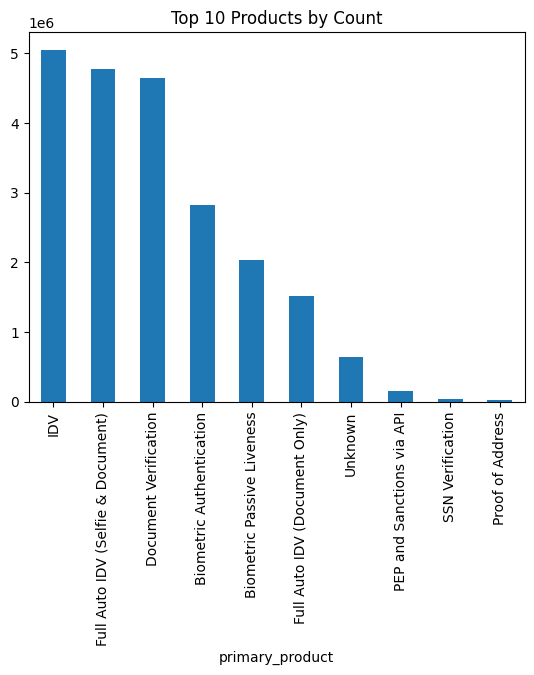

In [131]:
df.groupby('primary_product').volume.sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Products by Count')

In [142]:
df.groupby('customer_top_20').industry.unique()

customer_top_20
Aplazo                                                                                                                                                                                                                                                                                                                                                                                                                     [Software]
Arab Banking Corporation (Bank ABC/ Ila Bank)                                                                                                                                                                                                                                                                                                                                                                               [Finance]
Bumble                                                                                                                                      